# Analyze tau across radial range (core widths and iterative)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
from matplotlib import rcParams
from matplotlib.lines import Line2D

# Plot both tau vs. core widths, tau vs. iterative slices (tau vs. radius, essentially)
# using HG param calculation method
# now have outer core radii ending in -5 so they're actually symmetrical

In [2]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata



def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata



def optimize_tau_lp(obsdata):
    
    # Find "small" (<6) e or i
    low_phase_mask = obsdata['Mean Phase'] <= 60
    low_phase_obsdata = obsdata[low_phase_mask]
    lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
    lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
    lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

    low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
    low_i_mask = np.abs(obsdata['Incidence']-90) < 6
    low_ei_mask = low_e_mask | low_i_mask
    
    print(low_phase_obsdata.shape)
    
    best_tau = None
    best_slope = 1e38
    for tau in np.arange(0.000, 0.101, 0.001):

        #get the tau-adjusted EW values for the core/Region 2
        corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=('Normal EWI', None, \
                                                                            'Normal EWC', tau, \
                                                                            'Normal EWO', None)) 

        coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
        if abs(coeff[0]) < best_slope:
            best_slope = abs(coeff[0])
            best_tau = tau
        #print(f'Tau {tau:.3f} - Slope: {coeff[0]:8.5f}')

    print()
    print(f'** Best Tau: {best_tau:.3f}')
    
    return best_tau


    
# optimize for best-fit tau, HG param method
def optimize_tau_hg(obsdata, nstd=None):
    best_tau = None
    best_std = 1e38
    for tau in np.arange(0.000, 0.101, 0.001):
        hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, nstd, obsdata, col_tau=('Normal EWI', None, \
                                                                                            'Normal EWC', tau, \
                                                                                            'Normal EWO', None))

        if hg_std < best_std:
            best_std = hg_std
            best_tau = tau

    print()
    print(f'** Best Tau: {best_tau:.3f}')
    return best_tau

In [3]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

size = '0' #slice/step size of the csv file, currently only have 0

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#nstd to cut off for fit_hg_phase_function 
nstd = None

#step size for iterative plot
step = '10'

#choose HG or low-phase method to calculate
method = 'hg' #lp or hg

#list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
outliers = outliers + ['ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS'] #105 outliers
outliers = outliers + ['ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS'] #85 outliers

# Plot core widths

In [4]:
#Read in + calculate tau for different core widths (10-km through 600-km)
# REGULAR METHOD
radius0 = 139470
radius3 = 140965

best_taus = []
core_widths = []

for r in range(5,301,5):
    radius1 = 140220 - r
    radius2 = 140220 + r

    #use all 3 regions, 4 boundaries between the regions
    radii = [str(radius0), str(radius1), str(radius2-5), str(radius3)]
    
    
    #get the full-width image data
    full_img_filepath = f'{dump_ew_dir}ew_stats_widths_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
    full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation'); ms=20; alpha=0.7

    #calculate mu, mu0 
    full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
    full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))
    
    #remove EQX observations
    removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

    #remove outliers
    obsdata = remove_outliers(removed_eqx_obsdata, outliers)
    
    #calculate best tau depending on the method chosen
    if method == 'hg':
        best_tau = optimize_tau_hg(obsdata, nstd=nstd)
    elif method == 'lp':
        best_tau = optimize_tau_lp(obsdata)

    
    #append core width, best-fit tau to lists
    best_taus.append(best_tau)
    core_widths.append(2*r)

Removed EQX OBSIDs: {'ISS_110RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS']
Unique observation names: 136

Ratio min -0.12680273670011658 Max 0.125821009993782 Sigma 0.04508704144393762
Ratio min -0.12665522975509247 Max 0.12578992873875372 Sigma 0.04504408697949025
Ratio min -0.12650646251443792 Max 0.1257585973438983 Sigma 0.04500114573862027
Ratio min -0.1263570171385713 Max 0.1257270021711723 Sigma 0.044958003546099176
Ratio min -0.12620673906617505 Max 0.12569520675587945 Sigma 0.044914700513180326
Ratio min -0.1260558108206158 Max 0.12566309883683

Ratio min -0.11988337225301614 Max 0.1217136511313126 Sigma 0.04119621555363512
Ratio min -0.11999434713824932 Max 0.1216576539773173 Sigma 0.041167446409835454
Ratio min -0.12010351969028707 Max 0.12160140505734639 Sigma 0.04113896547875512
Ratio min -0.12021471770764595 Max 0.12154490589029189 Sigma 0.04111105444823769
Ratio min -0.12032599917926061 Max 0.1214881339797672 Sigma 0.04108358360715639
Ratio min -0.12043868183608936 Max 0.12143108681053344 Sigma 0.04105665464231284

** Best Tau: 0.100
Removed EQX OBSIDs: {'ISS_110RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_04

Ratio min -0.12511566204036573 Max 0.11857246276215755 Sigma 0.04041650833516776
Ratio min -0.12531358213894553 Max 0.11846953480237096 Sigma 0.040418222987009304
Ratio min -0.12551150920937496 Max 0.11836619706549148 Sigma 0.040421522767281226
Ratio min -0.1257118015653838 Max 0.11826234671931 Sigma 0.04042660010141373
Ratio min -0.12591285263244942 Max 0.1181580843465524 Sigma 0.04043333767959063
Ratio min -0.12611405872572387 Max 0.11805335319025431 Sigma 0.040441708333240484
Ratio min -0.1263203492761543 Max 0.1179480149227292 Sigma 0.04045209269083335
Ratio min -0.1265257604306642 Max 0.1178423128634745 Sigma 0.04046404238941579
Ratio min -0.12673276764540603 Max 0.11773613510761234 Sigma 0.04047775752367452
Ratio min -0.1269425107791557 Max 0.11762942561703979 Sigma 0.040493334786340936
Ratio min -0.1271523384584203 Max 0.11752231282932023 Sigma 0.040510576716432024
Ratio min -0.1273629742453097 Max 0.11741476223178544 Sigma 0.04052954701047194

** Best Tau: 0.089
Removed EQX OBS

Ratio min -0.12913803829580375 Max 0.11649573214049477 Sigma 0.04076333655154693
Ratio min -0.12940552056696453 Max 0.11635729904738022 Sigma 0.0408035571996737
Ratio min -0.12967468043612645 Max 0.11621830308049942 Sigma 0.04084646708697803
Ratio min -0.12994800527785863 Max 0.1160786011240653 Sigma 0.040892259891178166
Ratio min -0.13022160881361527 Max 0.11593832056744278 Sigma 0.040940648289222864
Ratio min -0.13049666684365446 Max 0.11579749247804438 Sigma 0.04099171327445121
Ratio min -0.1307748696623474 Max 0.11565601625196568 Sigma 0.041045584994842815
Ratio min -0.13105200681262943 Max 0.11551405141115775 Sigma 0.04110194799861873
Ratio min -0.1313347613937656 Max 0.11537128887959996 Sigma 0.04116130575951909
Ratio min -0.13161831640101435 Max 0.1152279884388161 Sigma 0.04122328809529071
Ratio min -0.13190287142699977 Max 0.11508419240159942 Sigma 0.0412879016702759
Ratio min -0.1321902705188669 Max 0.11493967717017793 Sigma 0.04135529620734392
Ratio min -0.13247690017041203 M

Ratio min -0.13267487955971352 Max 0.11518009693442048 Sigma 0.041339697101108665
Ratio min -0.13300414772939617 Max 0.11501727692544114 Sigma 0.04141228637510207
Ratio min -0.13333744729395033 Max 0.11485365431607901 Sigma 0.04148839140374676
Ratio min -0.13367126280840141 Max 0.11498222092549758 Sigma 0.041567731101211834
Ratio min -0.13400743197372106 Max 0.11640643731690375 Sigma 0.04165044046634086
Ratio min -0.13434408474650947 Max 0.11783029972520064 Sigma 0.04173636512413102
Ratio min -0.13468567825877328 Max 0.11925647947773686 Sigma 0.04182582279778303
Ratio min -0.13502641105298913 Max 0.12068129321214398 Sigma 0.04191836181694804
Ratio min -0.1353720272810648 Max 0.12210835119094464 Sigma 0.04201440262337721
Ratio min -0.13571937826833236 Max 0.12353560473934137 Sigma 0.04211369005478302
Ratio min -0.13606754249457909 Max 0.12496233711519283 Sigma 0.04221613184257018
Ratio min -0.13641895149671854 Max 0.12639025864150177 Sigma 0.04232190792983794
Ratio min -0.13677112963007

Ratio min -0.13492519546525264 Max 0.11490666258602361 Sigma 0.04167080014490731
Ratio min -0.1353032915693683 Max 0.11609632438198964 Sigma 0.04175795372150867
Ratio min -0.13568403775543378 Max 0.11763791402016528 Sigma 0.04184894714023697
Ratio min -0.13606605519710815 Max 0.11917899939245029 Sigma 0.041943651628428856
Ratio min -0.13645048181469832 Max 0.12072044272225138 Sigma 0.04204214652845541
Ratio min -0.13683907042457188 Max 0.12226323367463063 Sigma 0.04214453507986203
Ratio min -0.13722749145306656 Max 0.12380445496177545 Sigma 0.042250464768597173
Ratio min -0.13761827881936417 Max 0.1253456823722959 Sigma 0.04236010167224318
Ratio min -0.1380129512989025 Max 0.12688800275278825 Sigma 0.04247354466352406
Ratio min -0.13840925727977382 Max 0.12842970706043083 Sigma 0.04259058538536306
Ratio min -0.13880819381319595 Max 0.12997159663121916 Sigma 0.04271128559053062
Ratio min -0.1392069798427629 Max 0.13151161146827664 Sigma 0.042835398115770876
Ratio min -0.1396096699536896

Ratio min -0.13573722907191013 Max 0.11544631058427858 Sigma 0.0416869129312263
Ratio min -0.13615014361598754 Max 0.11526750733714347 Sigma 0.04177230559601288
Ratio min -0.13656445202489015 Max 0.11508804893075315 Sigma 0.04186179120662466
Ratio min -0.1369820545772697 Max 0.11656014624975537 Sigma 0.04195548809835921
Ratio min -0.13740288263276892 Max 0.11817432913971074 Sigma 0.04205336225665598
Ratio min -0.137824655204325 Max 0.11978761294931527 Sigma 0.0421552377547382
Ratio min -0.13824992215804507 Max 0.12140127666061556 Sigma 0.042261256285778176
Ratio min -0.13867602667975723 Max 0.1230137758739178 Sigma 0.04237120984672652
Ratio min -0.13910578783349262 Max 0.12462673406710939 Sigma 0.04248526765778909
Ratio min -0.13953686960569228 Max 0.1262386269796685 Sigma 0.04260323078081677
Ratio min -0.1399719777249802 Max 0.12785117328104154 Sigma 0.04272526707898563
Ratio min -0.14040668616406166 Max 0.12946139952115013 Sigma 0.04285101841556781
Ratio min -0.14084543275260109 Max 

Ratio min -0.13602035806891122 Max 0.11615600613360318 Sigma 0.041631455873615004
Ratio min -0.13646080795642085 Max 0.115978105373788 Sigma 0.04171039356152549
Ratio min -0.1369035333657948 Max 0.11579938938046029 Sigma 0.041793771500286514
Ratio min -0.13734866574255492 Max 0.11562000340529613 Sigma 0.04188156261211601
Ratio min -0.13779560560389797 Max 0.11543994219894328 Sigma 0.04197370509130094
Ratio min -0.13824545745355815 Max 0.11535657306420012 Sigma 0.04207025174533928
Ratio min -0.1386974811528957 Max 0.11701014123304297 Sigma 0.04217112753814147
Ratio min -0.13915120179900686 Max 0.1186628840986575 Sigma 0.042276269599707504
Ratio min -0.1396076548554178 Max 0.12031527625693476 Sigma 0.04238571507982748
Ratio min -0.14006710992801005 Max 0.12196757937323616 Sigma 0.042499462064722444
Ratio min -0.14052871118032648 Max 0.12361914624527356 Sigma 0.04261741264632774
Ratio min -0.14099238353074905 Max 0.1252698163670093 Sigma 0.04273952375844168
Ratio min -0.1414587345117147 M

Ratio min -0.13557028821691605 Max 0.11698747512966114 Sigma 0.04149602257557005
Ratio min -0.13602958314683405 Max 0.11681243251677415 Sigma 0.04156270410817865
Ratio min -0.13648851945885923 Max 0.11663684264517474 Sigma 0.04163386143005813
Ratio min -0.13695373426671273 Max 0.11646027914973009 Sigma 0.04170996286099172
Ratio min -0.13742012072832516 Max 0.11628310588710945 Sigma 0.04179061148262553
Ratio min -0.13788873925197007 Max 0.11610520105718411 Sigma 0.041875868525064155
Ratio min -0.1383598081790081 Max 0.11592657850457568 Sigma 0.04196572376990508
Ratio min -0.13883363305121266 Max 0.11574719313842893 Sigma 0.04206017616872946
Ratio min -0.13930817617493862 Max 0.11556725473750667 Sigma 0.042159043936597716
Ratio min -0.1397874618929448 Max 0.11567928207360373 Sigma 0.042262595502589755
Ratio min -0.14026830989590897 Max 0.11735319096759572 Sigma 0.042370566165939455
Ratio min -0.14075048632057224 Max 0.11902569358391174 Sigma 0.042482903647608664
Ratio min -0.141237382317

Ratio min -0.1350225441898481 Max 0.11764743503144648 Sigma 0.04138872489991707
Ratio min -0.13549639827541016 Max 0.11747479368343094 Sigma 0.04144398607089879
Ratio min -0.13597231540438542 Max 0.1173014196781986 Sigma 0.04150409930623108
Ratio min -0.13645034362170816 Max 0.11712732636629211 Sigma 0.041569053484746876
Ratio min -0.13693147782995724 Max 0.11695252242053845 Sigma 0.0416388989961881
Ratio min -0.13741500363680323 Max 0.11677693221382905 Sigma 0.04171357720687324
Ratio min -0.1379003212475527 Max 0.11660069457137869 Sigma 0.041793014677784714
Ratio min -0.13838813118104126 Max 0.11642373879829478 Sigma 0.041877242955806394
Ratio min -0.13887939954015324 Max 0.11624602621597012 Sigma 0.041966305550419164
Ratio min -0.13937160793956357 Max 0.11606768655657314 Sigma 0.04205999658532366
Ratio min -0.13986706043704522 Max 0.11588854788605961 Sigma 0.04215845704846243
Ratio min -0.1403667708430676 Max 0.11570859731067501 Sigma 0.042261723851207085
Ratio min -0.140866386757501

Ratio min -0.13309752725723525 Max 0.11860750122177226 Sigma 0.04120022994435603
Ratio min -0.1335752393816948 Max 0.11843803143812943 Sigma 0.04123132608474522
Ratio min -0.13405504469660834 Max 0.1182678449829022 Sigma 0.041267459541782396
Ratio min -0.13453712935263018 Max 0.11809693099193078 Sigma 0.041308642308547965
Ratio min -0.13502250664832513 Max 0.11792523770406316 Sigma 0.041354943904295144
Ratio min -0.13550896206663182 Max 0.11775288318108636 Sigma 0.04140619508227143
Ratio min -0.13599754275090184 Max 0.11757982748585226 Sigma 0.04146246178734412
Ratio min -0.13649074365018934 Max 0.11740593683084911 Sigma 0.04152391354963373
Ratio min -0.13698529339149454 Max 0.11723133900385735 Sigma 0.041590301566393435
Ratio min -0.13748267052208346 Max 0.11705604787081543 Sigma 0.04166170771467838
Ratio min -0.1379824495291793 Max 0.11687998720678383 Sigma 0.041738090951937666
Ratio min -0.13848328448323072 Max 0.11670333703384128 Sigma 0.04181932242484727
Ratio min -0.1389892913215

Ratio min -0.1308637147676261 Max 0.11950651426344773 Sigma 0.04110858247291063
Ratio min -0.1313396086801647 Max 0.11933915676294796 Sigma 0.04111282666176312
Ratio min -0.13181816179365977 Max 0.11917106037018668 Sigma 0.041122272351427784
Ratio min -0.13229990018898743 Max 0.11900217562375459 Sigma 0.041136973142912425
Ratio min -0.13278318390592722 Max 0.11883259094688481 Sigma 0.041156816415648355
Ratio min -0.1332697566158135 Max 0.11866221781327349 Sigma 0.0411819373968653
Ratio min -0.13375870347205776 Max 0.11849113120660495 Sigma 0.04121226944906719
Ratio min -0.1342494939775174 Max 0.11831929655553272 Sigma 0.0412477805000164
Ratio min -0.1347440948300514 Max 0.11814666153985728 Sigma 0.041288608283434974
Ratio min -0.13523991432669769 Max 0.11797337150291189 Sigma 0.04133455636312808
Ratio min -0.1357389127585033 Max 0.11779931465139788 Sigma 0.04138576216460352
Ratio min -0.1362420782589727 Max 0.11762441043818497 Sigma 0.04144228984430545
Ratio min -0.1367461383218766 Max

Ratio min -0.12894271880198738 Max 0.12018902307088017 Sigma 0.04112060829293459
Ratio min -0.1294177240295855 Max 0.12002161112466822 Sigma 0.0411013742410174
Ratio min -0.12989573363762807 Max 0.11985338653059836 Sigma 0.0410874514219185
Ratio min -0.13037646264615446 Max 0.11968441572614436 Sigma 0.04107883866508347
Ratio min -0.13085841507778886 Max 0.11951472908633767 Sigma 0.0410754509150113
Ratio min -0.1313447237213048 Max 0.11934419940006197 Sigma 0.04107753770264639
Ratio min -0.13183229899453303 Max 0.1191729788876365 Sigma 0.04108488555849364
Ratio min -0.13232348698015342 Max 0.11900094577212637 Sigma 0.04109768226174598
Ratio min -0.13281649506313353 Max 0.11882819600989139 Sigma 0.04111580415699695
Ratio min -0.13331167127609675 Max 0.11865471749862651 Sigma 0.04113928385182655
Ratio min -0.13381120149341083 Max 0.11848041618926802 Sigma 0.04116828528295716
Ratio min -0.1343124133174448 Max 0.11830536912478025 Sigma 0.04120261749952481
Ratio min -0.1348152724138564 Max 0

Ratio min -0.1264831460411835 Max 0.12101297402822377 Sigma 0.04127927971385114
Ratio min -0.1269533421778253 Max 0.12084486362035006 Sigma 0.04122989607027523
Ratio min -0.12742678632361998 Max 0.12067598521134398 Sigma 0.041185822298053565
Ratio min -0.12790204555051563 Max 0.12050632999380355 Sigma 0.04114700161676572
Ratio min -0.12838123918932942 Max 0.12033583703208667 Sigma 0.04111362727779184
Ratio min -0.12886249280381634 Max 0.12016458537908636 Sigma 0.0410855965145305
Ratio min -0.1293461875183524 Max 0.11999253919595795 Sigma 0.04106297293926451
Ratio min -0.12983206888575152 Max 0.11981975810123456 Sigma 0.04104576282348308
Ratio min -0.1303222636743104 Max 0.11964612832699377 Sigma 0.04103415263462983
Ratio min -0.13081429485533133 Max 0.11947178411413081 Sigma 0.04102798006843145
Ratio min -0.13130743862282707 Max 0.1192967072703926 Sigma 0.04102721758512321
Ratio min -0.13180617704558117 Max 0.11912074628190564 Sigma 0.04103220893060304
Ratio min -0.13230602004280187 Ma

Ratio min -0.12447757950259346 Max 0.12167038850986615 Sigma 0.041527752848194543
Ratio min -0.12494678868580868 Max 0.12149959243780112 Sigma 0.041452510384178215
Ratio min -0.12541723576905078 Max 0.12132801315875404 Sigma 0.04138239994435779
Ratio min -0.1258928286064289 Max 0.12115559188483327 Sigma 0.04131775746139912
Ratio min -0.12637095591013398 Max 0.12098233178794279 Sigma 0.04125845398843222
Ratio min -0.12684945880401696 Max 0.12080836933906461 Sigma 0.04120437517708707
Ratio min -0.12733411482125945 Max 0.12063350641894703 Sigma 0.04115599394757123
Ratio min -0.1278198062461263 Max 0.12045788337208477 Sigma 0.041112982379139365
Ratio min -0.12830823638834826 Max 0.12028146404332948 Sigma 0.04107550553901218
Ratio min -0.1287984354043989 Max 0.12010425671608238 Sigma 0.04104353337852235
Ratio min -0.12929237641714394 Max 0.11992626317261876 Sigma 0.041017239100918756
Ratio min -0.12978801520814454 Max 0.11974751582002423 Sigma 0.040996508885953055
Ratio min -0.1302875068132

Ratio min -0.12198901400622145 Max 0.12252484210560743 Sigma 0.0420101311129797
Ratio min -0.12245615746024355 Max 0.12235115484789141 Sigma 0.04190324169109629
Ratio min -0.12292567422644458 Max 0.12217666524156105 Sigma 0.04180139906497321
Ratio min -0.12339573815347059 Max 0.12200136191475573 Sigma 0.041704549985235415
Ratio min -0.12387245866042695 Max 0.12182515335836275 Sigma 0.041613202226275084
Ratio min -0.12435057349713098 Max 0.1216481315656762 Sigma 0.04152704687869906
Ratio min -0.12483091814343075 Max 0.12147036317268572 Sigma 0.041446201225301356
Ratio min -0.1253123800432003 Max 0.12129176269619209 Sigma 0.0413706593251171
Ratio min -0.1258003839708051 Max 0.12111226533631622 Sigma 0.04130086820687051
Ratio min -0.12628926714522704 Max 0.12093198966039556 Sigma 0.04123647658005911
Ratio min -0.12678020196588674 Max 0.12075090261066812 Sigma 0.04117762369083601
Ratio min -0.12727603298360715 Max 0.12056896228725755 Sigma 0.041124565092144835
Ratio min -0.1277729135914803

Ratio min -0.11992649088481383 Max 0.12325265840434452 Sigma 0.04255085945128392
Ratio min -0.12039270120756233 Max 0.12307455256701111 Sigma 0.04241686585503649
Ratio min -0.12086210101315659 Max 0.12289558617958113 Sigma 0.0422878214152658
Ratio min -0.12133762597236952 Max 0.12271572602226107 Sigma 0.042164021177423586
Ratio min -0.1218139259532146 Max 0.12253503189858306 Sigma 0.04204517108671508
Ratio min -0.12229285622636422 Max 0.12235347239864161 Sigma 0.04193148629347333
Ratio min -0.1227758716683846 Max 0.12217106098287699 Sigma 0.041823147559103956
Ratio min -0.12325928390226217 Max 0.12198785377570845 Sigma 0.041719968885818526
Ratio min -0.12374686133297925 Max 0.12180376527367044 Sigma 0.04162229846218878
Ratio min -0.12423840496682764 Max 0.12161882835507452 Sigma 0.041530192076064516
Ratio min -0.12473212507534373 Max 0.1214330266232723 Sigma 0.041443595666889176
Ratio min -0.1252281351046603 Max 0.12124644343571644 Sigma 0.04136257605744087
Ratio min -0.125726472411808

Ratio min -0.11941731204979852 Max 0.12403837086367979 Sigma 0.04323914590899726
Ratio min -0.11866884792446494 Max 0.12385521917740536 Sigma 0.04307815053216206
Ratio min -0.11873304772891774 Max 0.12367119168576808 Sigma 0.04292175364573034
Ratio min -0.11920979461983217 Max 0.12348626203597717 Sigma 0.04277035124497779
Ratio min -0.11968863391634409 Max 0.12330047198678332 Sigma 0.042623809154531844
Ratio min -0.12016795871324487 Max 0.12311382836774494 Sigma 0.04248211033975684
Ratio min -0.12065366244716064 Max 0.12292625950820535 Sigma 0.042345766291554315
Ratio min -0.12114031440508298 Max 0.1227378442233312 Sigma 0.04221448268375662
Ratio min -0.1216295716529149 Max 0.12254856502193902 Sigma 0.04208846648417745
Ratio min -0.12212392226856064 Max 0.12235836695933178 Sigma 0.04196798548821453
Ratio min -0.12261998536984453 Max 0.12216733345245562 Sigma 0.041852879509066174
Ratio min -0.12311710286628388 Max 0.1219754571017138 Sigma 0.04174318576119248
Ratio min -0.123618985559321

Ratio min -0.12077507768415865 Max 0.12432419652848903 Sigma 0.0435312980530902
Ratio min -0.1200138716881157 Max 0.12413296488507915 Sigma 0.04335684064938077
Ratio min -0.11925126343231642 Max 0.1239408572580044 Sigma 0.043187067366084256
Ratio min -0.11848695437339818 Max 0.12374784030001929 Sigma 0.04302221757076514
Ratio min -0.11893626670239157 Max 0.12355389650288782 Sigma 0.0428626002981639
Ratio min -0.11942763529880321 Max 0.1233590521473881 Sigma 0.04270787776007491
Ratio min -0.1199224878944241 Max 0.12316331703077767 Sigma 0.042558405600220596
Ratio min -0.12042229881926148 Max 0.12296664309609355 Sigma 0.04241439135624214
Ratio min -0.12092416531298426 Max 0.1227691012324515 Sigma 0.042275723007974324
Ratio min -0.1214276208985316 Max 0.12257064789802627 Sigma 0.04214246742240495
Ratio min -0.12193392949222306 Max 0.12237133044586833 Sigma 0.042014800799247735
Ratio min -0.122445954306057 Max 0.12217103419577825 Sigma 0.04189302688058883
Ratio min -0.12295919008138394 Max

Ratio min -0.12374212743761476 Max 0.12504058162832438 Sigma 0.044250924958525444
Ratio min -0.12297324222005504 Max 0.12484311568453257 Sigma 0.04405281187292483
Ratio min -0.12220222332583722 Max 0.12464471845400184 Sigma 0.04385955247618094
Ratio min -0.12142946269977488 Max 0.1244453642471705 Sigma 0.04367112470247485
Ratio min -0.1206554236298581 Max 0.12424508183856359 Sigma 0.043487455996341406
Ratio min -0.11987961994194099 Max 0.12404387045438989 Sigma 0.043308855368179966
Ratio min -0.11910249834517034 Max 0.12384170264297648 Sigma 0.043135272631327666
Ratio min -0.11863668938321123 Max 0.12363860257712395 Sigma 0.042966998468341545
Ratio min -0.11914365704437864 Max 0.12343457212569474 Sigma 0.04280403908292008
Ratio min -0.11965483142784909 Max 0.12322960690391468 Sigma 0.042646605304267164
Ratio min -0.12016801514967594 Max 0.12302370639166381 Sigma 0.04249464915631052
Ratio min -0.12068455538551093 Max 0.12281684960420221 Sigma 0.04234837023778113
Ratio min -0.12120135118

Ratio min -0.12680252504637715 Max 0.1258210145581696 Sigma 0.04508712151530964
Ratio min -0.12602655317119046 Max 0.12561763818133692 Sigma 0.044864914676080794
Ratio min -0.12524814909658297 Max 0.1254133108752396 Sigma 0.044647520149664235
Ratio min -0.12446863980025856 Max 0.1252079784745314 Sigma 0.04443457820828127
Ratio min -0.12368749773498759 Max 0.12500168854956123 Sigma 0.044226402951440216
Ratio min -0.12290479011856995 Max 0.12479442730455037 Sigma 0.04402310086261288
Ratio min -0.12212046784117511 Max 0.12458620747573598 Sigma 0.04382481400426562
Ratio min -0.12133487469246952 Max 0.12437698837179204 Sigma 0.04363154753468798
Ratio min -0.12054748009668416 Max 0.1241668180497571 Sigma 0.04344361783576468
Ratio min -0.11975866397995244 Max 0.12395567634024539 Sigma 0.043261006395425725
Ratio min -0.11896837248541672 Max 0.12374356792188942 Sigma 0.04308385458449161
Ratio min -0.11883483429712419 Max 0.12353048743382353 Sigma 0.04291231529073423
Ratio min -0.119357966779495

Ratio min -0.1252230483071453 Max 0.12539452317689972 Sigma 0.0446343266392011
Ratio min -0.12443070187512248 Max 0.12517976538938103 Sigma 0.04441545795514113
Ratio min -0.12363712128496053 Max 0.1249640047120524 Sigma 0.044201592329600935
Ratio min -0.12284244563909535 Max 0.12474723442731198 Sigma 0.04399281030545969
Ratio min -0.12204576123638783 Max 0.12452946843882325 Sigma 0.04378959651350323
Ratio min -0.1212476626015455 Max 0.12431071454147172 Sigma 0.0435918491480135
Ratio min -0.12044837412829974 Max 0.12409090100646578 Sigma 0.04339963480057809
Ratio min -0.11964761300743039 Max 0.12387017409018801 Sigma 0.043213142663584315
Ratio min -0.11884550053435354 Max 0.12364843666707669 Sigma 0.04303248583144722
Ratio min -0.11903746964308365 Max 0.12342567574100692 Sigma 0.04285784712301249
Ratio min -0.11957971971483164 Max 0.12320193450797584 Sigma 0.04268914742450685
Ratio min -0.1201278188253984 Max 0.12297717418879685 Sigma 0.042526843778035686
Ratio min -0.12067825610982091 

Ratio min -0.12680262236827639 Max 0.12582101284793795 Sigma 0.04508708471394397
Ratio min -0.1260013389042407 Max 0.12559953105289104 Sigma 0.04485154792738046
Ratio min -0.1251986492222097 Max 0.12537701655702907 Sigma 0.04462120568238692
Ratio min -0.1243946182787757 Max 0.12515347396771023 Sigma 0.04439617352268838
Ratio min -0.12358936940184226 Max 0.12492889690984599 Sigma 0.044176546751376826
Ratio min -0.12278230409707398 Max 0.12470330177869773 Sigma 0.04396269316622317
Ratio min -0.12197403574222292 Max 0.12447664330768984 Sigma 0.043754529559931435
Ratio min -0.12116454510030551 Max 0.1242489547157706 Sigma 0.043552189014027735
Ratio min -0.1203539278216844 Max 0.12402028794763512 Sigma 0.043355750946839265
Ratio min -0.11954167553622749 Max 0.12379056815341577 Sigma 0.04316557794573641
Ratio min -0.11872805128808811 Max 0.12355982747165892 Sigma 0.04298168774030063
Ratio min -0.11924335964449845 Max 0.12332805674674945 Sigma 0.04280410370172772
Ratio min -0.1198043846415952

Ratio min -0.12598933200044982 Max 0.12559160315579193 Sigma 0.04484476772098172
Ratio min -0.12517427077192422 Max 0.12536113865042292 Sigma 0.04460819539571252
Ratio min -0.12435856157779045 Max 0.12512961520796273 Sigma 0.04437708514528372
Ratio min -0.12354111151705122 Max 0.12489702481916232 Sigma 0.04415200846054234
Ratio min -0.12272255188033059 Max 0.1246633999386515 Sigma 0.043932857154618185
Ratio min -0.12190273260908412 Max 0.12442868636626146 Sigma 0.043719853214556126
Ratio min -0.12108200893441876 Max 0.12419294983525803 Sigma 0.04351297697392335
Ratio min -0.12025928423172366 Max 0.12395612886851949 Sigma 0.04331282677645469
Ratio min -0.11943609341256321 Max 0.12371828347632498 Sigma 0.04311891102001857
Ratio min -0.1188687434766339 Max 0.12347937297397699 Sigma 0.04293180940116033
Ratio min -0.11944823877044738 Max 0.12323939875760967 Sigma 0.0427515791945937
Ratio min -0.12002845194047136 Max 0.12299841366319432 Sigma 0.04257810314260775
Ratio min -0.1206142118405802

Ratio min -0.12597669558185862 Max 0.1255844329448898 Sigma 0.044838236241051814
Ratio min -0.12514979551464026 Max 0.1253467632466309 Sigma 0.044595245676778125
Ratio min -0.1243217970742134 Max 0.1251079921792332 Sigma 0.044358318715304025
Ratio min -0.12349222666931438 Max 0.12486816554158275 Sigma 0.044127778150744555
Ratio min -0.12266176211388725 Max 0.12462722996207273 Sigma 0.04390353217931301
Ratio min -0.12183023928180874 Max 0.12438523610715427 Sigma 0.04368577748302593
Ratio min -0.12099715068799718 Max 0.12414214272571573 Sigma 0.043474878827191046
Ratio min -0.1201631551340526 Max 0.1238979997239757 Sigma 0.04327070581409172
Ratio min -0.11932840917061321 Max 0.12365276827954612 Sigma 0.043073352323440985
Ratio min -0.11905182760427108 Max 0.12340643613724545 Sigma 0.04288336110304249
Ratio min -0.11964864444196674 Max 0.12315906706306251 Sigma 0.04270048506471174
Ratio min -0.1202484060710475 Max 0.12291061141731394 Sigma 0.04252495658790196
Ratio min -0.1208512744353851

Ratio min -0.12596395213129866 Max 0.12557792148575528 Sigma 0.04483172741828178
Ratio min -0.12512462554160128 Max 0.12533366241154834 Sigma 0.044582537760910985
Ratio min -0.12428343545230974 Max 0.1250883665346985 Sigma 0.0443400985789282
Ratio min -0.12344148805388842 Max 0.12484195173084774 Sigma 0.0441041724172392
Ratio min -0.12259855143072859 Max 0.12459440001987328 Sigma 0.043875013239235996
Ratio min -0.12175463603220701 Max 0.12434576495551586 Sigma 0.04365275503566354
Ratio min -0.1209093457010928 Max 0.12409601034513693 Sigma 0.043437722547912026
Ratio min -0.120063272953378 Max 0.12384518472207896 Sigma 0.04322981624274539
Ratio min -0.11921606607728456 Max 0.12359322112106995 Sigma 0.043029349728884364
Ratio min -0.11922831306908098 Max 0.12334019469825294 Sigma 0.04283632002282382
Ratio min -0.11984214546572364 Max 0.12308604216944447 Sigma 0.042650951398679166
Ratio min -0.12045889601808871 Max 0.12283082173887226 Sigma 0.04247335106681884
Ratio min -0.1210807077824284

Ratio min -0.12595041313878785 Max 0.12557200053606918 Sigma 0.04482547352294254
Ratio min -0.1250973748708522 Max 0.12532186920291072 Sigma 0.044570483071981734
Ratio min -0.1242434563516507 Max 0.12507057825124446 Sigma 0.04432231250979893
Ratio min -0.12338824880174559 Max 0.12481816993203551 Sigma 0.04408127317844481
Ratio min -0.12253219799453405 Max 0.12456463016084603 Sigma 0.04384736170749926
Ratio min -0.12167510578745282 Max 0.12430997782129369 Sigma 0.04362081188122337
Ratio min -0.1208171563938153 Max 0.12405418485631764 Sigma 0.04340172090014159
Ratio min -0.11995826726474194 Max 0.12379725430494634 Sigma 0.04319027788991388
Ratio min -0.11909850224780162 Max 0.1235392244752916 Sigma 0.04298659784653679
Ratio min -0.11939614384180013 Max 0.12328006127600259 Sigma 0.04279076487463518
Ratio min -0.12002888558657138 Max 0.12301975680195801 Sigma 0.04260319858143143
Ratio min -0.12066272893233945 Max 0.12275836812296353 Sigma 0.04242368992640581
Ratio min -0.12130074823988643 

Ratio min -0.12593657592178178 Max 0.12556665811810494 Sigma 0.044819229974674496
Ratio min -0.12506912912054607 Max 0.12531115253026548 Sigma 0.04455861888921164
Ratio min -0.12420073896558985 Max 0.12505448597490304 Sigma 0.044305255504939973
Ratio min -0.12333179044266591 Max 0.12479668421649978 Sigma 0.044059153373271334
Ratio min -0.12246189983064172 Max 0.1245377106336823 Sigma 0.0438206441972463
Ratio min -0.12159116699862973 Max 0.12427758613276912 Sigma 0.043589849908611075
Ratio min -0.12071997467387564 Max 0.1240163141492786 Sigma 0.04336678166600305
Ratio min -0.11984747589072403 Max 0.1237538897854218 Sigma 0.04315194134380333
Ratio min -0.11897396764995988 Max 0.12349029324820304 Sigma 0.042945378659906365
Ratio min -0.11955709525523636 Max 0.12322561659035193 Sigma 0.04274682258285864
Ratio min -0.12020615545968061 Max 0.12295973561972398 Sigma 0.04255703814142231
Ratio min -0.12085740838316653 Max 0.12269274990962387 Sigma 0.0423757970382839
Ratio min -0.121511153215343

Ratio min -0.12680286167682098 Max 0.12582099705888805 Sigma 0.045086996564435454
Ratio min -0.12592139821270681 Max 0.1255618401322633 Sigma 0.04481331051574649
Ratio min -0.12503893591489124 Max 0.12530148540561387 Sigma 0.04454712232714021
Ratio min -0.12415567824254904 Max 0.12503994804061655 Sigma 0.04428852998784662
Ratio min -0.12327196373412505 Max 0.12477723761184481 Sigma 0.044037576197113265
Ratio min -0.12238748489541522 Max 0.12451335077720731 Sigma 0.04379455670742166
Ratio min -0.1215020386258871 Max 0.12424827992600568 Sigma 0.043559728364353886
Ratio min -0.12061592055698882 Max 0.12398203583543874 Sigma 0.04333314135770782
Ratio min -0.11972939771130194 Max 0.12371463890825327 Sigma 0.04311484713682407
Ratio min -0.11905309424343526 Max 0.12344604458916009 Sigma 0.04290529852975233
Ratio min -0.11971304212756405 Max 0.12317629330702518 Sigma 0.04270441811682388
Ratio min -0.12037636416006031 Max 0.12290537303095371 Sigma 0.04251242780417134
Ratio min -0.12104148790108

Ratio min -0.125905028709541 Max 0.1255574670749169 Sigma 0.04480758883637347
Ratio min -0.12500665688070736 Max 0.1252927565766157 Sigma 0.04453588952932517
Ratio min -0.1241077571775975 Max 0.12502682001306673 Sigma 0.04427209608746016
Ratio min -0.1232080863095717 Max 0.12475968756669503 Sigma 0.04401647642925576
Ratio min -0.12230788295159409 Max 0.1244913387090592 Sigma 0.04376912590289747
Ratio min -0.12140706063494655 Max 0.12422180090120406 Sigma 0.04353024688958115
Ratio min -0.12050568082871572 Max 0.12395108710682369 Sigma 0.04329998509842895
Ratio min -0.1196036431950584 Max 0.12367915657023357 Sigma 0.04307856641424475
Ratio min -0.11918295910252227 Max 0.12340603547944365 Sigma 0.04286602052067701
Ratio min -0.11985865270014716 Max 0.12313172137065986 Sigma 0.04266278683208991
Ratio min -0.12053618486818393 Max 0.12285622125389785 Sigma 0.04246873260048209
Ratio min -0.121216522094796 Max 0.12257952310832512 Sigma 0.042284072618886795
Ratio min -0.12190029760901581 Max 0.

Ratio min -0.12588812933037646 Max 0.12555354949303596 Sigma 0.04480172515277353
Ratio min -0.12497271946197483 Max 0.12528486061531385 Sigma 0.044524633103181686
Ratio min -0.1240569070407476 Max 0.12501495769484638 Sigma 0.04425579943601105
Ratio min -0.12314052118813171 Max 0.12474379635453488 Sigma 0.04399549455461024
Ratio min -0.12222387255931591 Max 0.12447143437175326 Sigma 0.043743762882444706
Ratio min -0.12130664581052315 Max 0.12419784960032906 Sigma 0.043500918776833
Ratio min -0.12038904591757052 Max 0.12392305359219163 Sigma 0.04326705626525638
Ratio min -0.11947043094408474 Max 0.1236470057040859 Sigma 0.04304262427008259
Ratio min -0.11930646672255792 Max 0.1233697888248177 Sigma 0.04282727459351157
Ratio min -0.11999702519428003 Max 0.12309130567290136 Sigma 0.042621750652459246
Ratio min -0.12068592068700486 Max 0.12281167878899044 Sigma 0.04242555090788908
Ratio min -0.12138156105717451 Max 0.12253078937912064 Sigma 0.042239432762971305
Ratio min -0.1220803801412779

Ratio min -0.12586985470966067 Max 0.12554996341121352 Sigma 0.044796025246621705
Ratio min -0.12493704070035144 Max 0.12527761338899596 Sigma 0.04451333043663406
Ratio min -0.12400331469410011 Max 0.12500407009390788 Sigma 0.044239494350194045
Ratio min -0.1230692878901624 Max 0.12472926184866373 Sigma 0.04397450115207426
Ratio min -0.12213487047509913 Max 0.12445319424823165 Sigma 0.04371857550587909
Ratio min -0.12120014727730086 Max 0.12417588989846193 Sigma 0.043471864083620235
Ratio min -0.12026498899261877 Max 0.12389733808285235 Sigma 0.04323460630260094
Ratio min -0.11932942345714541 Max 0.1236175486686935 Sigma 0.04300696789040724
Ratio min -0.11942678538668894 Max 0.12333652568057789 Sigma 0.04278898383720226
Ratio min -0.12012738547955207 Max 0.12305425700818196 Sigma 0.042580925047674564
Ratio min -0.12083165950722 Max 0.12277079451592883 Sigma 0.04238297601453577
Ratio min -0.12154001875957068 Max 0.12248606479118053 Sigma 0.042195325663329446
Ratio min -0.122249328207638

Ratio min -0.12585122156836062 Max 0.1255466944142838 Sigma 0.0447901310396192
Ratio min -0.12489918474098242 Max 0.1252710892681228 Sigma 0.04450217613119973
Ratio min -0.12394685408361075 Max 0.12499421960248541 Sigma 0.04422328667717955
Ratio min -0.12299463616328533 Max 0.12471604986553315 Sigma 0.04395351579346397
Ratio min -0.12204154943503738 Max 0.1244366652495605 Sigma 0.043693416253353726
Ratio min -0.12108854774522372 Max 0.1241559976412287 Sigma 0.04344282968606218
Ratio min -0.12013555318253838 Max 0.12387405307606437 Sigma 0.04320197103449741
Ratio min -0.11918196383708238 Max 0.12359083853894651 Sigma 0.0429712638585909
Ratio min -0.11953949876038404 Max 0.12330639317824205 Sigma 0.042750612813692496
Ratio min -0.12025466970487103 Max 0.12302066960629851 Sigma 0.042540421347781715
Ratio min -0.1209722342633378 Max 0.12273367118827526 Sigma 0.04234066665182101
Ratio min -0.12169175387000465 Max 0.12244546960357039 Sigma 0.04215146188361136
Ratio min -0.12241478857918345 M

Ratio min -0.1258313279548868 Max 0.12554369300911222 Sigma 0.04478442957205616
Ratio min -0.12485990128878098 Max 0.1252650612039419 Sigma 0.04449101241829453
Ratio min -0.12388835142007382 Max 0.12498515804059925 Sigma 0.04420702326477013
Ratio min -0.12291664467927851 Max 0.12470394718666963 Sigma 0.04393269347859277
Ratio min -0.12194506925426556 Max 0.1244214573033774 Sigma 0.04366810135444297
Ratio min -0.12097282901537965 Max 0.12413763576832129 Sigma 0.04341377915059711
Ratio min -0.12000083486922938 Max 0.12385258525752645 Sigma 0.043169522198626194
Ratio min -0.11902879633422135 Max 0.12356619385216668 Sigma 0.04293567297953277
Ratio min -0.11965153944474405 Max 0.12327859428885254 Sigma 0.04271243692993693
Ratio min -0.12037791201483383 Max 0.12298968317078059 Sigma 0.042499925565404835
Ratio min -0.1211074928731956 Max 0.12269949936729029 Sigma 0.04229832073619
Ratio min -0.12183985860468664 Max 0.1224080337550952 Sigma 0.04210774829913611
Ratio min -0.12257621540667606 Max

Ratio min -0.12481997459764603 Max 0.1252597184345957 Sigma 0.044479707163890506
Ratio min -0.12382878625469644 Max 0.12497709996057728 Sigma 0.044190596240004126
Ratio min -0.12283750117685101 Max 0.12469317038184421 Sigma 0.04391155745510354
Ratio min -0.12184614247756795 Max 0.12440791041382497 Sigma 0.04364279686514863
Ratio min -0.12085450073399143 Max 0.12412136302131296 Sigma 0.04338458691557497
Ratio min -0.11986337501551264 Max 0.12383352045195337 Sigma 0.043136808495759904
Ratio min -0.11902421330213524 Max 0.12354437935573005 Sigma 0.04289980070537202
Ratio min -0.11976113136384037 Max 0.12325387762287265 Sigma 0.04267399290424912
Ratio min -0.1204980433166717 Max 0.12296213350202663 Sigma 0.04245911015725567
Ratio min -0.12124127687661734 Max 0.1226690750605261 Sigma 0.04225577359747089
Ratio min -0.12198399464447615 Max 0.12237479036195839 Sigma 0.04206364387170152
Ratio min -0.12273424006594323 Max 0.12207913812162043 Sigma 0.04188345996761427
Ratio min -0.123485447487345

Ratio min -0.1257911332461999 Max 0.12553864951397553 Sigma 0.04477270216438862
Ratio min -0.12478009560910604 Max 0.1252549490584527 Sigma 0.044468185489762745
Ratio min -0.12376886506956401 Max 0.12496991899628448 Sigma 0.04417400051883511
Ratio min -0.1227573834265095 Max 0.1246835384874861 Sigma 0.0438903973942585
Ratio min -0.12174641452426456 Max 0.12439583712602985 Sigma 0.043617279396135834
Ratio min -0.12073588755327372 Max 0.1241068221160446 Sigma 0.04335487608278333
Ratio min -0.11972507795332782 Max 0.1238164574803138 Sigma 0.043103691796027785
Ratio min -0.11912082644349388 Max 0.12352479838802642 Sigma 0.042863555626382305
Ratio min -0.11986832773219272 Max 0.12323180674443417 Sigma 0.04263489926358324
Ratio min -0.12061987626419166 Max 0.12293750228305098 Sigma 0.042417871297540884
Ratio min -0.12137273252045189 Max 0.12264188381852059 Sigma 0.042212444822733425
Ratio min -0.122128652180234 Max 0.12234498382129629 Sigma 0.04201889937278582
Ratio min -0.12289150676807027 

Ratio min -0.1257710800861485 Max 0.1255366641045565 Sigma 0.04476675780361953
Ratio min -0.12474010559895932 Max 0.12525093466853246 Sigma 0.04445668389895734
Ratio min -0.12370895054074796 Max 0.12496385443336744 Sigma 0.04415736649586979
Ratio min -0.12267824874100298 Max 0.12467542850748953 Sigma 0.043868781339095
Ratio min -0.12164775516015384 Max 0.1243856672319881 Sigma 0.043591237826235966
Ratio min -0.12061764755187804 Max 0.12409454475845896 Sigma 0.04332488696420229
Ratio min -0.11958824983039273 Max 0.12380208936143576 Sigma 0.04306979345586003
Ratio min -0.11921643579066284 Max 0.12350827392263276 Sigma 0.04282654506522785
Ratio min -0.1199770955261615 Max 0.12321313162880534 Sigma 0.042595109720427286
Ratio min -0.12073750430517191 Max 0.12291668045922158 Sigma 0.042375400258383204
Ratio min -0.12150543908303243 Max 0.12261883529200066 Sigma 0.04216814715888313
Ratio min -0.12227307610384364 Max 0.12231973752096652 Sigma 0.04197293985967319
Ratio min -0.12304486001520265 

Ratio min -0.12575132362986546 Max 0.12553496540756626 Sigma 0.04476076807097282
Ratio min -0.12470081471671522 Max 0.12524755017209296 Sigma 0.044445022025531085
Ratio min -0.12365027394148576 Max 0.12495878769822172 Sigma 0.04414038527043188
Ratio min -0.12260029766813609 Max 0.12466863688435194 Sigma 0.043846869451169994
Ratio min -0.12155071641787621 Max 0.12437713830796208 Sigma 0.04356474903230442
Ratio min -0.12050182691908307 Max 0.12408424859640405 Sigma 0.04329413778008934
Ratio min -0.11945299490982168 Max 0.12379001436576254 Sigma 0.04303548366810586
Ratio min -0.11931154304351346 Max 0.12349442109583174 Sigma 0.04278863227423817
Ratio min -0.12008258117389016 Max 0.12319747953006494 Sigma 0.04255406876616251
Ratio min -0.1208581788797651 Max 0.12289914540462202 Sigma 0.04233197404794644
Ratio min -0.12163640305793419 Max 0.12259950440274273 Sigma 0.04212237497279207
Ratio min -0.12241579591860267 Max 0.12229855290126833 Sigma 0.041925329663773415
Ratio min -0.1232011716571

Ratio min -0.12573247593281817 Max 0.125533667115325 Sigma 0.044754607131798185
Ratio min -0.1246625255813303 Max 0.1252449307579517 Sigma 0.044433327338882396
Ratio min -0.12359323259643673 Max 0.12495480535930202 Sigma 0.04412330439323611
Ratio min -0.12252428766462142 Max 0.12466328768077943 Sigma 0.043824893262205955
Ratio min -0.1214562845715611 Max 0.12437039937383133 Sigma 0.043538080625173246
Ratio min -0.12038858180497226 Max 0.12407612426339519 Sigma 0.04326334694934402
Ratio min -0.11932145376695565 Max 0.12378047845234987 Sigma 0.043000793759678774
Ratio min -0.11940763076991384 Max 0.12348343975805763 Sigma 0.04275054482053869
Ratio min -0.12019155116446209 Max 0.12318503152015749 Sigma 0.042512950318484975
Ratio min -0.12097680195495825 Max 0.12288529156789808 Sigma 0.042287970841391076
Ratio min -0.12176638917013569 Max 0.12258417045363744 Sigma 0.04207599990594344
Ratio min -0.12256030893898101 Max 0.1222816854832657 Sigma 0.04187720103043697
Ratio min -0.12335576617066

Ratio min -0.12571364640257043 Max 0.12553264253109644 Sigma 0.04474886168450679
Ratio min -0.1246252798575702 Max 0.12524286624153977 Sigma 0.04442206381523516
Ratio min -0.12353786137645631 Max 0.12495168999364624 Sigma 0.0441067980653826
Ratio min -0.12245101953787978 Max 0.12465911439859736 Sigma 0.04380344595943276
Ratio min -0.12136479840782259 Max 0.12436513352110865 Sigma 0.043512226118603135
Ratio min -0.12027927582856059 Max 0.12406975991722669 Sigma 0.04323333042434365
Ratio min -0.11919419580528949 Max 0.1237729925410004 Sigma 0.0429670820038134
Ratio min -0.11950038498263278 Max 0.12347481483976065 Sigma 0.04271347391356572
Ratio min -0.12029403371002803 Max 0.12317529128955748 Sigma 0.04247271321858789
Ratio min -0.12109301914438032 Max 0.12287435050281198 Sigma 0.0422452273185374
Ratio min -0.12189387967738013 Max 0.12257206004225178 Sigma 0.04203094242640456
Ratio min -0.12269794223326061 Max 0.12226839829582624 Sigma 0.04183012136147284
Ratio min -0.12350444906900288 M

Ratio min -0.12569589088230912 Max 0.12553188008952637 Sigma 0.044743367071526555
Ratio min -0.12459023330774766 Max 0.1252413438552861 Sigma 0.04441125505152456
Ratio min -0.12348486609313396 Max 0.12494935606413156 Sigma 0.04409131514477678
Ratio min -0.122380496684605 Max 0.12465596688679505 Sigma 0.043783500766766244
Ratio min -0.12127716276372671 Max 0.12436117406242456 Sigma 0.043488033244947086
Ratio min -0.12017460616900007 Max 0.12406497261483439 Sigma 0.04320524641589146
Ratio min -0.11907281227364255 Max 0.12376736000278014 Sigma 0.04293537124251695
Ratio min -0.11958765905786431 Max 0.12346831894163202 Sigma 0.042678715635399614
Ratio min -0.12039382102966034 Max 0.12316791216792695 Sigma 0.04243525265368726
Ratio min -0.12120278079260907 Max 0.12286609980913558 Sigma 0.04220523473828885
Ratio min -0.12201494034565342 Max 0.12256287575921235 Sigma 0.041988870924157234
Ratio min -0.12282921455866325 Max 0.12225831261253894 Sigma 0.041786244460857616
Ratio min -0.123648567160

Ratio min -0.1234348932802269 Max 0.12494763315632124 Sigma 0.044077105011957496
Ratio min -0.12231439908781234 Max 0.12465364712785483 Sigma 0.04376505773803831
Ratio min -0.12119413099783015 Max 0.12435821149524298 Sigma 0.043466053261522496
Ratio min -0.12007527994839018 Max 0.12406136395748303 Sigma 0.04317984421149616
Ratio min -0.11895751921996937 Max 0.12376312963554742 Sigma 0.04290677577165152
Ratio min -0.11967033568129133 Max 0.12346345317846134 Sigma 0.04264717747295704
Ratio min -0.12048513327124752 Max 0.12316236860487503 Sigma 0.04240110577903103
Ratio min -0.12130542381482266 Max 0.12285985344473645 Sigma 0.042169004194702146
Ratio min -0.12212810188007867 Max 0.12255597114671278 Sigma 0.04195082927131446
Ratio min -0.12295216378102627 Max 0.12225069491398602 Sigma 0.04174668166525279
Ratio min -0.12378065631090411 Max 0.1219440164337331 Sigma 0.04155693598171511
Ratio min -0.1246137982798404 Max 0.12163590604142738 Sigma 0.04138175563410018
Ratio min -0.125448751901582

Ratio min -0.12566347411435047 Max 0.12553087979174427 Sigma 0.04473373893814083
Ratio min -0.12452538003845999 Max 0.12523937873147897 Sigma 0.04439267028402154
Ratio min -0.12338839607929351 Max 0.12494639103322634 Sigma 0.044064151988985466
Ratio min -0.12225226568240347 Max 0.12465195927107563 Sigma 0.04374852239241415
Ratio min -0.12111722733056837 Max 0.12435608808583791 Sigma 0.04344593325249432
Ratio min -0.1199834900097989 Max 0.12405879464630448 Sigma 0.043156533274930874
Ratio min -0.1189230495598219 Max 0.12376006751818358 Sigma 0.042880674353929046
Ratio min -0.11974553056223147 Max 0.12345992377884621 Sigma 0.04261858232753331
Ratio min -0.12057301492954874 Max 0.12315828683591565 Sigma 0.04237055121138215
Ratio min -0.12140081900312945 Max 0.12285530056183769 Sigma 0.0421364317923905
Ratio min -0.12223185350857659 Max 0.12255090514016785 Sigma 0.04191661891942242
Ratio min -0.12306866871100902 Max 0.12224505656744397 Sigma 0.04171147041864917
Ratio min -0.123904820334250

Ratio min -0.12564900954388442 Max 0.12553065695429022 Sigma 0.04472950620766478
Ratio min -0.12449652572934164 Max 0.12523882074337658 Sigma 0.0443845264497241
Ratio min -0.12334529980404625 Max 0.12494552608945987 Sigma 0.04405234775529735
Ratio min -0.12219520212296978 Max 0.12465080239633405 Sigma 0.043733266288519625
Ratio min -0.12104622622251646 Max 0.12435459168660674 Sigma 0.04342755465899894
Ratio min -0.11989857592943497 Max 0.12405696062053607 Sigma 0.04313535081342737
Ratio min -0.11898584349744715 Max 0.12375788700705173 Sigma 0.042856957533537764
Ratio min -0.11981644235569053 Max 0.12345738388413245 Sigma 0.04259257413870556
Ratio min -0.12065277315163228 Max 0.12315541370793848 Sigma 0.04234259661457892
Ratio min -0.12148900716280399 Max 0.12285203836616025 Sigma 0.04210680618446432
Ratio min -0.12233153974814633 Max 0.12254719133241931 Sigma 0.04188584702206222
Ratio min -0.12317451739923936 Max 0.12224098840381543 Sigma 0.04167946401160734
Ratio min -0.12402285496680

Ratio min -0.1268025801044965 Max 0.12582093399232808 Sigma 0.04508712449096269
Ratio min -0.12563612141088684 Max 0.12553047346702464 Sigma 0.04472543615548886
Ratio min -0.12447013031987945 Max 0.12523846541252834 Sigma 0.04437691763096538
Ratio min -0.12330602679451044 Max 0.1249449945515226 Sigma 0.04404126107315559
Ratio min -0.12214288291461993 Max 0.12465004829778739 Sigma 0.043719089422478936
Ratio min -0.12098096747026241 Max 0.1243536443503616 Sigma 0.04341054632554055
Ratio min -0.11982072720693576 Max 0.12405579115971842 Sigma 0.043115695735568775
Ratio min -0.11904233225253982 Max 0.12375649230327204 Sigma 0.042834948891429823
Ratio min -0.11988447144747841 Max 0.12345568662319507 Sigma 0.04256877469687472
Ratio min -0.12072683324683732 Max 0.12315349956315833 Sigma 0.042316894424766674
Ratio min -0.12157299687556836 Max 0.12284982105827313 Sigma 0.04207976989903126
Ratio min -0.12242145081082903 Max 0.12254474619147006 Sigma 0.041857471311174586
Ratio min -0.1232749719298

Ratio min -0.1256234467523052 Max 0.12553037897814517 Sigma 0.044721928420802845
Ratio min -0.12444588117397508 Max 0.12523827815268618 Sigma 0.04436976548337885
Ratio min -0.12326972548426347 Max 0.12494467170707814 Sigma 0.044030952083185824
Ratio min -0.12209460966084937 Max 0.12464959651193606 Sigma 0.04370588417260379
Ratio min -0.12092089936062445 Max 0.12435305536823782 Sigma 0.043394675432957476
Ratio min -0.11974876776988916 Max 0.12405505617753555 Sigma 0.043097501629430095
Ratio min -0.11909793019204837 Max 0.12375555726133043 Sigma 0.0428147736302063
Ratio min -0.11994345838496312 Max 0.12345463396139163 Sigma 0.042546453870353454
Ratio min -0.12079453710715192 Max 0.12315224480625185 Sigma 0.04229308147263622
Ratio min -0.12164701886974119 Max 0.12284839957124921 Sigma 0.042054565633284774
Ratio min -0.12250510127662993 Max 0.1225430752562351 Sigma 0.041831393421788064
Ratio min -0.12336440512038575 Max 0.12223635395607609 Sigma 0.04162341951591626
Ratio min -0.12422704292

Ratio min -0.1256122027729212 Max 0.1255303480192286 Sigma 0.04471840926489288
Ratio min -0.12442345040851144 Max 0.12523816443316538 Sigma 0.04436299919371337
Ratio min -0.12323598989457576 Max 0.12494451289838066 Sigma 0.044021251992801734
Ratio min -0.12204967053407022 Max 0.12464935057499889 Sigma 0.043693509903728465
Ratio min -0.12086518794198325 Max 0.12435274113294989 Sigma 0.04337973779770983
Ratio min -0.1196821806633367 Max 0.1240546205421659 Sigma 0.04308034972093744
Ratio min -0.11914584683533148 Max 0.12375504583081212 Sigma 0.04279566569516121
Ratio min -0.11999803299917584 Max 0.12345398466711253 Sigma 0.042525632158868044
Ratio min -0.12085568043074572 Max 0.12315146747195677 Sigma 0.042270801078951384
Ratio min -0.12171710769346714 Max 0.12284746248897047 Sigma 0.04203126200705767
Ratio min -0.12258067432524652 Max 0.12254202283114923 Sigma 0.041807082162228
Ratio min -0.1234469235051545 Max 0.12223514417602836 Sigma 0.04159847405202546
Ratio min -0.12431738203874182 

Ratio min -0.1256017088543234 Max 0.12553032095721922 Sigma 0.04471504956718262
Ratio min -0.1244020546984009 Max 0.12523812558945682 Sigma 0.04435669962718931
Ratio min -0.12320431812569557 Max 0.12494443039396398 Sigma 0.04401205425616635
Ratio min -0.12200761563795365 Max 0.12464923660292004 Sigma 0.04368172652639103
Ratio min -0.12081276613804194 Max 0.12435256970815489 Sigma 0.04336565039782995
Ratio min -0.11961949468616617 Max 0.12405438026999874 Sigma 0.043064203561107066
Ratio min -0.11918909706786393 Max 0.12375473255173931 Sigma 0.04277758855037407
Ratio min -0.12005028232516896 Max 0.1234535945715702 Sigma 0.0425061671455257
Ratio min -0.12091346806358577 Max 0.1231509646357767 Sigma 0.04224996543552588
Ratio min -0.12177955960141282 Max 0.12284689291814871 Sigma 0.04200924505333586
Ratio min -0.12265012058552849 Max 0.1225413247077313 Sigma 0.041784311998017534
Ratio min -0.12352274166211136 Max 0.1222343230402904 Sigma 0.04157516351183236
Ratio min -0.12439995944904028 Ma

Ratio min -0.12680271269119173 Max 0.1258210095082023 Sigma 0.045087050741789376
Ratio min -0.1255913148170802 Max 0.125530342635077 Sigma 0.04471199644903518
Ratio min -0.12438191101804483 Max 0.12523815980530834 Sigma 0.04435061012612744
Ratio min -0.12317413193084857 Max 0.12494447050423786 Sigma 0.044003308627544244
Ratio min -0.12196786339152751 Max 0.12464927364773808 Sigma 0.0436704102610146
Ratio min -0.12076309424524187 Max 0.1243525664194316 Sigma 0.04335218662910193
Ratio min -0.11955999223362886 Max 0.12405437721681589 Sigma 0.043048818204864545
Ratio min -0.1192304773237001 Max 0.12375466880321709 Sigma 0.04276049372968307
Ratio min -0.12009730272385927 Max 0.12345347021463421 Sigma 0.042487586938049514
Ratio min -0.12096666228160863 Max 0.12315081591565373 Sigma 0.04223018198694919
Ratio min -0.1218381290748892 Max 0.12284666834692333 Sigma 0.041988457470598824
Ratio min -0.12271541271222552 Max 0.12254101416132337 Sigma 0.041762866766773335
Ratio min -0.12359416168183081

Ratio min -0.12558167758963668 Max 0.12553038703383818 Sigma 0.04470893610117959
Ratio min -0.12436263167230106 Max 0.12523826035192007 Sigma 0.04434474479520051
Ratio min -0.12314507497414308 Max 0.12494460153482104 Sigma 0.04399495977662011
Ratio min -0.12192944683216801 Max 0.12464943096456657 Sigma 0.04365967954522315
Ratio min -0.12071543711655455 Max 0.12435274195555066 Sigma 0.043339294835134025
Ratio min -0.11950318785394086 Max 0.12405455063057849 Sigma 0.04303400263654117
Ratio min -0.11927000465526949 Max 0.12375480363593848 Sigma 0.04274415569322189
Ratio min -0.1201390256545228 Max 0.12345368265538656 Sigma 0.042469615815757346
Ratio min -0.12101603215091067 Max 0.12315096330871489 Sigma 0.04221121670799824
Ratio min -0.12189282422659288 Max 0.1228468053771717 Sigma 0.04196857376679658
Ratio min -0.12277551069728693 Max 0.12254110424165586 Sigma 0.04174231812848278
Ratio min -0.12365897039336564 Max 0.12223395980549766 Sigma 0.041532252365013574
Ratio min -0.12454754649286

Ratio min -0.12557241871548694 Max 0.12553051822197792 Sigma 0.04470596604532288
Ratio min -0.12434404849615775 Max 0.125238475182697 Sigma 0.044339093711116
Ratio min -0.1231174563851968 Max 0.12494488643005265 Sigma 0.04398677412747149
Ratio min -0.12189256018172127 Max 0.12464978271687055 Sigma 0.043649307907293856
Ratio min -0.12066964637134021 Max 0.12435318020962395 Sigma 0.043326846895221004
Ratio min -0.11944844969485899 Max 0.12405501935445573 Sigma 0.043019776654966445
Ratio min -0.11930470621706893 Max 0.12375538045706164 Sigma 0.042728203447627795
Ratio min -0.12018119898819467 Max 0.12345422493462413 Sigma 0.04245249894151259
Ratio min -0.12106270182476968 Max 0.12315152806403797 Sigma 0.04219295897229683
Ratio min -0.12194514056638281 Max 0.12284737992198266 Sigma 0.04194949514930477
Ratio min -0.12283160871816876 Max 0.12254171992262948 Sigma 0.04172252217220765
Ratio min -0.12372290468662744 Max 0.12223453786224928 Sigma 0.04151227296886107
Ratio min -0.1246137926988724

Ratio min -0.12680245667216042 Max 0.1258210155892326 Sigma 0.04508714699441874
Ratio min -0.12556345235887786 Max 0.12553067559565337 Sigma 0.04470311140375082
Ratio min -0.12432623785910837 Max 0.12523876427024092 Sigma 0.04433358994925258
Ratio min -0.1230907622477979 Max 0.12494532842295349 Sigma 0.043978876239882815
Ratio min -0.12185753904768107 Max 0.12465036848453494 Sigma 0.04363905088909844
Ratio min -0.12062567288519677 Max 0.12435385606325948 Sigma 0.04331474731387354
Ratio min -0.11939617236566895 Max 0.1240558453181669 Sigma 0.043005811589947124
Ratio min -0.11934072107767514 Max 0.12375625623200934 Sigma 0.04271298883682719
Ratio min -0.12022058834819226 Max 0.12345521471146265 Sigma 0.04243589210079968
Ratio min -0.1211061725833312 Max 0.12315261916587278 Sigma 0.04217524092504817
Ratio min -0.12199495039799911 Max 0.12284851272491622 Sigma 0.04193106289556408
Ratio min -0.12288546435017071 Max 0.12254293637820282 Sigma 0.04170344238953311
Ratio min -0.12378156858108764

Ratio min -0.1255550147766303 Max 0.12553088104235194 Sigma 0.04470026757227627
Ratio min -0.12430892576912549 Max 0.1252391959089918 Sigma 0.044328299780441525
Ratio min -0.12306542954848333 Max 0.1249459698705749 Sigma 0.043971055131816414
Ratio min -0.121823135407958 Max 0.12465119807582643 Sigma 0.04362935912062827
Ratio min -0.12058313913078296 Max 0.12435487726867035 Sigma 0.04330306118220047
Ratio min -0.11934542627509573 Max 0.12405703825632348 Sigma 0.04299241758437848
Ratio min -0.11937365563178973 Max 0.12375759272578388 Sigma 0.04269810045155561
Ratio min -0.12025897060449021 Max 0.12345671037062782 Sigma 0.04241981111168722
Ratio min -0.12114948981963772 Max 0.12315425592296984 Sigma 0.04215815836656279
Ratio min -0.12204287870245585 Max 0.1228503092744699 Sigma 0.041913179922271074
Ratio min -0.12293762280546125 Max 0.1225448535987758 Sigma 0.04168496202988052
Ratio min -0.12383846903326691 Max 0.12223785989085345 Sigma 0.04147401717512824
Ratio min -0.12474095134673804 M

Ratio min -0.12554649443394053 Max 0.12553118190368218 Sigma 0.04469764452325809
Ratio min -0.12429242920050154 Max 0.1252397764596095 Sigma 0.04432308363367555
Ratio min -0.12304044320637939 Max 0.1249467980400704 Sigma 0.04396368851169215
Ratio min -0.12179034688394373 Max 0.12465229397710721 Sigma 0.04361980323365601
Ratio min -0.12054255715772698 Max 0.12435622561965153 Sigma 0.04329155445660858
Ratio min -0.11929667091085308 Max 0.12405861780776313 Sigma 0.04297935862718996
Ratio min -0.11940559819693297 Max 0.12375945511851892 Sigma 0.04268359479532864
Ratio min -0.12029625237236947 Max 0.12345875194008127 Sigma 0.04240414984547811
Ratio min -0.1211915903498634 Max 0.12315651843322616 Sigma 0.04214151955674895
Ratio min -0.12208833208017533 Max 0.1228527779327063 Sigma 0.04189568091373725
Ratio min -0.12298936612267942 Max 0.12254750256524599 Sigma 0.04166703189713858
Ratio min -0.1238926271276018 Max 0.12224073513810729 Sigma 0.041455596351363484
Ratio min -0.12480016695921459 M

Ratio min -0.12427652640103812 Max 0.12524047689989182 Sigma 0.04431802607056754
Ratio min -0.12301667717053315 Max 0.12494785911089583 Sigma 0.04395640174016571
Ratio min -0.12175908127590249 Max 0.12465368617680793 Sigma 0.043610383267226556
Ratio min -0.12050307995444197 Max 0.12435795072723736 Sigma 0.04328051188974978
Ratio min -0.11924947704077322 Max 0.12406063860171276 Sigma 0.042966745349839894
Ratio min -0.11943632807912459 Max 0.1237617978376528 Sigma 0.042669411093629164
Ratio min -0.12033197579940172 Max 0.12346140757005043 Sigma 0.042388811479068755
Ratio min -0.12123121212475596 Max 0.12315952012062599 Sigma 0.04212515804194174
Ratio min -0.12213159734846499 Max 0.12285604440339212 Sigma 0.0418784993425149
Ratio min -0.12303758971564628 Max 0.122551034776342 Sigma 0.04164933499087396
Ratio min -0.12394554876706916 Max 0.12224453346284228 Sigma 0.041437578527680284
Ratio min -0.12485807402061874 Max 0.1219364714676755 Sigma 0.04124357495835249
Ratio min -0.125773259325274

Ratio min -0.12553088363697487 Max 0.1255319626218499 Sigma 0.04469243508810695
Ratio min -0.1242612502030921 Max 0.12524135163182806 Sigma 0.04431308174818534
Ratio min -0.12299404271566663 Max 0.1249491396194428 Sigma 0.04394921336777015
Ratio min -0.12172882224975143 Max 0.12465537252764786 Sigma 0.04360127547665945
Ratio min -0.12046566704823963 Max 0.12436003411441576 Sigma 0.043269525833612384
Ratio min -0.11920448722122831 Max 0.12406311651590979 Sigma 0.04295427478403556
Ratio min -0.11946714876254529 Max 0.12376467193854661 Sigma 0.042655598119062874
Ratio min -0.12036713036165836 Max 0.12346465718633828 Sigma 0.04237382494029497
Ratio min -0.12127027428992965 Max 0.12316309586480387 Sigma 0.04210917860694888
Ratio min -0.12217680121798066 Max 0.12285998796082731 Sigma 0.04186188485638783
Ratio min -0.12308619145647812 Max 0.12255533006675758 Sigma 0.041632100660541675
Ratio min -0.12399863799419361 Max 0.12224916582221197 Sigma 0.041420008379047024
Ratio min -0.12491405893819

Ratio min -0.12680246260886105 Max 0.125821015616839 Sigma 0.04508714485837247
Ratio min -0.12552354558417944 Max 0.12553246346880353 Sigma 0.044689931803328614
Ratio min -0.12424656775980351 Max 0.1252423258287454 Sigma 0.044308294486905805
Ratio min -0.12297212897515859 Max 0.12495061101295764 Sigma 0.0439423013385112
Ratio min -0.12169987828775161 Max 0.12465732078151726 Sigma 0.0435923802789306
Ratio min -0.12042932292448104 Max 0.12436244859570131 Sigma 0.043259012715917665
Ratio min -0.11916135779163894 Max 0.12406600341645482 Sigma 0.04294211607175926
Ratio min -0.11949657522366142 Max 0.12376797952694056 Sigma 0.04264205802354546
Ratio min -0.12040168521376182 Max 0.12346839179253709 Sigma 0.04235919415278495
Ratio min -0.12130720117003281 Max 0.12316730248324852 Sigma 0.04209345790541406
Ratio min -0.1222194691871547 Max 0.12286459027999225 Sigma 0.041845517345849834
Ratio min -0.12313282747291988 Max 0.12256037972973952 Sigma 0.0416151556317234
Ratio min -0.12405031895825894 

Ratio min -0.12551645906098963 Max 0.12553302960925325 Sigma 0.04468752027689609
Ratio min -0.12423259845875659 Max 0.12524342132993996 Sigma 0.044303606811502194
Ratio min -0.12295112194030706 Max 0.1249522391168589 Sigma 0.04393560005619368
Ratio min -0.12167174224324749 Max 0.12465946261845108 Sigma 0.0435839145555755
Ratio min -0.12039511710018899 Max 0.12436512820607241 Sigma 0.04324856527049073
Ratio min -0.11912014985889989 Max 0.12406919783549203 Sigma 0.04293027265602406
Ratio min -0.11952598828305397 Max 0.1237716756217788 Sigma 0.042628909394814646
Ratio min -0.12043462985487134 Max 0.12347261571651 Sigma 0.04234486857970345
Ratio min -0.12134419212795637 Max 0.12317200163776047 Sigma 0.04207818833462411
Ratio min -0.12226116378525259 Max 0.12286978088095069 Sigma 0.04182954014142749
Ratio min -0.12317890408007831 Max 0.12256602081336672 Sigma 0.04159864554692675
Ratio min -0.12410039916446389 Max 0.12226073874996031 Sigma 0.04138588547950168
Ratio min -0.1250243549319214 Ma

Ratio min -0.12680261680937832 Max 0.1258210136005122 Sigma 0.04508708607511592
Ratio min -0.12550964808545806 Max 0.1255336143377709 Sigma 0.04468521269033418
Ratio min -0.1242194967432996 Max 0.12524461525967004 Sigma 0.044298977344304324
Ratio min -0.12293133781119686 Max 0.12495401664493179 Sigma 0.04392900374390955
Ratio min -0.12164550852130972 Max 0.12466182304191402 Sigma 0.04357545950979647
Ratio min -0.12036201747712903 Max 0.12436803433284933 Sigma 0.04323862941557602
Ratio min -0.11908081606697693 Max 0.12407267625402103 Sigma 0.04291880005222692
Ratio min -0.11955462617693435 Max 0.12377572428101584 Sigma 0.0426161660033294
Ratio min -0.12046614363656535 Max 0.12347719490613727 Sigma 0.04233094682386083
Ratio min -0.12138170949044529 Max 0.12317710526121763 Sigma 0.04206349193928927
Ratio min -0.12230039925098982 Max 0.12287544546151878 Sigma 0.041813951111344984
Ratio min -0.12322284429634157 Max 0.12257221689602729 Sigma 0.04158256194294307
Ratio min -0.12414864548771587

Ratio min -0.12550354188600438 Max 0.12553424763694396 Sigma 0.044682839118231475
Ratio min -0.12420681161330488 Max 0.1252458638109074 Sigma 0.04429460449421606
Ratio min -0.12291212417593546 Max 0.12495588802902194 Sigma 0.04392280024984796
Ratio min -0.12162052473554463 Max 0.12466432148233875 Sigma 0.04356731941672853
Ratio min -0.12033076990728099 Max 0.12437113673842237 Sigma 0.04322894677754925
Ratio min -0.11904339233290437 Max 0.12407636900674798 Sigma 0.04290774096356189
Ratio min -0.11958107771335019 Max 0.12378000876443215 Sigma 0.04260378423261585
Ratio min -0.12049673593086663 Max 0.12348208082386929 Sigma 0.04231751894106522
Ratio min -0.12141794230140177 Max 0.12318253096507382 Sigma 0.04204930782220593
Ratio min -0.12234125925019367 Max 0.12288144612620255 Sigma 0.04179911580098399
Ratio min -0.12326692628048948 Max 0.12257877633876886 Sigma 0.04156715801280794
Ratio min -0.12419682882967358 Max 0.12227454748288374 Sigma 0.04135373743013747
Ratio min -0.125128489652265

Ratio min -0.1254976713274855 Max 0.12553490538299694 Sigma 0.04468059669970433
Ratio min -0.1241945429321138 Max 0.12524718553042571 Sigma 0.044290501053681416
Ratio min -0.12289427572317072 Max 0.12495785288704463 Sigma 0.043916709145367105
Ratio min -0.12159627333231966 Max 0.12466690674277077 Sigma 0.04355975392643371
Ratio min -0.12030115537033158 Max 0.1243743761983728 Sigma 0.0432196738020251
Ratio min -0.11900826812211969 Max 0.12408023787213568 Sigma 0.04289701294193253
Ratio min -0.11960811783403472 Max 0.12378449313273156 Sigma 0.04259201136634391
Ratio min -0.12052868177517648 Max 0.12348715540129908 Sigma 0.04230481462804263
Ratio min -0.12145159751885774 Max 0.12318822036214133 Sigma 0.04203561910447752
Ratio min -0.12238023314092923 Max 0.12288770943515322 Sigma 0.04178487156980486
Ratio min -0.12330945263539933 Max 0.12258566649228318 Sigma 0.041552402271748744
Ratio min -0.12424288193850129 Max 0.12228204417335199 Sigma 0.041338643223109844
Ratio min -0.125178854818918

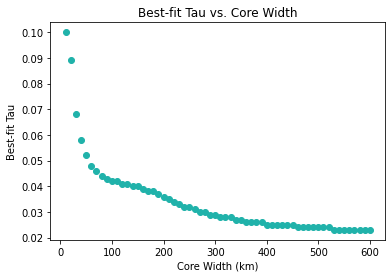

In [5]:
# Plot core width vs. tau
plt.scatter(core_widths, best_taus, c='lightseagreen')
plt.xlabel('Core Width (km)')
plt.ylabel('Best-fit Tau')
plt.title(f'Best-fit Tau vs. Core Width') # ({method} method)')
plt.show()

# Plot iterative slices

In [6]:
#get the full-width image data
full_img_filepath = f'{dump_ew_dir}ew_stats_{radius0}_{radius3}_step_{step}_{size}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation'); ms=20; alpha=0.7

#extract cols from data
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation')
    
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

#print initial statistics
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)
print()

#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

#remove outliers
obsdata = remove_outliers(removed_eqx_obsdata, outliers)

# Find "small" (<6) e or i
low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/Users/mlessard/REU_2022/data/dump_ew_csv/ew_stats_139470_140965_step_10_0.csv

Removed EQX OBSIDs: {'ISS_110RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS']
Unique observation names: 136



In [7]:
print(obsdata.columns)

Index(['Slice#', 'Num Data', 'Date', 'Min Long', 'Max Long', 'Min Res',
       'Max Res', 'Mean Res', 'Min Phase', 'Max Phase',
       ...
       'EW140950', 'EW140950 Std', 'Normal EW140950', 'Normal EW140950 Std',
       'EW140960', 'EW140960 Std', 'Normal EW140960', 'Normal EW140960 Std',
       'Mu', 'Mu0'],
      dtype='object', length=622)


In [8]:
best_taus_iter = []
radii_iter = []
mean_ews_iter = []

radii = [139470, 140965]

for radius_start in range(radii[0], radii[1], int(step)):
    #calculate best-fit tau for each radial step depending on the method chosen
    if method == 'hg':
        best_tau = None
        best_std = 1e38
        for tau in np.arange(0.000, 0.101, 0.001):
            hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, nstd, obsdata, col_tau=(f'Normal EW{radius_start}', tau))

            if hg_std < best_std:
                best_std = hg_std
                best_tau = tau

    elif method == 'lp':
        best_tau = None
        best_slope = 1e38
        for tau in np.arange(0.000, 1.001, 0.001):

            corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=(f'Normal EW{radius_start}', tau)) 

            coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
            if abs(coeff[0]) < best_slope:
                best_slope = abs(coeff[0])
                best_tau = tau
    
    best_taus_iter.append(best_tau)
    radii_iter.append(radius_start + int(step)/2)
    mean_ews_iter.append(low_phase_obsdata[f'Normal EW{radius_start}'].mean())

Ratio min -1.5708647887315303 Max 0.6188765470382125 Sigma 0.35474082857100697


/Users/mlessard/REU_2022/src/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ratio min -1.5711648295571923 Max 0.619492574150456 Sigma 0.35489889653842394
Ratio min -1.5711368916615516 Max 0.5333414403331167 Sigma 0.34797691737983816
Ratio min -1.5709316310906503 Max 0.577754851419078 Sigma 0.35067964095522786
Ratio min -1.5717612233382052 Max 0.531151801411999 Sigma 0.3479488525210538
Ratio min -1.5715117559289657 Max 0.578059322531976 Sigma 0.3509080009790567
Ratio min -1.5718055134693731 Max 0.578278160725465 Sigma 0.35103002735525907
Ratio min -1.572351348990246 Max 0.5262691697387168 Sigma 0.348241844410266
Ratio min -1.5724021180441528 Max 0.5785896423579526 Sigma 0.35127590043301105
Ratio min -1.5732132930540978 Max 0.5247411241694755 Sigma 0.3480164805124735
Ratio min -1.5730102697264252 Max 0.5788709051639438 Sigma 0.3515307492586966
Ratio min -1.5733176783117384 Max 0.5791007679621585 Sigma 0.3516669724951686
Ratio min -1.5736285592831563 Max 0.5792285332321662 Sigma 0.35180042549645324
Ratio min -1.5744619368411563 Max 0.5199689667630057 Sigma 0.3480

Ratio min -1.5087439356403465 Max 0.5040259022944454 Sigma 0.3304343811675713
Ratio min -1.509576118177588 Max 0.620560705742676 Sigma 0.34201508006302717
Ratio min -1.5103157296851115 Max 0.6211238976981681 Sigma 0.3422187495795782
Ratio min -1.510676214917348 Max 0.49724678667420463 Sigma 0.3305669733895932
Ratio min -1.5113598548611091 Max 0.49618928192740686 Sigma 0.330605983565951
Ratio min -1.5124779307984377 Max 0.6228916220502707 Sigma 0.3428516896009567
Ratio min -1.5131919370079765 Max 0.6234907419122845 Sigma 0.34306881342772194
Ratio min -1.5139356439403364 Max 0.6240510600331292 Sigma 0.3432861657977977
Ratio min -1.513870661302229 Max 0.5433905509096872 Sigma 0.33565387180091405
Ratio min -1.5153868546031342 Max 0.6252205967064748 Sigma 0.3437318120253686
Ratio min -1.5155850900174466 Max 0.571386493366678 Sigma 0.33781879984610363
Ratio min -1.5162736103466274 Max 0.49391870186294917 Sigma 0.33086836507805434
Ratio min -1.5175930274002452 Max 0.6269399602378217 Sigma 0.3

Ratio min -1.2934207293335869 Max 0.6220243573185473 Sigma 0.3189635903042838
Ratio min -1.2923237453068348 Max 0.6225429203721654 Sigma 0.31918569151876336
Ratio min -1.291134683781218 Max 0.623198033059437 Sigma 0.3194199484604511
Ratio min -1.2899973306824937 Max 0.6237802472886962 Sigma 0.3196521197930435
Ratio min -1.2890319225474622 Max 0.6241132999736209 Sigma 0.31987001058190506
Ratio min -1.2877281679773827 Max 0.6249442696151153 Sigma 0.3201248957651213
Ratio min -1.2866028814888602 Max 0.6255159666364887 Sigma 0.32036463825383027
Ratio min -1.285463209642601 Max 0.6261112832831341 Sigma 0.32060871593342694
Ratio min -1.2857894555384421 Max 0.6245585427931354 Sigma 0.32070749069988513
Ratio min -1.283355513640444 Max 0.6270577141802761 Sigma 0.3210879068008609
Ratio min -1.2833484725479194 Max 0.6259982043669597 Sigma 0.32122553742793003
Ratio min -1.2821884816541276 Max 0.6266327668136076 Sigma 0.3214825197850243
Ratio min -1.2799727416408249 Max 0.6288205833938111 Sigma 0.3

Ratio min -1.2621387324160145 Max 0.6215917006554096 Sigma 0.3044763115487383
Ratio min -1.260960896613326 Max 0.6222382157529747 Sigma 0.3047359510110797
Ratio min -1.259750688712715 Max 0.622935037829064 Sigma 0.3050021116770577
Ratio min -1.2582385739597561 Max 0.6240798430503609 Sigma 0.30530420806131087
Ratio min -1.2572587180681976 Max 0.6244418838836948 Sigma 0.30555108733052266
Ratio min -1.2562243882070896 Max 0.6248866521768278 Sigma 0.30580672939123876
Ratio min -1.254866411368388 Max 0.6258103306320324 Sigma 0.3061003298789305
Ratio min -1.2538555176686692 Max 0.6262269128280661 Sigma 0.3063592782377736
Ratio min -1.252733187246557 Max 0.6268090614807859 Sigma 0.3066328398792064
Ratio min -1.2515301302439266 Max 0.6275131539804512 Sigma 0.30691801462579216
Ratio min -1.2504136040198282 Max 0.6280915694251847 Sigma 0.3071962231107429
Ratio min -1.2493028373461665 Max 0.6286640989346625 Sigma 0.3074764221737981
Ratio min -1.248134342751823 Max 0.6293244805824173 Sigma 0.30776

Ratio min -1.6731259801743867 Max 0.6257506597435076 Sigma 0.3313766117421669
Ratio min -1.6739139703364367 Max 0.6263247016891236 Sigma 0.3316559811521335
Ratio min -1.6746338658543374 Max 0.6269684314471424 Sigma 0.33194263913674776
Ratio min -1.6754342902449935 Max 0.6275300746059057 Sigma 0.3322249326978716
Ratio min -1.6762543390663127 Max 0.6280723564475069 Sigma 0.3325095343636604
Ratio min -1.6770004719645724 Max 0.6286898826347433 Sigma 0.33280033984532553
Ratio min -1.6778865820182751 Max 0.6291653536169385 Sigma 0.3330847330195074
Ratio min -1.6785790499798772 Max 0.6298380228749701 Sigma 0.3333834930283502
Ratio min -1.679362920941582 Max 0.6304180569727662 Sigma 0.3336788904817914
Ratio min -1.6801691737782096 Max 0.6309752258806192 Sigma 0.33397365250510536
Ratio min -1.6809669145412633 Max 0.6315415108453829 Sigma 0.33427176620442905
Ratio min -1.6817629288406748 Max 0.63210980584584 Sigma 0.3345720110805232
Ratio min -1.682562270413232 Max 0.6326749508602258 Sigma 0.334

Ratio min -1.1833501008707892 Max 0.6302281272500355 Sigma 0.30001684267206186
Ratio min -1.1804911346658684 Max 0.541479854212769 Sigma 0.28917582560413907
Ratio min -1.1811330374983722 Max 0.6313654168322366 Sigma 0.3006491791318549
Ratio min -1.1800749122301866 Max 0.6318688833292299 Sigma 0.3009649530499438
Ratio min -1.1789385099944458 Max 0.6324837900710132 Sigma 0.30128966096771403
Ratio min -1.17784504890931 Max 0.6330382810726212 Sigma 0.30161236943435304
Ratio min -1.176745927709003 Max 0.6335995598196983 Sigma 0.3019370411368227
Ratio min -1.1756540820787904 Max 0.6341651416305683 Sigma 0.302265891959766
Ratio min -1.1745638995654677 Max 0.6347170138915864 Sigma 0.30259378483443894
Ratio min -1.1734603032926774 Max 0.6352984865497563 Sigma 0.30292677486169145
Ratio min -1.1723793419404656 Max 0.6358517331710508 Sigma 0.303260123096924
Ratio min -1.1713116501559548 Max 0.6363780637251905 Sigma 0.30359205160676167
Ratio min -1.1702253833586158 Max 0.6369434513292211 Sigma 0.30

Ratio min -1.3816807375337072 Max 0.6358545837669506 Sigma 0.33377665469519724
Ratio min -1.3824873470377776 Max 0.6364161977183244 Sigma 0.334125729080235
Ratio min -1.3832665780963462 Max 0.6370060288072816 Sigma 0.3344780285597286
Ratio min -1.3841143682827917 Max 0.6375260496705499 Sigma 0.33482821716965816
Ratio min -1.5172500430613833 Max 0.5071759848345139 Sigma 0.3180297202717714
Ratio min -1.3857482484242925 Max 0.6386298397159949 Sigma 0.33553684091728614
Ratio min -1.3866523493795118 Max 0.6390932029984409 Sigma 0.3358891330147314
Ratio min -1.5227804600144532 Max 0.5126928767111225 Sigma 0.3188415701484916
Ratio min -1.5226916728797477 Max 0.5168294813155021 Sigma 0.31893552749147996
Ratio min -1.3890343087660213 Max 0.6408215465576337 Sigma 0.3369715287673317
Ratio min -1.3898623339624414 Max 0.6413634151843579 Sigma 0.3373335103689545
Ratio min -1.526823276585352 Max 0.5238664032070555 Sigma 0.31963504951906724
Ratio min -1.3915163162444133 Max 0.6424499580109929 Sigma 0.

Ratio min -1.083241600669126 Max 0.571100760372511 Sigma 0.2957148768094672
Ratio min -1.077517816539619 Max 0.5087216766671412 Sigma 0.2862309934212627
Ratio min -1.0829925124303161 Max 0.6403196734831811 Sigma 0.30876370775579065
Ratio min -1.0819171612813063 Max 0.6408634925359817 Sigma 0.30914202434368876
Ratio min -1.0808884000519219 Max 0.6413395367079351 Sigma 0.30951790474505114
Ratio min -1.0797740910804676 Max 0.641947084192505 Sigma 0.3099030835901746
Ratio min -1.0786349163241797 Max 0.6425946345176095 Sigma 0.31029212698802594
Ratio min -1.0776411233953207 Max 0.6430253718201089 Sigma 0.3106698140300434
Ratio min -1.0765783738349084 Max 0.643562600846124 Sigma 0.31105522357270315
Ratio min -1.0755180673720357 Max 0.6440986194160295 Sigma 0.31144195448543993
Ratio min -1.0744602481069834 Max 0.6446333579294421 Sigma 0.3118299691125104
Ratio min -1.0734048598675405 Max 0.6451668981467605 Sigma 0.3122192391789956
Ratio min -1.0723518787079278 Max 0.6472690386929665 Sigma 0.31

Ratio min -1.0544657165124964 Max 0.6441015885084327 Sigma 0.2998639323949392
Ratio min -1.0537335493590818 Max 0.6441355524124005 Sigma 0.3002248298545772
Ratio min -1.0526497483585138 Max 0.6447065372051484 Sigma 0.30062172390108627
Ratio min -1.0516230546950407 Max 0.6451885206054988 Sigma 0.30101410177785726
Ratio min -1.0505390878177003 Max 0.6457664147048778 Sigma 0.30141446194264887
Ratio min -1.049512926201655 Max 0.646255389910438 Sigma 0.3018103223113424
Ratio min -1.0484707615970996 Max 0.6482151787708621 Sigma 0.3022088285798593
Ratio min -1.047136772447963 Max 0.6518086860822631 Sigma 0.3026378947478479
Ratio min -1.0463754476687708 Max 0.6545235871244631 Sigma 0.30301189061034656
Ratio min -1.0453348080145937 Max 0.6576497265005984 Sigma 0.30341482409701326
Ratio min -1.044266259303379 Max 0.660808416651376 Sigma 0.3038221653484421
Ratio min -1.0432290338635581 Max 0.6639056714502402 Sigma 0.3042274366216975
Ratio min -1.0421940357909545 Max 0.6669877932421727 Sigma 0.304

Ratio min -1.3000562342539475 Max 0.6492213341205983 Sigma 0.32294409846065886
Ratio min -1.3004997021063822 Max 0.6501657897299405 Sigma 0.3233772434411401
Ratio min -1.3015531814705374 Max 0.650453437639488 Sigma 0.3237779454387256
Ratio min -1.3022007157187663 Max 0.651178610398223 Sigma 0.32420201364206197
Ratio min -1.3030291207364444 Max 0.6537512497161398 Sigma 0.3246171474702785
Ratio min -1.30388443394533 Max 0.656829416373084 Sigma 0.32503181009241194
Ratio min -1.3047435479882032 Max 0.6598895368833275 Sigma 0.3254472273515212
Ratio min -1.3056179875981753 Max 0.6629192936846987 Sigma 0.3258627373421253
Ratio min -1.3065180991029868 Max 0.6659076201590397 Sigma 0.3262777360887203
Ratio min -1.3073593163842425 Max 0.6689451915915631 Sigma 0.32669686714050605
Ratio min -1.3082534135218684 Max 0.6719122222606265 Sigma 0.32711392164331315
Ratio min -1.309095428290932 Max 0.6749212731642014 Sigma 0.3275346822502292
Ratio min -1.3098936156459144 Max 0.6779635211150435 Sigma 0.3279

Ratio min -1.0890632482042368 Max 0.6596813800314706 Sigma 0.31626597812563684
Ratio min -1.0900630030257517 Max 0.660913589283539 Sigma 0.3166913778914039
Ratio min -1.0910951090114 Max 0.6621112946119556 Sigma 0.3171157793552943
Ratio min -1.0923078094854173 Max 0.6632276593938299 Sigma 0.3175305549393895
Ratio min -1.0931256563870118 Max 0.6664116300468388 Sigma 0.31796908049725825
Ratio min -1.0942947743128637 Max 0.6692248467740091 Sigma 0.31838801059861405
Ratio min -1.0952885364194773 Max 0.6722022061195282 Sigma 0.31881789397730226
Ratio min -1.0962584294271258 Max 0.6751898887506934 Sigma 0.31924990975335943
Ratio min -1.0973445662010055 Max 0.6780456198635325 Sigma 0.31967589986497136
Ratio min -1.0982087346019098 Max 0.6811129564549614 Sigma 0.32011547829074305
Ratio min -1.0993546388171334 Max 0.6838803199076292 Sigma 0.3205393702838032
Ratio min -1.1003770352951898 Max 0.6867593527729878 Sigma 0.3209710716852302
Ratio min -1.101264941620241 Max 0.6897612588910236 Sigma 0.3

Ratio min -2.0337095185524383 Max 0.6727472129245207 Sigma 0.3650059466227816
Ratio min -2.0342242494092946 Max 0.6738535875084577 Sigma 0.36539110186252177
Ratio min -2.024126883816131 Max 0.5363290658089687 Sigma 0.3360429353665823
Ratio min -2.0351339490350515 Max 0.6763072539852483 Sigma 0.366178202382476
Ratio min -2.035650732382023 Max 0.6774153995758098 Sigma 0.36656590747225004
Ratio min -2.025423895506068 Max 0.5423523177650982 Sigma 0.33684321190964017
Ratio min -2.0365931215227757 Max 0.6829726553356141 Sigma 0.36735254569313414
Ratio min -2.0262947204626465 Max 0.5463077684913296 Sigma 0.33738068664365434
Ratio min -2.026730037440885 Max 0.5482224411462108 Sigma 0.3376514149431276
Ratio min -2.038014308227205 Max 0.6914487428318341 Sigma 0.36853718619560377
Ratio min -2.0276091641506104 Max 0.5521652550113574 Sigma 0.33819208207965756
Ratio min -2.0390327335053473 Max 0.6968970718526908 Sigma 0.36932112051655186
Ratio min -2.039494693210174 Max 0.6996986460346905 Sigma 0.36

Ratio min -1.5327578429207906 Max 0.687512580491982 Sigma 0.3353532286530642
Ratio min -1.5334555342336835 Max 0.6882595700082763 Sigma 0.33574716779846786
Ratio min -1.533916584147669 Max 0.6894787750009627 Sigma 0.3361747424778968
Ratio min -1.5344260736151887 Max 0.691425828309013 Sigma 0.33659627707149603
Ratio min -1.5348952913890757 Max 0.6942411211294389 Sigma 0.3370240207305653
Ratio min -1.5353952008293756 Max 0.6969831871353556 Sigma 0.33744797668904336
Ratio min -1.5359242085246567 Max 0.6996534006383431 Sigma 0.33786810001178924
Ratio min -1.5364115662660438 Max 0.7023966493400736 Sigma 0.3382948397106849
Ratio min -1.5368985419730048 Max 0.7051284122115526 Sigma 0.3387220556452245
Ratio min -1.537375888680908 Max 0.7078674027395521 Sigma 0.33915105667414863
Ratio min -1.5378622985332624 Max 0.7105775410838592 Sigma 0.33957936689009943
Ratio min -1.538390454733414 Max 0.71319195541704 Sigma 0.3400021558026807
Ratio min -1.5388608160171806 Max 0.7159086924381718 Sigma 0.3404

Ratio min -1.2985174733673244 Max 0.7008871334945193 Sigma 0.32737249663949597
Ratio min -1.2990525285421533 Max 0.70197100309496 Sigma 0.32781047990006185
Ratio min -1.2995579539629443 Max 0.703110432851299 Sigma 0.3282527747206789
Ratio min -1.3000326676042044 Max 0.704945600684375 Sigma 0.3286988579329809
Ratio min -1.3005399220550955 Max 0.7076432763938979 Sigma 0.3291415363793139
Ratio min -1.3010558142193547 Max 0.7103192606788247 Sigma 0.3295844441372485
Ratio min -1.3015982544023907 Max 0.7129163799046525 Sigma 0.33002165168862413
Ratio min -1.2896375042887929 Max 0.5584762856185702 Sigma 0.2892697019759679
Ratio min -1.3025827911746588 Max 0.7182893989408917 Sigma 0.3309142665975133
Ratio min -1.3031012609602515 Max 0.7209095475044447 Sigma 0.33135768891110845
Ratio min -1.3036020009728035 Max 0.7235459513570546 Sigma 0.3318029533926532
Ratio min -1.3039169107180357 Max 0.7265443478351052 Sigma 0.33227663262371154
Ratio min -1.2919882075192506 Max 0.567423383296512 Sigma 0.290

Ratio min -1.1452148264253772 Max 0.7179825765528495 Sigma 0.32492291039033044
Ratio min -1.1457351112181076 Max 0.7190983613889866 Sigma 0.32537892999602125
Ratio min -1.1462589355163793 Max 0.720207307622592 Sigma 0.32583476014589646
Ratio min -1.1467820822879022 Max 0.7218465422157172 Sigma 0.3262910115813422
Ratio min -1.1473065534529951 Max 0.724470206298929 Sigma 0.3267473586769523
Ratio min -1.13463373974863 Max 0.5617350616946849 Sigma 0.28240371318296215
Ratio min -1.135119887309578 Max 0.5635357302522379 Sigma 0.2827345996758325
Ratio min -1.148883890606845 Max 0.7322634534707876 Sigma 0.32811742047604114
Ratio min -1.1494138272304908 Max 0.7348297890222509 Sigma 0.32857395081275953
Ratio min -1.1498974985010053 Max 0.7374759151012285 Sigma 0.32903778292059993
Ratio min -1.1504720994710893 Max 0.73993113755209 Sigma 0.3294878896850641
Ratio min -1.151017766226547 Max 0.7424319033085452 Sigma 0.3299425969285649
Ratio min -1.1515333825414262 Max 0.7449807081411273 Sigma 0.33040

Ratio min -1.03795743016077 Max 0.7398106249410713 Sigma 0.3258787361351193
Ratio min -1.0384939942008433 Max 0.7423928170718659 Sigma 0.32634386801037835
Ratio min -1.0390319333673912 Max 0.7449606601545672 Sigma 0.32680898080466125
Ratio min -1.039570988040559 Max 0.7475147190457407 Sigma 0.32727410129687606
Ratio min -1.0401497235249344 Max 0.749978693767622 Sigma 0.3277329941053893
Ratio min -1.0404988747830675 Max 0.7528825338885059 Sigma 0.32822853758542403
Ratio min -1.051700760733639 Max 0.5746406505044572 Sigma 0.2797070469181974
Ratio min -1.0417349633925117 Max 0.7576006493450794 Sigma 0.3291348779035057
Ratio min -1.0422089987957492 Max 0.7602249596406238 Sigma 0.32961092593706204
Ratio min -1.0428677131488973 Max 0.7624688917870184 Sigma 0.33005687967032893
Ratio min -1.0432644528333226 Max 0.7652290672345302 Sigma 0.33054633600272076
Ratio min -1.0439392139371073 Max 0.7674261943319511 Sigma 0.3309911247931243
Ratio min -1.0444590768969741 Max 0.7699143620049166 Sigma 0.3

Ratio min -1.0769495160842502 Max 0.5769883438271775 Sigma 0.27997126975628794
Ratio min -0.9529807127964108 Max 0.7684610972584118 Sigma 0.33127280214650956
Ratio min -0.9535500058212033 Max 0.7709151985740482 Sigma 0.3317425661121591
Ratio min -0.9541266951108778 Max 0.7733475645579797 Sigma 0.33221190139701984
Ratio min -0.9546498141333277 Max 0.7758695195548434 Sigma 0.332689224916863
Ratio min -0.9552189811627203 Max 0.7782905596900537 Sigma 0.33315927373660265
Ratio min -0.9556397043891092 Max 0.7809894308797847 Sigma 0.33365285294608343
Ratio min -0.9563352992747867 Max 0.7831416425174919 Sigma 0.33410287659985133
Ratio min -0.9568952366720337 Max 0.7855468634349279 Sigma 0.3345743726159455
Ratio min -0.9574546876154184 Max 0.7879420030480474 Sigma 0.33504593628503054
Ratio min -0.9580160853812076 Max 0.7903219871465311 Sigma 0.3355171077774454
Ratio min -1.0924427282156055 Max 0.5952932469604704 Sigma 0.28388258305896336
Ratio min -0.9591392456147942 Max 0.7950485713093967 Sigm

Ratio min -0.9107154510802372 Max 0.7878448648140394 Sigma 0.3382455254790402
Ratio min -0.9118800768725779 Max 0.790266564119992 Sigma 0.3387210219441935
Ratio min -0.9130317700733938 Max 0.7926886140322679 Sigma 0.33919763220740035
Ratio min -0.9142019395507157 Max 0.7950793609192529 Sigma 0.3396724721042129
Ratio min -0.9150155224062276 Max 0.7978170358918281 Sigma 0.340176250060353
Ratio min -0.9165590518822604 Max 0.7998061257528285 Sigma 0.34062021489935296
Ratio min -0.9449195399158691 Max 0.7359582045658342 Sigma 0.3176887592476733
Ratio min -0.9188708733788712 Max 0.8045284839065655 Sigma 0.3415709647872467
Ratio min -0.9199190723851476 Max 0.806979599596153 Sigma 0.342054755262234
Ratio min -0.9485137622445401 Max 0.7426237428184737 Sigma 0.31892688993273016
Ratio min -0.9223065390433992 Max 0.8115512368372484 Sigma 0.3429979439956113
Ratio min -0.9234669988767645 Max 0.8138521519346628 Sigma 0.3434718679068911
Ratio min -0.7653438901704054 Max 0.7206032249932677 Sigma 0.2885

Ratio min -0.8141228005806986 Max 0.8122461669988393 Sigma 0.3315760817454367
Ratio min -0.8147031072221697 Max 0.8145982655697542 Sigma 0.3320512398668863
Ratio min -0.8152842035172297 Max 0.8169376991566628 Sigma 0.3325261718195273
Ratio min -0.8158667257228517 Max 0.8192632819063294 Sigma 0.3330007506455375
Ratio min -0.8164492782385614 Max 0.8215777762540983 Sigma 0.33347521965142857
Ratio min -0.8170331317083073 Max 0.8238787424632638 Sigma 0.33394933278829486
Ratio min -0.8175682501273909 Max 0.8262625681107674 Sigma 0.33443197840292016
Ratio min -0.7068586240724758 Max 0.7361981674676079 Sigma 0.28756085009471244
Ratio min -0.7073248704229493 Max 0.7366280407389333 Sigma 0.28796317373697955
Ratio min -0.7077617568754948 Max 0.7371124129456648 Sigma 0.28837369206448193
Ratio min -0.7082168649185718 Max 0.7375655348247177 Sigma 0.28878360458631697
Ratio min -0.7086635396595891 Max 0.7380354077929561 Sigma 0.2891977489768051
Ratio min -0.7091099507599284 Max 0.7385073290693407 Sigm

Ratio min -0.759513079346195 Max 0.833846132885749 Sigma 0.3333690287255226
Ratio min -0.7601072080507639 Max 0.8361207233243284 Sigma 0.3338453446827825
Ratio min -2.008309025579127 Max 0.7511602722538276 Sigma 0.3383461944870631
Ratio min -2.0082578105304965 Max 0.7516359797875332 Sigma 0.33869049677237667
Ratio min -2.0082679395127037 Max 0.7520527162545297 Sigma 0.33903272015803454
Ratio min -2.4553176061643622 Max 0.41445645129182895 Sigma 0.30925741695296277
Ratio min -2.0081847052316073 Max 0.7529961842283597 Sigma 0.3397322685477128
Ratio min -2.00814483831708 Max 0.7534695308363104 Sigma 0.34008561442586543
Ratio min -2.008131962498941 Max 0.7539181866984702 Sigma 0.3404392486251639
Ratio min -2.008143370441841 Max 0.7543448530415423 Sigma 0.3407933441369729
Ratio min -2.0080989078241895 Max 0.7548295056629036 Sigma 0.34115406282149424
Ratio min -2.0081186033797853 Max 0.7552523831783122 Sigma 0.34151206837166054
Ratio min -2.0081016031346666 Max 0.7557141144045373 Sigma 0.341

Ratio min -0.9685404645644918 Max 0.7648570563680089 Sigma 0.3001239533025094
Ratio min -0.9685349545431561 Max 0.7652961099015628 Sigma 0.3005262611516844
Ratio min -0.9685108888450297 Max 0.7657559115232647 Sigma 0.30093305749463767
Ratio min -0.9684985889261045 Max 0.766206217181099 Sigma 0.3013411654320389
Ratio min -0.9685182531867097 Max 0.7666268693368918 Sigma 0.30174861467282665
Ratio min -0.9686057130365279 Max 0.7669821146578435 Sigma 0.3021519037521215
Ratio min -0.9685313015292605 Max 0.7675011159093729 Sigma 0.3025733214652826
Ratio min -0.9685344426570842 Max 0.7679449744452778 Sigma 0.3029895279192027
Ratio min -0.9685765893155148 Max 0.7683521535349359 Sigma 0.3034041980260129
Ratio min -0.9685925583879621 Max 0.7687876872872131 Sigma 0.30382386267899475
Ratio min -0.9686338832934954 Max 0.7692001639059619 Sigma 0.30424309906436664
Ratio min -0.9686769049412439 Max 0.7696131921120497 Sigma 0.3046640769763064
Ratio min -0.9687062190981393 Max 0.7700421312506683 Sigma 0.

Ratio min -0.5724205432595163 Max 0.7794040644243965 Sigma 0.292907593867696
Ratio min -0.5724080677858994 Max 0.7798634950950708 Sigma 0.2933417957712175
Ratio min -0.5724402292396019 Max 0.7802806214571208 Sigma 0.293773739637804
Ratio min -0.5724753403985826 Max 0.7806970440416391 Sigma 0.2942076429317762
Ratio min -0.572516921186813 Max 0.781109250422113 Sigma 0.294643080651498
Ratio min -0.5725610406923008 Max 0.7815211627803498 Sigma 0.29508042383968014
Ratio min -0.5726310914689441 Max 0.7819094389813416 Sigma 0.29551715056675953
Ratio min -0.5728102861834194 Max 0.7823157366085712 Sigma 0.29595764473089475
Ratio min -0.5733011953742134 Max 0.7827388146403982 Sigma 0.2964017542440083
Ratio min -0.5738060906817958 Max 0.783138455890716 Sigma 0.2968451113183438
Ratio min -0.5743235877681232 Max 0.783517266005631 Sigma 0.29728798078069457
Ratio min -0.5748303108945393 Max 0.7839166150771167 Sigma 0.2977347168344359
Ratio min -0.5753317233190158 Max 0.7843270524441144 Sigma 0.298184

Ratio min -0.5308992987398227 Max 0.7919574374778054 Sigma 0.2916828206918897
Ratio min -0.5313933207812057 Max 0.792374265764476 Sigma 0.2921283768764964
Ratio min -0.5318993613816114 Max 0.7927713676016632 Sigma 0.2925736078091879
Ratio min -0.5324138129693393 Max 0.7931550133488894 Sigma 0.2930191662147281
Ratio min -0.5329167663081577 Max 0.7935605459891822 Sigma 0.29346900170098733
Ratio min -0.5334331881615273 Max 0.7939436463631013 Sigma 0.2939180664080148
Ratio min -0.5339429223377373 Max 0.7943400681934506 Sigma 0.294370346474904
Ratio min -0.534463806050097 Max 0.7947181538765631 Sigma 0.29482223625169696
Ratio min -0.5349895946372037 Max 0.7950896319359155 Sigma 0.2952751110966167
Ratio min -0.5354692919634781 Max 0.7955428081538609 Sigma 0.29573850582171196
Ratio min -0.5360296611552634 Max 0.795855485788007 Sigma 0.29618788590067824
Ratio min -0.5365458627726625 Max 0.7962476747115617 Sigma 0.29664762950206863
Ratio min -0.53707417657803 Max 0.7966198885232475 Sigma 0.2971

Ratio min -0.4961540366853583 Max 0.8034807236818863 Sigma 0.29226444895260767
Ratio min -0.4966715716875704 Max 0.8038664585732463 Sigma 0.29272003602759145
Ratio min -0.4971914931312715 Max 0.8042495860151292 Sigma 0.2931770145563548
Ratio min -0.4977157377018307 Max 0.8046264572772792 Sigma 0.2936348837307296
Ratio min -0.4982430338244777 Max 0.8049992693572291 Sigma 0.29409385231094504
Ratio min -0.4987686854096426 Max 0.805376492649539 Sigma 0.2945548899130757
Ratio min -0.4992758107538376 Max 0.8057875484310387 Sigma 0.2950213012133876
Ratio min -0.49983411077669115 Max 0.8061101909576645 Sigma 0.2954790188711574
Ratio min -0.5004681419684003 Max 0.8063008193841764 Sigma 0.29592298599337696
Ratio min -0.5008753642569336 Max 0.8068900030421927 Sigma 0.29641382105577985
Ratio min -0.5014395078305296 Max 0.8072083943267292 Sigma 0.2968754974819928
Ratio min -0.5019823905325898 Max 0.8075640039427101 Sigma 0.29734251205804235
Ratio min -0.5025223035617747 Max 0.8079254686993245 Sigma

Ratio min -0.4680664117517624 Max 0.8140329214438642 Sigma 0.2945078263592509
Ratio min -0.4686005427915367 Max 0.8143995414554629 Sigma 0.29497150159681584
Ratio min -0.46911953649026156 Max 0.8147928824001239 Sigma 0.29543959903587463
Ratio min -0.46968900676800723 Max 0.8151013836824683 Sigma 0.29589945140067037
Ratio min -0.47021824077149627 Max 0.815480614713816 Sigma 0.2963688401567058
Ratio min -0.4707611364369808 Max 0.8158370378986661 Sigma 0.2968368405672601
Ratio min -0.8815592289815194 Max 0.42874133589336066 Sigma 0.22135607198757148
Ratio min -0.4718786017299757 Max 0.8164993487759741 Sigma 0.29777091357336
Ratio min -0.4724002717312295 Max 0.8168974388772638 Sigma 0.29824763083591677
Ratio min -0.47295021292445133 Max 0.8172475528932238 Sigma 0.29871994762525494
Ratio min -0.4735094043431255 Max 0.8175821097846893 Sigma 0.2991914905932529
Ratio min -0.47405684369838325 Max 0.8179390676236361 Sigma 0.2996668276130353
Ratio min -0.4746136379698464 Max 0.8182806737760413 Si

Ratio min -0.9488338671228532 Max 0.8232084926903755 Sigma 0.3101830476398644
Ratio min -0.9499952852432921 Max 0.8235576266620774 Sigma 0.31065404180276845
Ratio min -0.9511581115331608 Max 0.8239053887796429 Sigma 0.31112596133271814
Ratio min -0.9523731514357981 Max 0.8242009957366401 Sigma 0.31159349741056747
Ratio min -0.9534846392141956 Max 0.8246001431815203 Sigma 0.3120733135922975
Ratio min -0.9547166715263136 Max 0.8248788361119714 Sigma 0.31254118250367785
Ratio min -0.9558252649898006 Max 0.8252809471009804 Sigma 0.31302339056432554
Ratio min -0.9569808356287853 Max 0.8256361368623535 Sigma 0.3135016860789431
Ratio min -0.9581704917398799 Max 0.8259572926415899 Sigma 0.31397711539996515
Ratio min -0.9593472706565271 Max 0.8262913544327167 Sigma 0.3144550053180568
Ratio min -0.9605131247223196 Max 0.826636371394622 Sigma 0.3149349599866745
Ratio min -0.9617008654817691 Max 0.826959546771107 Sigma 0.31541347279195725
Ratio min -0.9628727901759919 Max 0.8272985653580468 Sigma 

Ratio min -1.116654710438604 Max 0.41999800303260143 Sigma 0.2372934518516642
Ratio min -0.5750750751363944 Max 0.8342385450469848 Sigma 0.3059418189716836
Ratio min -0.5762500457691632 Max 0.8345743054005809 Sigma 0.3064201523090713
Ratio min -0.5774247415276184 Max 0.8349103757454147 Sigma 0.3068995577983177
Ratio min -0.5785978113740238 Max 0.8352481058804888 Sigma 0.30738030083667645
Ratio min -0.5798086450185387 Max 0.8355481252497612 Sigma 0.30785747732379254
Ratio min -0.5809678525744385 Max 0.8358997825726256 Sigma 0.30834154808755443
Ratio min -0.5821492351354989 Max 0.8362293096148131 Sigma 0.30882410097505464
Ratio min -0.5833382939021879 Max 0.8365511997317155 Sigma 0.3093064983155387
Ratio min -0.5845212658747334 Max 0.8368792081981805 Sigma 0.30979067267468285
Ratio min -0.58579951924281 Max 0.8371120134662909 Sigma 0.3102647970443918
Ratio min -0.5869012085629216 Max 0.8375213389001791 Sigma 0.31075965258703503
Ratio min -1.1416394621487866 Max 0.44907043271572905 Sigma 

Ratio min -1.4294124382378186 Max 0.8457415020599948 Sigma 0.33293696417320306
Ratio min -1.430585663885134 Max 0.8460742348971014 Sigma 0.33340896707464146
Ratio min -1.431761690657566 Max 0.8464041472547509 Sigma 0.33388153071786897
Ratio min -1.43295375684123 Max 0.8467177570464424 Sigma 0.33435308736062896
Ratio min -1.4341339471312167 Max 0.847043501069456 Sigma 0.3348268426239819
Ratio min -1.435321298750543 Max 0.8473619851451241 Sigma 0.3353005700864804
Ratio min -1.4365087460930563 Max 0.8476804083534584 Sigma 0.33577506178731437
Ratio min -1.4377031241672338 Max 0.8479918052083883 Sigma 0.3362494882920091
Ratio min -1.438905350811717 Max 0.8482952228548336 Sigma 0.33672359066458324
Ratio min -1.4400915572945545 Max 0.8486150304954826 Sigma 0.3372004609439785
Ratio min -1.8182764342667035 Max 0.44950966149903415 Sigma 0.27981114860113593
Ratio min -1.4425038739328588 Max 0.8492140259672903 Sigma 0.3381511538567876
Ratio min -1.8209947988183455 Max 0.4542083657557674 Sigma 0.28

Ratio min -1.2976278283725313 Max 0.43480380338585944 Sigma 0.25036052287432725
Ratio min -1.2990238431389127 Max 0.4371721238631419 Sigma 0.25076045582335754
Ratio min -0.9106423658283002 Max 0.8589061986425781 Sigma 0.32051357133613806
Ratio min -0.911839232233677 Max 0.8592152451937668 Sigma 0.3209989168990852
Ratio min -0.913038619838383 Max 0.8595217773274627 Sigma 0.3214847850620533
Ratio min -1.3044984628492144 Max 0.4467076697794023 Sigma 0.2523806924530921
Ratio min -0.9154395731898138 Max 0.8601326736530159 Sigma 0.3224578638283055
Ratio min -0.9167172831214474 Max 0.8603597305650937 Sigma 0.3229369559168388
Ratio min -0.917838889532847 Max 0.8607453994007003 Sigma 0.3234338234883397
Ratio min -0.9190449961747638 Max 0.8610452401882435 Sigma 0.3239218090718922
Ratio min -0.9202574050511098 Max 0.8613386947036926 Sigma 0.32440952946539003
Ratio min -0.9214717223676923 Max 0.8616302346409314 Sigma 0.32489749498573445
Ratio min -0.946044006154624 Max 0.740994913546263 Sigma 0.30

Ratio min -1.105330618201195 Max 0.4420361757361531 Sigma 0.24080774714447398
Ratio min -1.1066797247251576 Max 0.44441141007458246 Sigma 0.24122028155114034
Ratio min -1.1080121368440115 Max 0.4468045843559364 Sigma 0.2416351210294525
Ratio min -1.1093662381447078 Max 0.4491369049374429 Sigma 0.24204903391409324
Ratio min -0.7045969000705494 Max 0.8731684627972034 Sigma 0.3201935791525305
Ratio min -1.1120676464293127 Max 0.4537671505229112 Sigma 0.24287996400202547
Ratio min -1.1134081445676454 Max 0.4560790385086098 Sigma 0.24329746465083696
Ratio min -0.7082342321052953 Max 0.8740494098101321 Sigma 0.32165732670552405
Ratio min -0.7094498742308324 Max 0.8743398680389107 Sigma 0.322145775535003
Ratio min -0.7106983315895488 Max 0.874596915842573 Sigma 0.3226300428419773
Ratio min -0.7118867946711119 Max 0.8749151414839382 Sigma 0.32312316359502513
Ratio min -0.713104288956063 Max 0.875203808482081 Sigma 0.32361256510594283
Ratio min -0.7143300500206028 Max 0.8754841203335846 Sigma 0

Ratio min -0.9735125243197889 Max 0.4445714993481781 Sigma 0.2330971472839056
Ratio min -0.9748294796119815 Max 0.4469401933651901 Sigma 0.23351714419726233
Ratio min -0.9761633918866487 Max 0.4492560581034089 Sigma 0.23393670520978513
Ratio min -0.9775010982985928 Max 0.4515480073525271 Sigma 0.234356793674284
Ratio min -0.978844427395869 Max 0.4538119179218884 Sigma 0.23477724369356515
Ratio min -0.5595519309159708 Max 0.8852520400032021 Sigma 0.32048664670378246
Ratio min -0.9815092660004108 Max 0.4583368465909071 Sigma 0.23562185912912306
Ratio min -0.5619927463241786 Max 0.885823731539457 Sigma 0.321460333616768
Ratio min -0.9841441615344073 Max 0.462858667579493 Sigma 0.23647120439489303
Ratio min -0.5644323319010519 Max 0.8863968118689641 Sigma 0.32243570114188863
Ratio min -0.9868053696876612 Max 0.46726299288609774 Sigma 0.23732117414353104
Ratio min -0.5668844196548425 Max 0.8869572782513598 Sigma 0.3234104955162834
Ratio min -0.5681011042972782 Max 0.8872470803301008 Sigma 0

Ratio min -0.857145536165839 Max 0.44648718328022186 Sigma 0.2259463001271168
Ratio min -0.8584486877486063 Max 0.44882480709106903 Sigma 0.226370090406736
Ratio min -0.8597822010745055 Max 0.4510801751448857 Sigma 0.2267928114998943
Ratio min -0.8610903236899204 Max 0.45337511562193006 Sigma 0.2272178068149377
Ratio min -0.8624109236319271 Max 0.45562412488633347 Sigma 0.22764272186619014
Ratio min -0.8637141723420386 Max 0.45789458399496696 Sigma 0.228069337395956
Ratio min -0.8650419514942165 Max 0.4600977851750501 Sigma 0.22849518042051914
Ratio min -0.8663354683676684 Max 0.46235581798207126 Sigma 0.22892359551841465
Ratio min -0.8676479666560576 Max 0.4645582556508838 Sigma 0.22935150643482613
Ratio min -0.8689646795921324 Max 0.4667361088842264 Sigma 0.22977973945568034
Ratio min -0.8702669393470022 Max 0.4689270369101472 Sigma 0.2302093011142076
Ratio min -0.8715730063122226 Max 0.4710944348735895 Sigma 0.2306391509230043
Ratio min -0.8728626473515222 Max 0.4732792847451124 Sig

Ratio min -0.7708218718213976 Max 0.4520651645895535 Sigma 0.22030885394788152
Ratio min -0.7721196006086672 Max 0.45435245460388324 Sigma 0.22073477988199156
Ratio min -0.7734344458575453 Max 0.45658502210421886 Sigma 0.22116064229936264
Ratio min -0.7747191505218102 Max 0.45886628367395876 Sigma 0.22158853548304486
Ratio min -0.7760285144421355 Max 0.4610780841651804 Sigma 0.22201598278560736
Ratio min -0.7773281493575595 Max 0.46329422170069057 Sigma 0.22244448253155524
Ratio min -0.7786244187641586 Max 0.46550115506423717 Sigma 0.22287372106576955
Ratio min -0.7799037906970586 Max 0.4677269592993434 Sigma 0.22330424605631202
Ratio min -0.7811997111584211 Max 0.4699018657300282 Sigma 0.2237345921016783
Ratio min -0.782491037651155 Max 0.47207026615326136 Sigma 0.22416564052477989
Ratio min -0.7837759783594772 Max 0.4742353471800683 Sigma 0.22459743449995723
Ratio min -0.785066405662972 Max 0.4763734772655706 Sigma 0.2250294513751147
Ratio min -0.7863519540521832 Max 0.47850536438105

Ratio min -0.7302300495721724 Max 0.45996366949162665 Sigma 0.2168401797184734
Ratio min -0.731459545873197 Max 0.4622055864806663 Sigma 0.21726705968254076
Ratio min -0.7327072087410879 Max 0.464452318046261 Sigma 0.21769496695241422
Ratio min -0.7339572181328029 Max 0.46668752051837975 Sigma 0.21812354248590177
Ratio min -0.7351762829723318 Max 0.4688835057055896 Sigma 0.21855237259334515
Ratio min -0.736395846150122 Max 0.4710675603752216 Sigma 0.21898183896137627
Ratio min -0.7376471511179812 Max 0.4732667859085412 Sigma 0.219412317175282
Ratio min -0.7388597874559305 Max 0.47541996301153583 Sigma 0.21984285457715763
Ratio min -0.7401158560355209 Max 0.47759888948196055 Sigma 0.22027451175081847
Ratio min -0.7413458188617404 Max 0.47974271423657544 Sigma 0.22070633607481951
Ratio min -0.7425582764897493 Max 0.4818584589004113 Sigma 0.22113839094550566
Ratio min -0.7438067472917066 Max 0.48399474308611085 Sigma 0.22157143724734346
Ratio min -0.7450211547053257 Max 0.4860878295110141

Ratio min -0.7130257412582238 Max 0.4686889425489092 Sigma 0.2138551508449141
Ratio min -0.7142360675972494 Max 0.4708850502910647 Sigma 0.21428187708781612
Ratio min -0.7154783755589743 Max 0.47309659940042437 Sigma 0.21470952941063357
Ratio min -0.7167163591495689 Max 0.47529222788913333 Sigma 0.21513777492601074
Ratio min -0.7179697648660714 Max 0.4774890309226924 Sigma 0.2155667474117157
Ratio min -0.719193812850008 Max 0.47964787044601503 Sigma 0.21599603009103757
Ratio min -0.7204284203049656 Max 0.48180367734030033 Sigma 0.21642593985091285
Ratio min -0.7216603866794727 Max 0.4839451123348781 Sigma 0.21685634252666042
Ratio min -0.7229115412519799 Max 0.4860913650745529 Sigma 0.21728740150145398
Ratio min -0.7241483341850588 Max 0.4882129148524886 Sigma 0.21771879267135105
Ratio min -0.7253679269792207 Max 0.4903071967145871 Sigma 0.21815046205707003
Ratio min -0.3849199359612287 Max 0.9125234976359657 Sigma 0.3270429632750024
Ratio min -0.727844547287566 Max 0.49449316299322826

Ratio min -0.6931963147995293 Max 0.466884274684643 Sigma 0.2100903486385872
Ratio min -0.3849931171129866 Max 0.9145288936189295 Sigma 0.3236855089484458
Ratio min -0.6956689780355477 Max 0.47128142565475417 Sigma 0.21094014692734017
Ratio min -0.6968982649564687 Max 0.47345549990374924 Sigma 0.21136595279180792
Ratio min -0.6981216104731117 Max 0.4756121317077314 Sigma 0.21179231704623366
Ratio min -0.6993720158778582 Max 0.4777805810918816 Sigma 0.21221935049945492
Ratio min -0.7005987630049849 Max 0.47991599095580334 Sigma 0.21264681392839727
Ratio min -0.7018201579032565 Max 0.4820345666236744 Sigma 0.21307475471590023
Ratio min -0.7030631659524245 Max 0.4841604783033309 Sigma 0.2135032712791899
Ratio min -0.7042846409239921 Max 0.4862551991648566 Sigma 0.21393214087002585
Ratio min -0.7055137529222208 Max 0.48834490519196466 Sigma 0.21436147424003274
Ratio min -0.7067645576935064 Max 0.49044215376067135 Sigma 0.2147913086474056
Ratio min -0.7079827380352964 Max 0.4924983540249859

Ratio min -2.3431792850549567 Max 0.45748709575487795 Sigma 0.3286865035769572
Ratio min -2.3445507805751578 Max 0.45965255063770044 Sigma 0.3290570267699348
Ratio min -2.3459245199525496 Max 0.4618164379871249 Sigma 0.32942810776031467
Ratio min -2.347294945030019 Max 0.46396511745559593 Sigma 0.32979925301237345
Ratio min -2.348663379680732 Max 0.4661016251958123 Sigma 0.33017056304577935
Ratio min -2.3500333638991338 Max 0.4682354567449929 Sigma 0.33054232993789856
Ratio min -2.3514007080729624 Max 0.47035577393804473 Sigma 0.3309141788826088
Ratio min -2.3527653569480615 Max 0.4724632338696807 Sigma 0.33128608919415536
Ratio min -1.7345145259581891 Max 0.9237553403568041 Sigma 0.38944333394534764
Ratio min -2.3554792362040406 Max 0.4766156414430985 Sigma 0.33202940481630167
Ratio min -2.3568373528693 Max 0.4786855938379248 Sigma 0.33240155930631504
Ratio min -2.35818672333562 Max 0.48072560595198455 Sigma 0.33277319195567023
Ratio min -2.359540711567931 Max 0.4827718446943232 Sigma

Ratio min -1.6412157687372773 Max 0.4474805803238637 Sigma 0.28227333980180697
Ratio min -1.6425804300307911 Max 0.44962235139653883 Sigma 0.28267030477119737
Ratio min -1.6439424871056163 Max 0.45175110565894816 Sigma 0.2830674269189332
Ratio min -1.102008100777097 Max 0.9302136967135952 Sigma 0.3593214124655102
Ratio min -1.6466500456241495 Max 0.45594555833349154 Sigma 0.2838615199442037
Ratio min -1.6480087500062404 Max 0.4580459532840321 Sigma 0.2842593048469169
Ratio min -1.649353620566491 Max 0.4601035481579245 Sigma 0.28465646010740253
Ratio min -1.6507038983594173 Max 0.462169083285684 Sigma 0.2850542097544909
Ratio min -1.1086064592952638 Max 0.9330526634988606 Sigma 0.36153201658320855
Ratio min -1.6533907802191221 Max 0.466244882459273 Sigma 0.2858495063886119
Ratio min -1.6547338441628694 Max 0.4682723822190408 Sigma 0.2862474431070363
Ratio min -1.656075252443076 Max 0.4702895064356162 Sigma 0.28664546266450436
Ratio min -1.657415425148715 Max 0.4722968883951592 Sigma 0.2

Ratio min -1.7645728789424666 Max 0.44154556739362716 Sigma 0.29941303321069973
Ratio min -1.7663632006496721 Max 0.44364762854724715 Sigma 0.2998302478980558
Ratio min -1.768161222482319 Max 0.44574965729712546 Sigma 0.3002481614843848
Ratio min -1.7699369976600852 Max 0.4478168803876716 Sigma 0.30066468866792107
Ratio min -1.7717243943925416 Max 0.44988865309960796 Sigma 0.3010821616943904
Ratio min -1.7734938243923144 Max 0.45193048671060465 Sigma 0.3014985216954335
Ratio min -1.7752670945217188 Max 0.4539674477268319 Sigma 0.3019152780198544
Ratio min -1.7770471378946162 Max 0.45600271780133445 Sigma 0.3023326311250878
Ratio min -1.7788150426453238 Max 0.4580150978116156 Sigma 0.30274923166248585
Ratio min -1.7805789347909777 Max 0.46001385999801686 Sigma 0.3031656383430677
Ratio min -1.782346137369313 Max 0.4620075821563281 Sigma 0.3035823476958948
Ratio min -1.784102440445893 Max 0.4639792058871477 Sigma 0.30399837994922596
Ratio min -1.7858601793764437 Max 0.46594374289871704 Si

Ratio min -1.4452790943604739 Max 0.4464004079981321 Sigma 0.2802236170476036
Ratio min -1.4470605344898413 Max 0.4484609462484451 Sigma 0.2806472695131671
Ratio min -1.4488345799339468 Max 0.45050388540462954 Sigma 0.2810706116659388
Ratio min -1.4505955422706054 Max 0.4525232134945705 Sigma 0.281493269162395
Ratio min -1.4523703326518322 Max 0.4545487282228065 Sigma 0.28191688717960295
Ratio min -1.4541263767020962 Max 0.45654403064880367 Sigma 0.282339458797245
Ratio min -1.4558827677719133 Max 0.45853148832795426 Sigma 0.28276210083377357
Ratio min -1.4576493484657176 Max 0.460520102765751 Sigma 0.2831854931279464
Ratio min -1.4594105983781493 Max 0.46249450692573946 Sigma 0.2836085887620278
Ratio min -1.461166266490471 Max 0.46445363054887834 Sigma 0.28403139343964906
Ratio min -1.462904115490476 Max 0.46638331688320367 Sigma 0.2844531563208909
Ratio min -1.464657243432427 Max 0.4683219109540696 Sigma 0.2848758641943106
Ratio min -1.1120662377450543 Max 0.40875200014378393 Sigma 0

Ratio min -1.2629406670916765 Max 0.458973157732508 Sigma 0.26838386626235183
Ratio min -1.2646966906639967 Max 0.4609719569351926 Sigma 0.26880889062130475
Ratio min -1.2664638075269743 Max 0.46297464486272744 Sigma 0.2692346087599004
Ratio min -1.2682066845916278 Max 0.464940512554393 Sigma 0.2696590972682823
Ratio min -1.26996605867053 Max 0.4669166977759851 Sigma 0.2700845426379336
Ratio min -1.2717104339908238 Max 0.46886662979637755 Sigma 0.2705092381674128
Ratio min -1.2734627774095604 Max 0.4708171662079588 Sigma 0.27093440535927626
Ratio min -1.0208153928280188 Max 0.40003508086098233 Sigma 0.22135450928156336
Ratio min -1.0224062307458832 Max 0.39960534346718946 Sigma 0.22164795350087452
Ratio min -1.0239954364782198 Max 0.39917207101542956 Sigma 0.22194514067150464
Ratio min -1.0255834916909632 Max 0.3987378343840888 Sigma 0.22224593052120217
Ratio min -1.0271700805111068 Max 0.39830115958060064 Sigma 0.2225503057105571
Ratio min -1.0287546709933648 Max 0.3978616495295419 Si

Ratio min -1.1653667018685372 Max 0.47434710627702714 Sigma 0.2595672365121332
Ratio min -1.1667141483074068 Max 0.4763049564499791 Sigma 0.259993272511265
Ratio min -1.1680571778194702 Max 0.4782615210694312 Sigma 0.26041968084439276
Ratio min -0.959024996881008 Max 0.38978083660905677 Sigma 0.2136582608655709
Ratio min -0.9606176455825016 Max 0.3893554351780749 Sigma 0.21394288641048384
Ratio min -0.9622087761946374 Max 0.388927273505982 Sigma 0.21423142675455492
Ratio min -0.9637978817297904 Max 0.3884966365072066 Sigma 0.21452372827609228
Ratio min -0.9653872868766358 Max 0.38806343850302194 Sigma 0.21482010035472113
Ratio min -0.966971533111639 Max 0.3876282626418192 Sigma 0.21511958729107983
Ratio min -0.9685549304433632 Max 0.387190110024593 Sigma 0.21542286237444117
Ratio min -0.9701371060715043 Max 0.3867496331667019 Sigma 0.21572977598151752
Ratio min -0.9717170704101379 Max 0.38630669112794097 Sigma 0.21604011509978813
Ratio min -0.9732947884433154 Max 0.38586152768873105 Si

Ratio min -0.8750704675865831 Max 0.3775533322822727 Sigma 0.20542339208524107
Ratio min -0.8766600946109565 Max 0.37712824150281365 Sigma 0.20569734671382764
Ratio min -0.8782499005463585 Max 0.3767014857679343 Sigma 0.20597564255333517
Ratio min -0.8798371117969251 Max 0.3762716854511086 Sigma 0.20625788885315605
Ratio min -0.8814219997424377 Max 0.37583942399784426 Sigma 0.20654403188469742
Ratio min -0.8830053417111828 Max 0.37540468681497097 Sigma 0.2068341182423011
Ratio min -0.8845859529902393 Max 0.3749673140448552 Sigma 0.20712791777810205
Ratio min -0.8861655738591719 Max 0.37452765608983646 Sigma 0.20742560884556469
Ratio min -0.8877424307848569 Max 0.37408548334113806 Sigma 0.2077268740074918
Ratio min -0.8893172672747822 Max 0.37364067626762243 Sigma 0.20803176779344054
Ratio min -0.8908908822851861 Max 0.3731939401366652 Sigma 0.20834032113463274
Ratio min -0.356078353974371 Max 0.9492327248150846 Sigma 0.3044026513125546
Ratio min -0.8940304002320866 Max 0.37229286767928

Ratio min -0.8056759583946087 Max 0.3624362484988043 Sigma 0.19838959011586071
Ratio min -0.8072539171945532 Max 0.3619985555468476 Sigma 0.1986675649960442
Ratio min -0.8088286985650489 Max 0.3615581049919801 Sigma 0.19894950078369458
Ratio min -0.8104040745504842 Max 0.3611158018809401 Sigma 0.19923580304596275
Ratio min -0.8119740923036487 Max 0.3606701735274392 Sigma 0.1995256516707192
Ratio min -0.8135433533875674 Max 0.36022249579085336 Sigma 0.19981956013601065
Ratio min -0.8151095624156725 Max 0.3597719968554378 Sigma 0.20011717239506127
Ratio min -0.8166752965528714 Max 0.3593197302432343 Sigma 0.20041875072917736
Ratio min -0.81823745741115 Max 0.35886465054611966 Sigma 0.20072382514086295
Ratio min -0.8197978454554582 Max 0.35840730674869564 Sigma 0.2010325715172735
Ratio min -0.8213558854155368 Max 0.35794753586622 Sigma 0.20134484857108223
Ratio min -0.8229106660248527 Max 0.3574852753706959 Sigma 0.20166045173781538
Ratio min -0.8244642195036109 Max 0.3570209229803561 Sig

Ratio min -0.7388506770312874 Max 0.3445442751890668 Sigma 0.19207833281241005
Ratio min -0.7404047669155062 Max 0.34408497408506983 Sigma 0.19236587383700224
Ratio min -0.7419557885834596 Max 0.34362307244429563 Sigma 0.19265732401513028
Ratio min -0.7435050381360757 Max 0.343158808226609 Sigma 0.19295277536773012
Ratio min -0.7450516375605488 Max 0.3426920541409389 Sigma 0.19325204708923027
Ratio min -0.7465963596728127 Max 0.34222297591682893 Sigma 0.19355517132245248
Ratio min -0.7481387983841745 Max 0.34175151442598867 Sigma 0.19386202895455837
Ratio min -0.7496782921364822 Max 0.3412776053883656 Sigma 0.1941724598207802
Ratio min -0.7512156215051033 Max 0.340801393804164 Sigma 0.1944865046457211
Ratio min -0.7527502711713538 Max 0.3403228322174623 Sigma 0.19480402368014413
Ratio min -0.7542825449933205 Max 0.33984197965958546 Sigma 0.1951249955469651
Ratio min -0.7558121620749534 Max 0.33935884142905426 Sigma 0.1954493121624872
Ratio min -0.7573388967150932 Max 0.3388733872644718

Ratio min -0.6807155802937491 Max 0.324931971986862 Sigma 0.18587244310002296
Ratio min -0.6822384984394309 Max 0.3244507261578572 Sigma 0.18616541575056475
Ratio min -0.6837600397252716 Max 0.3239671833547743 Sigma 0.18646249032670492
Ratio min -0.6852787149493305 Max 0.32348118225397676 Sigma 0.18676341388868736
Ratio min -0.6867944123376738 Max 0.32299272928949685 Sigma 0.1870680975519216
Ratio min -0.6883086208448554 Max 0.3225020791130054 Sigma 0.18737666192876826
Ratio min -0.6898200937696551 Max 0.32200902874210857 Sigma 0.18768887960777839
Ratio min -0.6913288793891873 Max 0.32151367876825004 Sigma 0.18800468313209082
Ratio min -0.6928357044213314 Max 0.321016118999716 Sigma 0.188324106641655
Ratio min -0.694339361747629 Max 0.3205162291658006 Sigma 0.1886469118828348
Ratio min -0.6958408718568843 Max 0.3200141565010496 Sigma 0.18897317818309012
Ratio min -0.6973390481137776 Max 0.31950979925382555 Sigma 0.18930266074542246
Ratio min -0.6988354022860355 Max 0.3190033549394637 S

Ratio min -0.6254881490548799 Max 0.32390616211960005 Sigma 0.17983557467146977
Ratio min -0.6269764841265494 Max 0.3235739389030245 Sigma 0.18013396012827873
Ratio min -0.6284626794766921 Max 0.3232434225591938 Sigma 0.18043633657844094
Ratio min -0.6299466089247013 Max 0.3229147263607503 Sigma 0.18074261537291286
Ratio min -0.6314279511537603 Max 0.32258814173003847 Sigma 0.18105268397139312
Ratio min -0.6329072550377702 Max 0.32226317407501975 Sigma 0.18136654008641614
Ratio min -0.6343840328838033 Max 0.32194026508462936 Sigma 0.18168405124140355
Ratio min -0.6358581620553693 Max 0.32161952604534705 Sigma 0.18200513016315628
Ratio min -0.637330042073172 Max 0.32130059506956665 Sigma 0.18232975820161973
Ratio min -0.638799396124814 Max 0.32098372683039345 Sigma 0.1826578322907844
Ratio min -0.6402662139876042 Max 0.320668925980655 Sigma 0.18298927928446118
Ratio min -0.6417308055491177 Max 0.32035591808999236 Sigma 0.18332407679107146
Ratio min -0.6431927148990026 Max 0.320045111248

Ratio min -0.5703015361519783 Max 0.32170290444727695 Sigma 0.17387877846110356
Ratio min -0.5717575855245536 Max 0.3214004767505344 Sigma 0.17418381109499534
Ratio min -0.5732116417308838 Max 0.3210995872812056 Sigma 0.17449278889481193
Ratio min -0.5746634313214956 Max 0.32080050925103226 Sigma 0.1748056184683136
Ratio min -0.5761129363705516 Max 0.32050326316215855 Sigma 0.17512222617943254
Ratio min -0.5775602264296362 Max 0.32020777172862513 Sigma 0.17544253959707143
Ratio min -0.5790053846354203 Max 0.3199139499673085 Sigma 0.1757664906203281
Ratio min -0.5804482630972995 Max 0.3196219426836785 Sigma 0.17609399567917727
Ratio min -0.5818887790219139 Max 0.3193318427650565 Sigma 0.17642498395665265
Ratio min -0.5833269917333589 Max 0.3190435816812788 Sigma 0.17675938388944207
Ratio min -0.5847628872509268 Max 0.31875717120884955 Sigma 0.1770971235889614
Ratio min -0.586196439104393 Max 0.31847263710091944 Sigma 0.17743813196392344
Ratio min -0.5876276658465476 Max 0.31818996498766

Ratio min -0.5293446594522111 Max 0.3208405520231565 Sigma 0.16807578437681256
Ratio min -0.5304287579283796 Max 0.320989618752491 Sigma 0.16838220717789926
Ratio min -0.5315169531390239 Max 0.32114098034508287 Sigma 0.16869266018714818
Ratio min -0.5326030107284179 Max 0.3212906852721051 Sigma 0.16900696037894813
Ratio min -0.5336935591928406 Max 0.32144305060881917 Sigma 0.16932513981196373
Ratio min -0.5347874220661298 Max 0.3215973010349157 Sigma 0.16964710484453366
Ratio min -0.5358829390949211 Max 0.3217524008804828 Sigma 0.169972750969622
Ratio min -0.5369802687784592 Max 0.32190851979465934 Sigma 0.17030200427641382
Ratio min -0.5380800842660194 Max 0.32206588238986567 Sigma 0.1706348106227026
Ratio min -0.5391820476316599 Max 0.32222453656358696 Sigma 0.17097108259094357
Ratio min -0.5402867632406598 Max 0.3223847754044446 Sigma 0.17131076317333854
Ratio min -0.5413925394487449 Max 0.32254555094393694 Sigma 0.171653748573345
Ratio min -0.5425014057348405 Max 0.3227082019132894

Ratio min -0.5087577466919473 Max 0.32762169505362326 Sigma 0.16261344329929575
Ratio min -0.5098304023925415 Max 0.32776467541904397 Sigma 0.16292498681964504
Ratio min -0.5109025752309142 Max 0.3279068596977075 Sigma 0.16324054138241414
Ratio min -0.5119775762914094 Max 0.328050451469254 Sigma 0.16356008426542162
Ratio min -0.5130535273480884 Max 0.3281941158290865 Sigma 0.16388350624464262
Ratio min -0.5141324795934061 Max 0.3283392679763233 Sigma 0.16421076436531887
Ratio min -0.5152118569508184 Max 0.3284843551995593 Sigma 0.16454172970727537
Ratio min -0.5162938539531762 Max 0.32863077214095754 Sigma 0.16487636788931423
Ratio min -0.5173782917247758 Max 0.32877799142269526 Sigma 0.16521461338270105
Ratio min -0.5184678552497838 Max 0.32892807964466453 Sigma 0.16555643413041107
Ratio min -0.5195556813480761 Max 0.3290768344970243 Sigma 0.16590161496749334
Ratio min -0.5206465319374424 Max 0.32922712760215983 Sigma 0.16625018276198567
Ratio min -0.521737476389251 Max 0.329377216096

Ratio min -0.49572265556480716 Max 0.36863769163941107 Sigma 0.15824725398465012
Ratio min -0.49680042835878896 Max 0.369176425230323 Sigma 0.1585786064832154
Ratio min -0.49788023378414586 Max 0.3697138384438936 Sigma 0.15891393815413224
Ratio min -0.49895632574827103 Max 0.3702501047195187 Sigma 0.15925303789122724
Ratio min -0.5000422091605993 Max 0.37078483564334375 Sigma 0.15959612804422205
Ratio min -0.5011211864005226 Max 0.3713184826001939 Sigma 0.1599427521228016
Ratio min -0.5022050687160051 Max 0.3718507544159915 Sigma 0.16029309717362286
Ratio min -0.503297438118143 Max 0.37238164623211994 Sigma 0.16064716722764147
Ratio min -0.5043807930719687 Max 0.37291142215571704 Sigma 0.16100448559880032
Ratio min -0.5054711115183037 Max 0.3734398474020096 Sigma 0.16136534117262027
Ratio min -0.5065633424705717 Max 0.3739671514030772 Sigma 0.16172953769985235
Ratio min -0.5076558480953403 Max 0.374493010860398 Sigma 0.16209697491882225
Ratio min -0.5087477076622793 Max 0.3750177208991

Ratio min -0.4828282841314599 Max 0.36519662779984297 Sigma 0.15430232284541148
Ratio min -0.48394592449610124 Max 0.3657170751026866 Sigma 0.1546844228043027
Ratio min -0.4850612233985478 Max 0.3662360098547545 Sigma 0.15506991726292005
Ratio min -0.48617885854981807 Max 0.36675352060192656 Sigma 0.15545884931027215
Ratio min -0.48730020514004974 Max 0.36727027977352295 Sigma 0.15585116176293584
Ratio min -0.4884193024178726 Max 0.367784979376018 Sigma 0.1562466390173681
Ratio min -0.4895353917412266 Max 0.3682983216049985 Sigma 0.1566451640012796
Ratio min -0.49065957138436717 Max 0.3688107438877575 Sigma 0.15704696006495833
Ratio min -0.49178322250707457 Max 0.3693217619974099 Sigma 0.15745172065009955
Ratio min -0.492907271389622 Max 0.3698314274519635 Sigma 0.15785939482782407
Ratio min -0.49403580580709494 Max 0.3703399306493765 Sigma 0.1582700207077719
Ratio min -0.49515762092205456 Max 0.37084678620766415 Sigma 0.1586832152701153
Ratio min -0.49629140657998455 Max 0.37135310292

Ratio min -0.4639630488768349 Max 0.3048334144824926 Sigma 0.15005031958548024
Ratio min -0.46514768218305746 Max 0.3075691014421596 Sigma 0.15048999792203865
Ratio min -0.4663432747747205 Max 0.31029977380990337 Sigma 0.15093299189658865
Ratio min -0.4675309511700541 Max 0.31300907084415347 Sigma 0.1513785040805345
Ratio min -0.468716583221014 Max 0.3157021239009137 Sigma 0.15182667609020686
Ratio min -0.46990901221545356 Max 0.31838662505240384 Sigma 0.15227776598031184
Ratio min -0.47110084790357765 Max 0.3210564235184495 Sigma 0.1527314147213962
Ratio min -0.4722945938441411 Max 0.32371351175160534 Sigma 0.15318764151735798
Ratio min -0.47349211413340164 Max 0.3263597828121236 Sigma 0.1536464433890144
Ratio min -0.4746818301007464 Max 0.3289846922561859 Sigma 0.15410730092433295
Ratio min -0.47587680467983123 Max 0.3316002004827655 Sigma 0.15457064414495675
Ratio min -0.47706991558102624 Max 0.3341999228960694 Sigma 0.15503612741881
Ratio min -0.4782640183232356 Max 0.3367863379782

Ratio min -0.44216673156301906 Max 0.4366279014406322 Sigma 0.14857057723824257
Ratio min -0.4434001076013206 Max 0.4376947497543361 Sigma 0.14906240812949145
Ratio min -0.44463445423667597 Max 0.4387584719354273 Sigma 0.149556523677386
Ratio min -0.4458694329384606 Max 0.43981878506483535 Sigma 0.1500528258230074
Ratio min -0.4470982362873294 Max 0.4408736177505157 Sigma 0.1505508781332305
Ratio min -0.4483360892907244 Max 0.44192788497318963 Sigma 0.15105142047513556
Ratio min -0.4495647927457871 Max 0.4429757543375691 Sigma 0.15155340985734167
Ratio min -0.45080317066844056 Max 0.44402315690902433 Sigma 0.152057776418254
Ratio min -0.45203532334576163 Max 0.44506516032416216 Sigma 0.15256360737056163
Ratio min -0.45327349799175637 Max 0.4461056771180948 Sigma 0.1530714854659128
Ratio min -0.4545032618399555 Max 0.44713998216538103 Sigma 0.15358057596736563
Ratio min -0.4557437652586361 Max 0.44817439333676046 Sigma 0.15409183231575843
Ratio min -0.45696948833494416 Max 0.44920068583

Ratio min -0.39632084653504396 Max 0.4125698764800736 Sigma 0.14259886064655045
Ratio min -0.3974984818418307 Max 0.41363431682460244 Sigma 0.14313575467205691
Ratio min -0.3986960105713791 Max 0.4147010908923355 Sigma 0.14367556331327933
Ratio min -0.3998901287028713 Max 0.4157631148146829 Sigma 0.14421676412573728
Ratio min -0.40108306139491257 Max 0.4168208615738959 Sigma 0.14475941324288757
Ratio min -0.4022743794887787 Max 0.4178744505777094 Sigma 0.14530342874662097
Ratio min -0.40346425360021215 Max 0.4189238165414536 Sigma 0.14584874714501034
Ratio min -0.4046571204791605 Max 0.41997048895382316 Sigma 0.14639558017806611
Ratio min -0.4058497245128748 Max 0.4210133970468174 Sigma 0.14694365942107093
Ratio min -0.40704224419840346 Max 0.42205261802344496 Sigma 0.14749293267069233
Ratio min -0.4082221628589121 Max 0.42308373587984877 Sigma 0.14804255758501214
Ratio min -0.40941461409722807 Max 0.4241156229255694 Sigma 0.14859404154648037
Ratio min -0.4106170206832562 Max 0.4251474

Ratio min -0.3337073634911748 Max 0.3968369788190562 Sigma 0.13343333663031406
Ratio min -0.33480249202105783 Max 0.3993449914331417 Sigma 0.13399635857794392
Ratio min -0.3358823516043499 Max 0.40182634604996675 Sigma 0.13455974887341995
Ratio min -0.336987614983523 Max 0.4043135183405843 Sigma 0.13512619696142422
Ratio min -0.3380764687051662 Max 0.40677320815137413 Sigma 0.1356927917556928
Ratio min -0.33916400639464395 Max 0.4092175047622438 Sigma 0.13626048922460854
Ratio min -0.34025619660117823 Max 0.41165124882901627 Sigma 0.13682962487440073
Ratio min -0.3413474346229133 Max 0.41407000310302977 Sigma 0.13739975199368118
Ratio min -0.3424375701148597 Max 0.4164737160429823 Sigma 0.13797079866684467
Ratio min -0.34352499019579646 Max 0.4188611332158265 Sigma 0.13854259173391023
Ratio min -0.3446212116501233 Max 0.42124160714119246 Sigma 0.1391158475158848
Ratio min -0.34568695495278906 Max 0.4235835217920262 Sigma 0.1396878634333021
Ratio min -0.346794127921323 Max 0.42594510217

Ratio min -0.28524430897104447 Max 0.39221706556059904 Sigma 0.12763355189386985
Ratio min -0.2862403112923335 Max 0.39505858981879743 Sigma 0.12817028217067394
Ratio min -0.2872333545535035 Max 0.39787635976004215 Sigma 0.12870849761693284
Ratio min -0.28842558945838964 Max 0.4006653119302055 Sigma 0.12924614685930114
Ratio min -0.2902789973625315 Max 0.40343867172405184 Sigma 0.12978815371785832
Ratio min -0.2921467016952042 Max 0.40619336531322636 Sigma 0.130333266327854
Ratio min -0.2939720228872354 Max 0.40891484488718355 Sigma 0.1308757586134643
Ratio min -0.2958407076734983 Max 0.4116253238519729 Sigma 0.13142410795869278
Ratio min -0.297685786066953 Max 0.41430766697007543 Sigma 0.13197157041417232
Ratio min -0.2995016722631672 Max 0.41696065413822275 Sigma 0.13251752375769782
Ratio min -0.3013442151205304 Max 0.41959856239033805 Sigma 0.13306746384767795
Ratio min -0.3032105112702796 Max 0.42222065979400747 Sigma 0.13362103563809827
Ratio min -0.3050461890475887 Max 0.42481339

Ratio min -0.2825867468072285 Max 0.37697079090976093 Sigma 0.1244840607458452
Ratio min -0.2814162579636549 Max 0.37979547860169494 Sigma 0.12495162804940886
Ratio min -0.28027896022632287 Max 0.3825850733412966 Sigma 0.12541544586889922
Ratio min -0.2791165216776583 Max 0.38536487951521914 Sigma 0.12588842991430646
Ratio min -0.27797191225970524 Max 0.3881166483919 Sigma 0.12636096135418798
Ratio min -0.2768368640627132 Max 0.3908438207951893 Sigma 0.12683480677967968
Ratio min -0.2757026328369497 Max 0.3935503679049571 Sigma 0.12731178082200678
Ratio min -0.27658434912983626 Max 0.3962339772383571 Sigma 0.12779049742543186
Ratio min -0.27836911468004744 Max 0.39889643635020494 Sigma 0.128272016637218
Ratio min -0.28012447841062715 Max 0.4015311376309438 Sigma 0.1287524259880959
Ratio min -0.2819321076484009 Max 0.40415515793866646 Sigma 0.12924084883207007
Ratio min -0.28368270408521545 Max 0.40674580188211085 Sigma 0.1297249281576544
Ratio min -0.28548497427870334 Max 0.40932571925

Ratio min -0.2617678975226641 Max 0.7094060854106687 Sigma 0.19440743627231397
Ratio min -0.4410609444928389 Max 0.3037942987447164 Sigma 0.12767929428971808
Ratio min -0.4399001755385079 Max 0.3037532292372007 Sigma 0.12806290819704283
Ratio min -0.2640540007649024 Max 0.7114803049716519 Sigma 0.19576867190927266
Ratio min -0.4376048080951166 Max 0.30367658263027014 Sigma 0.1288375723440311
Ratio min -0.26557640564133317 Max 0.7128444808286846 Sigma 0.19668797729013093
Ratio min -0.4353091228753899 Max 0.30569026466489496 Sigma 0.1296285143482599
Ratio min -0.434146181842159 Max 0.3083515682935017 Sigma 0.13003266421390586
Ratio min -0.2678782721317868 Max 0.7148215021864384 Sigma 0.1980740506743864
Ratio min -0.26864377951772966 Max 0.7154752503551645 Sigma 0.19854079044935805
Ratio min -0.2694210199190689 Max 0.7161009351935642 Sigma 0.19900395217111924
Ratio min -0.4296614146117263 Max 0.3187496191633494 Sigma 0.13165413933969503
Ratio min -0.4285463897504148 Max 0.3212972718006922

Ratio min -0.3142897583860051 Max 0.6726110628106952 Sigma 0.190459653177716
Ratio min -0.3128861983180846 Max 0.6733273766131835 Sigma 0.19088605906724662
Ratio min -0.31148546223331625 Max 0.6740407758610465 Sigma 0.19131522521855207
Ratio min -0.310097060040978 Max 0.6747414451399207 Sigma 0.19174493139314597
Ratio min -0.30870931612602004 Max 0.6754414360935791 Sigma 0.19217777994303467
Ratio min -0.30732873884441225 Max 0.6761340300014069 Sigma 0.19261223163333333
Ratio min -0.30595530643767893 Max 0.6768192482244657 Sigma 0.19304823462950502
Ratio min -0.30458050812747733 Max 0.677505879922937 Sigma 0.19348767363881503
Ratio min -0.30321858138891 Max 0.6781792232749995 Sigma 0.19392725493995447
Ratio min -0.30188201193305464 Max 0.6788263410932965 Sigma 0.19436398942855587
Ratio min -0.300503356695087 Max 0.6795170059916236 Sigma 0.1948134461647382
Ratio min -0.29915473004312104 Max 0.6801766217855381 Sigma 0.19525889120372353
Ratio min -0.29781140012361773 Max 0.6808307700826739

Ratio min -0.4260991017236644 Max 0.6039227161792504 Sigma 0.19206225902572066
Ratio min -0.4247217512286547 Max 0.6059288527963268 Sigma 0.19247185328621505
Ratio min -0.4233497585326762 Max 0.6079349051073646 Sigma 0.19288346594377254
Ratio min -0.4219830968672272 Max 0.609940894969727 Sigma 0.19329704850772597
Ratio min -0.42062172701537903 Max 0.6119468573375128 Sigma 0.19371255603520715
Ratio min -0.4192656474381891 Max 0.6139527877301938 Sigma 0.1941299366674603
Ratio min -0.41791481080974086 Max 0.6159587293783411 Sigma 0.19454914856985084
Ratio min -0.41656918925426056 Max 0.6179647051425409 Sigma 0.1949701467173051
Ratio min -0.41522874429044 Max 0.6199707488654218 Sigma 0.19539288889532086
Ratio min -0.41389348175139873 Max 0.621976848021386 Sigma 0.19581732448998668
Ratio min -0.4125633497335597 Max 0.6239830503839081 Sigma 0.1962434157676618
Ratio min -0.41123832185616216 Max 0.6259893768973883 Sigma 0.1966711200233443
Ratio min -0.4099183647623845 Max 0.6279958557810017 Si

Ratio min -0.5066724980986907 Max 0.628110733478681 Sigma 0.19866876288577015
Ratio min -0.5053431499026355 Max 0.6301000679031347 Sigma 0.1990556308158213
Ratio min -0.5040190591814498 Max 0.632089387543992 Sigma 0.19944433119797028
Ratio min -0.5026963691985886 Max 0.6340827518985008 Sigma 0.19983558454706082
Ratio min -0.5013785051489889 Max 0.6360765027314211 Sigma 0.20022851055907934
Ratio min -0.500067375773545 Max 0.6380686876756804 Sigma 0.20062293108557533
Ratio min -0.498762669772578 Max 0.6400596086230907 Sigma 0.2010187876127116
Ratio min -0.4974601495182447 Max 0.6420537005465682 Sigma 0.20141679353810274
Ratio min -0.49616927423904084 Max 0.6440410408744742 Sigma 0.201815211846318
Ratio min -0.49487474591273783 Max 0.646037656674419 Sigma 0.2022167180321421
Ratio min -0.49359099683307267 Max 0.6480284266822344 Sigma 0.20261875000040108
Ratio min -0.49230833328501644 Max 0.650023484834029 Sigma 0.2030229277060765
Ratio min -0.49103362021758 Max 0.6520156430172769 Sigma 0.2

Ratio min -0.5610545676690499 Max 0.6445943212458537 Sigma 0.20388363280926403
Ratio min -0.5597443722644775 Max 0.6465918400682563 Sigma 0.2042236860481509
Ratio min -0.5584350679521484 Max 0.6485938427507706 Sigma 0.20456618205454577
Ratio min -0.5571314550528104 Max 0.6505953532614887 Sigma 0.20491057526587933
Ratio min -0.5558296856268888 Max 0.6526003482430197 Sigma 0.20525722532938392
Ratio min -0.5545376437334569 Max 0.6546006509826917 Sigma 0.20560524021963575
Ratio min -0.553253374299257 Max 0.6565982853592677 Sigma 0.20595480356613607
Ratio min -0.5519652785033321 Max 0.6586052567136172 Sigma 0.2063071027846648
Ratio min -0.5506917666676892 Max 0.6606024680351638 Sigma 0.20666007787040602
Ratio min -0.5494151398090362 Max 0.6626083057509282 Sigma 0.2070157525714246
Ratio min -0.5481459669067231 Max 0.6646117550860311 Sigma 0.20737278385236274
Ratio min -0.5468863528308148 Max 0.6666106404487119 Sigma 0.20773095756537457
Ratio min -0.5456268260269991 Max 0.668614735319591 Sigm

Ratio min -0.5804136188617184 Max 0.6521732422571527 Sigma 0.20411297468298376
Ratio min -0.5793805613527192 Max 0.6542517066701193 Sigma 0.20438371365228006
Ratio min -0.5783490297712404 Max 0.6563309440150061 Sigma 0.2046569049180061
Ratio min -0.5773200687109342 Max 0.6584087219180826 Sigma 0.20493230221842149
Ratio min -0.5762922827192678 Max 0.6604880122819293 Sigma 0.20521013918556583
Ratio min -0.5752665493200407 Max 0.6625669285687419 Sigma 0.20549020164127405
Ratio min -0.574242835105811 Max 0.6646455254650759 Sigma 0.20577245427993673
Ratio min -0.573220178729555 Max 0.6667258756808804 Sigma 0.2060570524549282
Ratio min -0.5721997503113375 Max 0.6688054450677761 Sigma 0.2063437208052923
Ratio min -0.571180988763322 Max 0.6708854207730517 Sigma 0.20663253101143828
Ratio min -0.5701644668698875 Max 0.6729645469160596 Sigma 0.20692332684629747
Ratio min -0.5691485902978244 Max 0.6750463206697338 Sigma 0.20721640457345505
Ratio min -0.5681356477791354 Max 0.6771256936855239 Sigma

Ratio min -0.5907223308945572 Max 0.6228057930284634 Sigma 0.20179501016966472
Ratio min -0.589617524344346 Max 0.6249977664290032 Sigma 0.20197474636241672
Ratio min -0.5885145367641773 Max 0.627188999861397 Sigma 0.20215729557836976
Ratio min -0.5874126835765036 Max 0.6293833463881006 Sigma 0.20234314866462935
Ratio min -0.5863127462747663 Max 0.631577240702515 Sigma 0.20253180242238666
Ratio min -0.5852149734486879 Max 0.6337693657699507 Sigma 0.20272303686087295
Ratio min -0.5841193253762816 Max 0.6359614555732505 Sigma 0.20291709958887869
Ratio min -0.5830240794009801 Max 0.63815716343514 Sigma 0.20311427692211675
Ratio min -0.581932044527783 Max 0.6403489531279302 Sigma 0.2033137345003276
Ratio min -0.580840475280524 Max 0.6425441838106093 Sigma 0.20351621421787428
Ratio min -0.579751012847927 Max 0.6447388981610155 Sigma 0.20372128782346516
Ratio min -0.5786636369306583 Max 0.6469326102242303 Sigma 0.203928833063072
Ratio min -0.5775775591872182 Max 0.6491282696144309 Sigma 0.20

Ratio min -0.5771696654993751 Max 0.556880017094244 Sigma 0.19950180605479362
Ratio min -0.5759832620807417 Max 0.5575544508880761 Sigma 0.19958943479740557
Ratio min -0.5747993124200574 Max 0.558221031826112 Sigma 0.19967992604982565
Ratio min -0.5736174477073805 Max 0.5588812211663527 Sigma 0.19977341776718674
Ratio min -0.5724367464350193 Max 0.5595398850657277 Sigma 0.19987054362487586
Ratio min -0.571259076582146 Max 0.5601877431014157 Sigma 0.1999700088659611
Ratio min -0.5700788032690951 Max 0.5608522398504433 Sigma 0.20007548756814342
Ratio min -0.5689045592105815 Max 0.5614913170995126 Sigma 0.20018125250486785
Ratio min -0.5677305449088721 Max 0.5621331860975108 Sigma 0.2002910859663095
Ratio min -0.5665580185731414 Max 0.5627715846752953 Sigma 0.20040410061576483
Ratio min -0.5653859447446464 Max 0.5634119212020483 Sigma 0.20052101208882092
Ratio min -0.5642180363708766 Max 0.5640357202935665 Sigma 0.20063924428742322
Ratio min -0.7130955692331932 Max 0.4375296518106662 Sigm

Ratio min -0.5789653164285493 Max 0.4362378184374941 Sigma 0.19047650671125327
Ratio min -0.5777279214845037 Max 0.43567883022280857 Sigma 0.19038400144399284
Ratio min -0.5765054557618627 Max 0.4351419557354567 Sigma 0.19029396857009043
Ratio min -0.5752759027905435 Max 0.4345689557617161 Sigma 0.19020789751961348
Ratio min -0.5740539840374885 Max 0.4339970598950746 Sigma 0.19012483191460222
Ratio min -0.5728337412560663 Max 0.4334118893786509 Sigma 0.19004509230362324
Ratio min -0.5716187156115864 Max 0.43282062011604006 Sigma 0.1899685156318155
Ratio min -0.5704006440330758 Max 0.43220774144553803 Sigma 0.18989534168265965
Ratio min -0.6969625971666994 Max 0.5655101509559798 Sigma 0.23287238928185944
Ratio min -0.6944731970207714 Max 0.5661587346318093 Sigma 0.23231803757987698
Ratio min -0.6919420458391434 Max 0.5669001039563027 Sigma 0.23176066722421643
Ratio min -0.6894394167379415 Max 0.5675977881094848 Sigma 0.23121174425964994
Ratio min -0.6869814257914328 Max 0.56822428346037

Ratio min -0.5856997004021084 Max 0.5955514431575398 Sigma 0.20083964484603237
Ratio min -0.5853404830045899 Max 0.5954069425677352 Sigma 0.20071403731564869
Ratio min -0.5849833668628587 Max 0.5953033100398685 Sigma 0.20058874006713387
Ratio min -0.7043975656685239 Max 0.6592725016844027 Sigma 0.254645820381927
Ratio min -0.7018264734618053 Max 0.6600681629241935 Sigma 0.25413626011860657
Ratio min -0.6993136428305077 Max 0.660766047160952 Sigma 0.2536401208548598
Ratio min -0.6967658172721515 Max 0.6615428538644562 Sigma 0.2531409789019246
Ratio min -0.6942461267814775 Max 0.6622794449077075 Sigma 0.2526498454137445
Ratio min -0.6917410110017274 Max 0.6630003616720737 Sigma 0.25216446100676915
Ratio min -0.6892471839234985 Max 0.663711999572103 Sigma 0.25168420697916194
Ratio min -0.6867860671420214 Max 0.6643759552049249 Sigma 0.2512124477556231
Ratio min -0.6842854043910012 Max 0.6651247341895846 Sigma 0.25073736204072383
Ratio min -0.681817266254236 Max 0.6658226314132158 Sigma 0.

Ratio min -0.6555525660546397 Max 0.645142836396379 Sigma 0.27261652729373176
Ratio min -0.6530386530964546 Max 0.6458793770214478 Sigma 0.2722225058795585
Ratio min -0.6505309739303524 Max 0.6466239308638373 Sigma 0.27183128956825947
Ratio min -0.6480388412653477 Max 0.6473487211262119 Sigma 0.27144595160748286
Ratio min -0.6455520304981124 Max 0.6480750434957004 Sigma 0.2710644034857656
Ratio min -0.643123872027711 Max 0.6487057132049707 Sigma 0.27069503496231484
Ratio min -0.640664027072004 Max 0.649406695769884 Sigma 0.2703234086750743
Ratio min -0.6382038294470977 Max 0.650120574698316 Sigma 0.26995451204711124
Ratio min -0.6357669564977754 Max 0.6508032777006717 Sigma 0.26959212248803405
Ratio min -0.6333237802065849 Max 0.6515100137288513 Sigma 0.26923147104487855
Ratio min -0.6308708092506755 Max 0.6522471664687375 Sigma 0.268872018729534
Ratio min -0.6284551904670164 Max 0.6529270578828769 Sigma 0.2685212170658104
Ratio min -0.6260541724938734 Max 0.6535919800924329 Sigma 0.26

Ratio min -0.6557864486160474 Max 0.47719675698907427 Sigma 0.2645507793601969
Ratio min -0.6541876931024742 Max 0.4767365938494838 Sigma 0.26428070907812207
Ratio min -0.6524901191368792 Max 0.4762879466032213 Sigma 0.2640037560548773
Ratio min -0.6507462725143415 Max 0.47584458595145535 Sigma 0.26372551057404614
Ratio min -0.6489905501615232 Max 0.47540220395140087 Sigma 0.2634495623283694
Ratio min -0.6474262245068529 Max 0.47494230364662765 Sigma 0.2631973630218101
Ratio min -0.6456352094444053 Max 0.47450383698167153 Sigma 0.26292477145562415
Ratio min -0.6439763850935581 Max 0.4740537145508987 Sigma 0.2626695863122621
Ratio min -0.642402925078919 Max 0.47359722344492544 Sigma 0.2624268106892549
Ratio min -0.6407467952088285 Max 0.4740739233383595 Sigma 0.26217877571619125
Ratio min -0.6389987095070107 Max 0.4748168572086162 Sigma 0.26192453355977413
Ratio min -0.6374452640707775 Max 0.47525113007625885 Sigma 0.26169399148023353
Ratio min -0.6357054249836233 Max 0.4759890878569228

Ratio min -0.6260877919192058 Max 0.3354511007687667 Sigma 0.21627782859145236
Ratio min -0.6266454899703444 Max 0.3347509008027065 Sigma 0.2160986339429967
Ratio min -0.6272131090752344 Max 0.3340079445072424 Sigma 0.21592735465478538
Ratio min -0.6277893397704306 Max 0.3332280787949051 Sigma 0.21576346466946766
Ratio min -0.6283614296206417 Max 0.33246791048387864 Sigma 0.21560263339034175
Ratio min -0.6289251594672548 Max 0.3317437707906511 Sigma 0.21544358985454004
Ratio min -0.629504515671921 Max 0.33095416898196617 Sigma 0.21529396291819441
Ratio min -0.6300683868659612 Max 0.33023027092239793 Sigma 0.2151438302748478
Ratio min -0.6306474815187073 Max 0.3294435078141087 Sigma 0.21500281277561573
Ratio min -0.6312111446901506 Max 0.32872119925358134 Sigma 0.2148613457918385
Ratio min -0.6317949058393316 Max 0.32791675307403517 Sigma 0.2147303126674855
Ratio min -0.6323696134777282 Max 0.32715016949969195 Sigma 0.21460074533123263
Ratio min -0.6329449538610328 Max 0.326381547444241

Ratio min -0.5009661537529669 Max 0.2639289778562833 Sigma 0.15025877173262017
Ratio min -0.5016389578023054 Max 0.2636265405851481 Sigma 0.15022245683509297
Ratio min -0.5023130350295479 Max 0.26332483169927345 Sigma 0.15019227698671503
Ratio min -0.502987470794056 Max 0.26302183010589264 Sigma 0.15016809155543256
Ratio min -0.5036634179969818 Max 0.2627202555385801 Sigma 0.1501499343992782
Ratio min -0.5043392983089211 Max 0.2624163649707309 Sigma 0.1501376033922136
Ratio min -0.5050150715145169 Max 0.26211023626175584 Sigma 0.15013104005559083
Ratio min -0.5056949810440725 Max 0.261812023744277 Sigma 0.15013052821328696
Ratio min -0.5063755000232165 Max 0.26151275353469844 Sigma 0.15013568102107677
Ratio min -0.5070547239394423 Max 0.26120972158345307 Sigma 0.15014635556597317
Ratio min -0.5077362766353419 Max 0.2609098690535749 Sigma 0.15016270436594378
Ratio min -0.5084195513421776 Max 0.26061232206675844 Sigma 0.1501846297099423
Ratio min -0.5091036787781854 Max 0.260315076963025

Ratio min -0.4998035335310271 Max 0.26438536426854636 Sigma 0.15293983572237896
Ratio min -0.5003593360231828 Max 0.2630921909150398 Sigma 0.15298756792338816
Ratio min -0.5009078501763009 Max 0.26179401441616423 Sigma 0.15304084677904908
Ratio min -0.5014606752807824 Max 0.2604980717668496 Sigma 0.15309968753381403
Ratio min -0.5020062000837102 Max 0.25919735510234937 Sigma 0.15316392230631376
Ratio min -0.5025479490709127 Max 0.2578941765586291 Sigma 0.15323350261095461
Ratio min -0.503092859222591 Max 0.25659255108419227 Sigma 0.15330842075275528
Ratio min -0.5036302682674781 Max 0.25528648967659096 Sigma 0.15338850062967702
Ratio min -0.5041663932309173 Max 0.25397960056162333 Sigma 0.1534737284991699
Ratio min -0.5047035840192649 Max 0.2526731342332951 Sigma 0.15356405845615392
Ratio min -0.5052397991387441 Max 0.251366008270702 Sigma 0.1536593980036427
Ratio min -0.5057683232955471 Max 0.2500548588839242 Sigma 0.15375959609965775
Ratio min -0.5063002002265622 Max 0.24874537489049

Ratio min -0.574831020873077 Max 0.34282381442843757 Sigma 0.21223041345746696
Ratio min -0.5753274661393747 Max 0.3423523321359306 Sigma 0.21223399863237827
Ratio min -0.5758411896823403 Max 0.3418569493959575 Sigma 0.2122418386925687
Ratio min -0.5763370615529831 Max 0.3413861220779287 Sigma 0.21225366529309483
Ratio min -0.5768419834255731 Max 0.34090281607724426 Sigma 0.21226961047985365
Ratio min -0.5773526039873286 Max 0.3404117322171475 Sigma 0.21228961744747418
Ratio min -0.5778540445602786 Max 0.339933135342314 Sigma 0.21231350814498398
Ratio min -0.5783547524355872 Max 0.33945547317798924 Sigma 0.2123413032508604
Ratio min -0.5788411687109294 Max 0.33899698393954364 Sigma 0.2123728059182699
Ratio min -0.5793396847227162 Max 0.33852207119294037 Sigma 0.21240824817081158
Ratio min -0.5798446048542635 Max 0.33803852487703107 Sigma 0.21244753768993432
Ratio min -0.5803384922280577 Max 0.3375696487185894 Sigma 0.21249041586850606
Ratio min -0.5808256679116454 Max 0.337109552282838

Ratio min -0.6064222056954416 Max 0.4609453868741207 Sigma 0.23783125188181262
Ratio min -0.6059362385956388 Max 0.46082940029960456 Sigma 0.23775000030816876
Ratio min -0.6064348997124555 Max 0.46067111563206886 Sigma 0.23767333270708163
Ratio min -0.6069327086073195 Max 0.4605055459458666 Sigma 0.23760075469865513
Ratio min -0.6074324458987306 Max 0.46033879463057614 Sigma 0.23753215085773166
Ratio min -0.6079300436789518 Max 0.4601594476609668 Sigma 0.2374676146735423
Ratio min -0.6084282039257266 Max 0.4599772789599873 Sigma 0.2374069941708145
Ratio min -0.6089259805142091 Max 0.4597883474403758 Sigma 0.23735029215825512
Ratio min -0.6094243537058133 Max 0.4595968030375226 Sigma 0.23729742737950604
Ratio min -0.60992092310834 Max 0.45939295931446317 Sigma 0.23724845271795722
Ratio min -0.6104189308586493 Max 0.45919005301194316 Sigma 0.23720320366801992
Ratio min -0.6109166687433244 Max 0.4589812393973579 Sigma 0.23716170590109453
Ratio min -0.6114140973336931 Max 0.458766454666248

Ratio min -0.5198420575274076 Max 0.5171288672772879 Sigma 0.22285479751907142
Ratio min -0.5188856026540941 Max 0.517084646246663 Sigma 0.2226521125920994
Ratio min -0.5179197256010746 Max 0.5170593910177372 Sigma 0.22245362493223314
Ratio min -0.5169448151007453 Max 0.5170525154146439 Sigma 0.222259348418278
Ratio min -0.5160066998097007 Max 0.5169876639375989 Sigma 0.2220707272910023
Ratio min -0.515053356318881 Max 0.5169515449842188 Sigma 0.22188604787808758
Ratio min -0.5141085167400681 Max 0.5169045512977499 Sigma 0.22170604111966705
Ratio min -0.5131696928129776 Max 0.5168508218328955 Sigma 0.22153059015477627
Ratio min -0.5122362955156587 Max 0.5167913243989667 Sigma 0.22135964128331453
Ratio min -0.5113064839499606 Max 0.5167291572655195 Sigma 0.2211931060107713
Ratio min -0.510371595416844 Max 0.5166789891311349 Sigma 0.22103071392125767
Ratio min -0.509451711704256 Max 0.5166068468807226 Sigma 0.2208729923614125
Ratio min -0.5085469077647147 Max 0.516512460996372 Sigma 0.22

Ratio min -0.4828073028493802 Max 0.4518167260969887 Sigma 0.19746792307623665
Ratio min -0.4812511592783124 Max 0.45183611148581543 Sigma 0.19717515044529058
Ratio min -0.47970084875185065 Max 0.45185277710748345 Sigma 0.1968876120271523
Ratio min -0.47816303684383954 Max 0.4518573701353331 Sigma 0.19660522492404317
Ratio min -0.4766278104634827 Max 0.45186381086945343 Sigma 0.19632803759278308
Ratio min -0.47510355538458887 Max 0.45186027671452894 Sigma 0.1960559498054465
Ratio min -0.47358512054084184 Max 0.45185404164309834 Sigma 0.19578897710847043
Ratio min -0.4720740267855538 Max 0.45184294456191004 Sigma 0.19552707561149424
Ratio min -0.4705711682144002 Max 0.451825734609716 Sigma 0.19527020581108473
Ratio min -0.46907691992447803 Max 0.4518018218725209 Sigma 0.19501832409335262
Ratio min -0.4675887099275492 Max 0.4517748261951917 Sigma 0.19477143266999433
Ratio min -0.4661113851922054 Max 0.451737998391828 Sigma 0.19452944089550694
Ratio min -0.4646401017162084 Max 0.451698055

Ratio min -0.45280310597244816 Max 0.3842153498746925 Sigma 0.1758110027665557
Ratio min -0.45044198305449396 Max 0.3866921831814065 Sigma 0.17549953158533452
Ratio min -0.44809255093530426 Max 0.38916698011548845 Sigma 0.17519351992494903
Ratio min -0.44574858960603914 Max 0.3916255497669064 Sigma 0.17489252624508786
Ratio min -0.4434187387066555 Max 0.39408787484521013 Sigma 0.17459708534236204
Ratio min -0.4410981017042744 Max 0.39654265260483046 Sigma 0.17430684299382795
Ratio min -0.43878810358834464 Max 0.3989933414413743 Sigma 0.17402186065142364
Ratio min -0.4364872159457744 Max 0.40143655524888966 Sigma 0.1737419979562562
Ratio min -0.4341956979666439 Max 0.40387296582013504 Sigma 0.17346723683870532
Ratio min -0.43191463506697636 Max 0.4063050970864063 Sigma 0.17319762061525057
Ratio min -0.42964197960678663 Max 0.4087285447322809 Sigma 0.17293296303946665
Ratio min -0.42737995846346954 Max 0.4111482472634016 Sigma 0.1726733942105326
Ratio min -0.4251283361139707 Max 0.413563

Ratio min -0.461453309563764 Max 0.4005960649698632 Sigma 0.16505826749295752
Ratio min -0.45789268134415795 Max 0.39882987261568403 Sigma 0.1647572569460011
Ratio min -0.45432437276376747 Max 0.39698435159054013 Sigma 0.16445640820584723
Ratio min -0.4507877096743566 Max 0.395181971289424 Sigma 0.16416323680736972
Ratio min -0.44727500484055066 Max 0.3933972931599214 Sigma 0.16387617573653485
Ratio min -0.4437559353515538 Max 0.39154077137641535 Sigma 0.16358962214812464
Ratio min -0.44024478073696743 Max 0.38965655478617145 Sigma 0.16330628000372446
Ratio min -0.43672388176269056 Max 0.3876960342392017 Sigma 0.1630230625677407
Ratio min -0.4332281702388575 Max 0.3857591551239285 Sigma 0.16274621552656937
Ratio min -0.42976765851519033 Max 0.3840791523271806 Sigma 0.16247735247009862
Ratio min -0.4268612560174519 Max 0.3860797504519501 Sigma 0.16220789417849052
Ratio min -0.424392511510236 Max 0.3880684555667714 Sigma 0.16194148442157608
Ratio min -0.42191292156201554 Max 0.3900206934

Ratio min -0.43635805898192076 Max 0.3115029774423356 Sigma 0.15930064141142294
Ratio min -0.4341499146191141 Max 0.3093460565774586 Sigma 0.15907024123340185
Ratio min -0.4319588589180212 Max 0.3071966245674055 Sigma 0.15884599169722124
Ratio min -0.4297848998626205 Max 0.30505798964158537 Sigma 0.15862797519073665
Ratio min -0.4276280336925999 Max 0.30441671219435573 Sigma 0.15841629983684363
Ratio min -0.4254882967966758 Max 0.30691950066302076 Sigma 0.15821114670967026
Ratio min -0.42336492588931474 Max 0.30942857340373126 Sigma 0.15801212243876311
Ratio min -0.42125761088982155 Max 0.3119436483507237 Sigma 0.15781910114561698
Ratio min -0.41916623177206624 Max 0.3144642201019423 Sigma 0.1576321197087251
Ratio min -0.4170907499478486 Max 0.31698935282512064 Sigma 0.15745134511950698
Ratio min -0.4150305511217273 Max 0.3195195282340332 Sigma 0.1572763080137681
Ratio min -0.41298546366305633 Max 0.3220546402636167 Sigma 0.15710692910791846
Ratio min -0.41095542899617593 Max 0.3245940

Ratio min -0.4140765945773802 Max 0.2688273074571797 Sigma 0.16079173897586477
Ratio min -0.41237990612876824 Max 0.26860112729896374 Sigma 0.16070406456868747
Ratio min -0.41264125314400607 Max 0.2683711068514936 Sigma 0.1606217418140807
Ratio min -0.41290241759404434 Max 0.26813984104632377 Sigma 0.1605447389352839
Ratio min -0.41316219259178033 Max 0.2679041852742576 Sigma 0.16047298879502533
Ratio min -0.4134205638016976 Max 0.2676641313386698 Sigma 0.16040643805685828
Ratio min -0.41367896463343296 Max 0.26742341969443195 Sigma 0.16034507325019912
Ratio min -0.41393639065552135 Max 0.26717948504542466 Sigma 0.16028882306676803
Ratio min -0.4141924025215457 Max 0.26693126956123064 Sigma 0.16023762258832822
Ratio min -0.4144474593516619 Max 0.2684881694495653 Sigma 0.16019143482944043
Ratio min -0.4147030909166076 Max 0.27111137330017876 Sigma 0.16015027278138247
Ratio min -0.41495650253189115 Max 0.2737264716168604 Sigma 0.16011397696962082
Ratio min -0.415209601604853 Max 0.276341

Ratio min -0.43218925652719764 Max 0.2886130720553949 Sigma 0.1633184631354482
Ratio min -0.4333087307506023 Max 0.288332277971146 Sigma 0.16334255881907056
Ratio min -0.4344271023748245 Max 0.28804879424211166 Sigma 0.16337149746097446
Ratio min -0.4355438285453232 Max 0.2877623311624669 Sigma 0.163405211466134
Ratio min -0.4366659052564244 Max 0.28747707597558503 Sigma 0.16344382486543563
Ratio min -0.4377743103996422 Max 0.2871817428558153 Sigma 0.1634867915734509
Ratio min -0.43888661315782196 Max 0.28688681609561606 Sigma 0.16353450868733604
Ratio min -0.43999877552592004 Max 0.2865899166055177 Sigma 0.1635868198180559
Ratio min -0.44110898406889265 Max 0.2862899959281567 Sigma 0.1636436189011965
Ratio min -0.44221885722739024 Max 0.28598804541434714 Sigma 0.16370489964004428
Ratio min -0.44332715088210634 Max 0.28568335215438806 Sigma 0.16377056922908417
Ratio min -0.44443421521546556 Max 0.28537615053613224 Sigma 0.1638405837490856
Ratio min -0.4455465433990695 Max 0.28507041060

Ratio min -0.4479485317370337 Max 0.268781602668774 Sigma 0.1652101354236357
Ratio min -0.44914211415476857 Max 0.26825884338993 Sigma 0.16533828975177586
Ratio min -0.45033975514503094 Max 0.2677421377224119 Sigma 0.16547078431091752
Ratio min -0.45153628045372735 Max 0.26726040439174203 Sigma 0.16560750076822028
Ratio min -0.4527306499451699 Max 0.2669656919431175 Sigma 0.1657483644960372
Ratio min -0.4539237291925609 Max 0.26666783568512586 Sigma 0.16589332929929304
Ratio min -0.45511546141926945 Max 0.26636683719352316 Sigma 0.16604233623360776
Ratio min -0.45630493339680156 Max 0.26844307770572373 Sigma 0.16619530976706356
Ratio min -0.45749320263504123 Max 0.2708791522127247 Sigma 0.16635221105492928
Ratio min -0.45868111601840744 Max 0.27330236702769406 Sigma 0.16651300195051907
Ratio min -0.4598710396162409 Max 0.2757105783401306 Sigma 0.1666776852122536
Ratio min -0.4610480641916725 Max 0.27851129990811996 Sigma 0.1668458507819752
Ratio min -0.46223027072464185 Max 0.281531288

Ratio min -0.4923882027097971 Max 0.32559724872843904 Sigma 0.16709471492225383
Ratio min -0.4928029976114523 Max 0.3286537319240561 Sigma 0.16733178300286536
Ratio min -0.4932129660962827 Max 0.3316958683310074 Sigma 0.16757248396236274
Ratio min -0.49362915922844086 Max 0.3347264917880057 Sigma 0.1678165968188185
Ratio min -0.4940385746071404 Max 0.33774233675942583 Sigma 0.16806426494195126
Ratio min -0.4944700168309147 Max 0.34075070853492107 Sigma 0.16831496065730536
Ratio min -0.4948930138254255 Max 0.3437438883743905 Sigma 0.16856912185437786
Ratio min -0.4953116941830796 Max 0.3467230248294523 Sigma 0.16882663113415453
Ratio min -0.4957500803954353 Max 0.34969413725292947 Sigma 0.16908699893028106
Ratio min -0.49616940111412844 Max 0.35264751292096025 Sigma 0.16935087861755643
Ratio min -0.4966061931602562 Max 0.35559236808969513 Sigma 0.16961753011239122
Ratio min -0.4970481381348545 Max 0.3585255772382177 Sigma 0.16988712357962135
Ratio min -0.4974822784481861 Max 0.361444025

Ratio min -0.5337118161248826 Max 0.39754555941756115 Sigma 0.17151378116925392
Ratio min -0.5341572689241811 Max 0.4004833569429715 Sigma 0.17185614696231655
Ratio min -0.5346108836267609 Max 0.40341021570713237 Sigma 0.172200946555428
Ratio min -0.5350672894787981 Max 0.4063247715227154 Sigma 0.17254823837594324
Ratio min -0.535532755701124 Max 0.40922876624952215 Sigma 0.17289781452375566
Ratio min -0.5359910763006481 Max 0.41211776304658854 Sigma 0.17325001270134538
Ratio min -0.5364578219525717 Max 0.41499604944981 Sigma 0.17360440033133837
Ratio min -0.5369257611833875 Max 0.41786176240522416 Sigma 0.17396109788047884
Ratio min -0.5373929133733912 Max 0.42071441983752356 Sigma 0.17432010583844265
Ratio min -0.5378690648470529 Max 0.4235565113067123 Sigma 0.17468112389529464
Ratio min -0.5383585589023907 Max 0.426389083112099 Sigma 0.1750439795765048
Ratio min -0.5388445990989171 Max 0.4292081206639059 Sigma 0.1754090504012033
Ratio min -0.5393297310676514 Max 0.4320141505131175 S

Ratio min -0.5537681020520479 Max 0.4422016619132171 Sigma 0.17930677320548757
Ratio min -0.5542475704014094 Max 0.44503163460539796 Sigma 0.17972841895322844
Ratio min -0.5547226558300115 Max 0.44784760669383306 Sigma 0.1801518437054514
Ratio min -0.5551969163557899 Max 0.4506505424741779 Sigma 0.18057693865226426
Ratio min -0.555686150457468 Max 0.45344457574123936 Sigma 0.18100333832916032
Ratio min -0.5561727339649243 Max 0.456225163919504 Sigma 0.18143134932442623
Ratio min -0.5566650607136022 Max 0.4589945086145968 Sigma 0.18186075457657133
Ratio min -0.5571574186837138 Max 0.46175119595405445 Sigma 0.1822916295930624
Ratio min -0.5576561163015165 Max 0.4644969759280778 Sigma 0.18272379131216426
Ratio min -0.5581641697501113 Max 0.467232192357058 Sigma 0.1831571378338614
Ratio min -0.5586711414949873 Max 0.4699547750185179 Sigma 0.18359184219928443
Ratio min -0.5591855657554987 Max 0.4726665410124194 Sigma 0.18402767986108975
Ratio min -0.5597007842601401 Max 0.47536625858101345 

Ratio min -0.5728444398736662 Max 0.45331587804053186 Sigma 0.19012219750349502
Ratio min -0.5732827665218845 Max 0.4560525920371328 Sigma 0.19059079397226686
Ratio min -0.5737258491201672 Max 0.4587781450818788 Sigma 0.19106039650218637
Ratio min -0.5741731732716648 Max 0.4614924298870391 Sigma 0.19153096723962407
Ratio min -0.5746261955924864 Max 0.4641958285461054 Sigma 0.19200245541324382
Ratio min -0.5750826335445111 Max 0.4668878183790468 Sigma 0.1924748378130152
Ratio min -0.5755442962769816 Max 0.46956884904291907 Sigma 0.19294806218798985
Ratio min -0.5760103290460222 Max 0.4722387384264033 Sigma 0.19342209698633234
Ratio min -0.57648133524318 Max 0.47489761020044785 Sigma 0.19389689984180342
Ratio min -0.5769589867947369 Max 0.47754608898426537 Sigma 0.19437241821249415
Ratio min -0.5774382614678156 Max 0.48018278912316525 Sigma 0.19484866203751905
Ratio min -0.5779266539017314 Max 0.4828095133225983 Sigma 0.19532552551071766
Ratio min -0.5784117563697861 Max 0.48542351353741

Ratio min -0.6127296413459701 Max 0.44632040428831565 Sigma 0.20550103179281534
Ratio min -0.6130958683591673 Max 0.4489506836128546 Sigma 0.2059863648227428
Ratio min -0.6134745961853748 Max 0.45157339765274823 Sigma 0.20647245387159807
Ratio min -0.6138468063607371 Max 0.4541814191815496 Sigma 0.20695901049324944
Ratio min -0.6142338929452518 Max 0.4567831415549474 Sigma 0.20744628862235165
Ratio min -0.6146215475861572 Max 0.459372903689649 Sigma 0.20793406202136272
Ratio min -0.6150134551576503 Max 0.4619521775017981 Sigma 0.20842234749697547
Ratio min -0.6154118893935144 Max 0.4645218815307166 Sigma 0.20891114031482988
Ratio min -0.6158148948172085 Max 0.467081112449516 Sigma 0.20940038087236548
Ratio min -0.6162215947253075 Max 0.46962989900750496 Sigma 0.20989003794203834
Ratio min -0.6166364074144949 Max 0.4721697484058693 Sigma 0.21038012343558823
Ratio min -0.6170529680297592 Max 0.4746980274916833 Sigma 0.21087053521173002
Ratio min -0.6174763462048437 Max 0.4772169932769547

Ratio min -0.6892677704413156 Max 0.43741156970182943 Sigma 0.22648879491156737
Ratio min -0.6895281427578888 Max 0.43988733108614786 Sigma 0.22696939265334393
Ratio min -0.6897977681315601 Max 0.4423562694895317 Sigma 0.2274506716759222
Ratio min -0.6900727418824997 Max 0.4448166902328062 Sigma 0.22793246193547395
Ratio min -0.6903593479284577 Max 0.44727120948218035 Sigma 0.22841493154681722
Ratio min -0.6906376454839738 Max 0.44971138347108386 Sigma 0.22889740140137016
Ratio min -0.6909296651792103 Max 0.45214648133683455 Sigma 0.22938055036652927
Ratio min -0.6912353541447799 Max 0.4545764452233383 Sigma 0.22986433435127027
Ratio min -0.6915377968928651 Max 0.4569941299061797 Sigma 0.23034819261164732
Ratio min -0.6918387078203149 Max 0.459400234685246 Sigma 0.23083215686896863
Ratio min -0.6921554751940816 Max 0.46180207351549285 Sigma 0.2313167279256901
Ratio min -0.6924801368767 Max 0.46419627524344326 Sigma 0.2318016298051841
Ratio min -0.6928037583543959 Max 0.4665790507661019

Ratio min -0.7793667961345181 Max 0.42891244536637896 Sigma 0.2516045875500912
Ratio min -0.7794580765324127 Max 0.43116179215517453 Sigma 0.25205949824525437
Ratio min -0.7795625587321374 Max 0.4334103925686067 Sigma 0.2525157609588425
Ratio min -0.7796520076925998 Max 0.43564354347439294 Sigma 0.25297173310726273
Ratio min -0.7797660094038398 Max 0.4378814060549696 Sigma 0.25342956778571435
Ratio min -0.7798739333762369 Max 0.4401081581393847 Sigma 0.2538875186374117
Ratio min -0.7800020381537421 Max 0.4423369485910438 Sigma 0.2543469517222646
Ratio min -0.7801356635112505 Max 0.444560181389717 Sigma 0.25480701952657037
Ratio min -0.7802729722361429 Max 0.446776822200056 Sigma 0.2552675817535053
Ratio min -0.7804153322687382 Max 0.4489874285326962 Sigma 0.25572866722738835
Ratio min -0.7805693071126641 Max 0.45119512903224873 Sigma 0.25619056485324354
Ratio min -0.7807304788464713 Max 0.4533976028729955 Sigma 0.25665300362035554
Ratio min -0.7808995775765855 Max 0.4555950990706657 Si

Ratio min -0.9050712180926749 Max 0.4464871419526396 Sigma 0.2814671230287589
Ratio min -0.9047762198994324 Max 0.4483119370101038 Sigma 0.28184434651738927
Ratio min -0.9045041424269612 Max 0.45017364434199686 Sigma 0.28222729655390416
Ratio min -0.9042562959650724 Max 0.45206847919244725 Sigma 0.282615592622869
Ratio min -0.9040093631809718 Max 0.45399273890383945 Sigma 0.28300673412862476
Ratio min -0.9037017351657601 Max 0.4559457663088018 Sigma 0.2833952097451758
Ratio min -0.9036012833694947 Max 0.4579206135092859 Sigma 0.2838035902228072
Ratio min -0.9034173548854156 Max 0.45991944907306354 Sigma 0.2842067117863888
Ratio min -0.9032538197288755 Max 0.4619386670462383 Sigma 0.28461321060679656
Ratio min -0.9030840665869317 Max 0.46397869964568494 Sigma 0.28502076445446123
Ratio min -0.9029422031260428 Max 0.4660354485203706 Sigma 0.28543189705540456
Ratio min -0.9028187685853561 Max 0.46810799321229485 Sigma 0.28584565948923557
Ratio min -0.9027095898464128 Max 0.4701954455852666

Ratio min -1.0156958010984403 Max 0.5393849470660752 Sigma 0.3191762761817006
Ratio min -1.0169589807276076 Max 0.5411194457397931 Sigma 0.31970221270270316
Ratio min -1.0182217043130553 Max 0.5428506691083814 Sigma 0.32022764224580547
Ratio min -1.01948183330758 Max 0.5445853602942867 Sigma 0.32075345995233545
Ratio min -1.0207478027017154 Max 0.5462867697716204 Sigma 0.32127504702750015
Ratio min -1.0220025705142721 Max 0.5480384269471188 Sigma 0.3218026128329588
Ratio min -1.0232634552733446 Max 0.5497551390223334 Sigma 0.32232570347441225
Ratio min -1.024524508212065 Max 0.5514642019977877 Sigma 0.32284767394474906
Ratio min -1.025791545257325 Max 0.5531263873550627 Sigma 0.3233638246071819
Ratio min -1.027043211741251 Max 0.5548678285328191 Sigma 0.32388936821379294
Ratio min -1.0215925759442557 Max 0.5283356241367038 Sigma 0.32004450444132676
Ratio min -1.0188121960816359 Max 0.5265111431013734 Sigma 0.3197402936264324
Ratio min -1.0169208214595344 Max 0.5263894516615165 Sigma 0.

Ratio min -1.1031997792416681 Max 0.5848025506640867 Sigma 0.3499143554273423
Ratio min -1.1048329989647316 Max 0.5864711100792337 Sigma 0.3504295301147221
Ratio min -1.1064707626535941 Max 0.5881347933291664 Sigma 0.3509439378122376
Ratio min -1.1081113129459288 Max 0.5897945799305069 Sigma 0.3514576061503738
Ratio min -1.109754700650223 Max 0.5914504679238867 Sigma 0.35197052641925275
Ratio min -1.111393870564913 Max 0.5931082949556765 Sigma 0.35248364326801845
Ratio min -1.1130396223360148 Max 0.5947591430799294 Sigma 0.35299548362678174
Ratio min -1.114682419596166 Max 0.5964108870107624 Sigma 0.3535073310555351
Ratio min -1.1163281583454137 Max 0.5980586790866573 Sigma 0.3540183782778657
Ratio min -1.1179772677674513 Max 0.5997023219676371 Sigma 0.35452861839596617
Ratio min -1.1196244765255077 Max 0.6013458888531664 Sigma 0.3550386484672042
Ratio min -1.2440551252405088 Max 0.49708670617652545 Sigma 0.33775242174893755
Ratio min -1.2456366451108116 Max 0.4968251179883806 Sigma 0.

Ratio min -1.399056382113681 Max 0.628816672064202 Sigma 0.38504909444220004
Ratio min -1.4007484938539843 Max 0.6304333222210632 Sigma 0.38555110980292717
Ratio min -1.4024413010307926 Max 0.632047990382671 Sigma 0.38605266056347304
Ratio min -1.4041377632596141 Max 0.6336579907518604 Sigma 0.38655319375177605
Ratio min -1.4058322389639857 Max 0.6352683142253561 Sigma 0.38705366891296045
Ratio min -1.4075278021680402 Max 0.6368762616046852 Sigma 0.3875535566277446
Ratio min -1.4092272060156323 Max 0.6384794400811074 Sigma 0.3880523750511886
Ratio min -1.9615006996304278 Max 0.5530793102962221 Sigma 0.3879044692847529
Ratio min -1.9631442785992972 Max 0.5528246316204753 Sigma 0.3883669544011739
Ratio min -1.964789276630978 Max 0.5525743407592055 Sigma 0.38883084743567736
Ratio min -1.9664333193436256 Max 0.5523324469631489 Sigma 0.3892962810831443
Ratio min -1.9680838007758812 Max 0.552074441277687 Sigma 0.38976259052232065
Ratio min -1.9697321251644184 Max 0.5518299533987409 Sigma 0.3

Ratio min -2.129866208326548 Max 0.6711511769066107 Sigma 0.4361692550950307
Ratio min -2.131596280128769 Max 0.6727329023267316 Sigma 0.43665244797202246
Ratio min -1.4602680862111443 Max 0.6009466607879276 Sigma 0.39422285043929267
Ratio min -1.4619415618001304 Max 0.6007134354265561 Sigma 0.3946785793036174
Ratio min -1.4636198687736937 Max 0.6004643278926647 Sigma 0.3951353535320687
Ratio min -1.4653014140566067 Max 0.600209283448323 Sigma 0.39559323698183696
Ratio min -1.4669808464488547 Max 0.5999674605091858 Sigma 0.39605259971487067
Ratio min -1.4686646538503654 Max 0.5997135846703603 Sigma 0.39651291911813585
Ratio min -1.4703490710500275 Max 0.5994638284808474 Sigma 0.39697444492734124
Ratio min -1.4720369646950184 Max 0.5992042915961711 Sigma 0.39743692341319997
Ratio min -1.4737229258911033 Max 0.5989602760586105 Sigma 0.39790074428490907
Ratio min -1.4754141691431188 Max 0.5986975864707749 Sigma 0.3983653046337083
Ratio min -1.4771030751685408 Max 0.5984521397949449 Sigma 

Ratio min -1.580374014160992 Max 0.641337916970455 Sigma 0.41575434120561017
Ratio min -1.581764805656623 Max 0.6410888423976252 Sigma 0.41619554957063876
Ratio min -1.583155076063441 Max 0.6408442748765125 Sigma 0.41663793428147816
Ratio min -1.5845482840857144 Max 0.6405875301800632 Sigma 0.417081270194874
Ratio min -1.5859406124972695 Max 0.6403373991241135 Sigma 0.4175257206559145
Ratio min -1.5873335136735798 Max 0.6400854875723623 Sigma 0.4179712109847547
Ratio min -1.5887248931995026 Max 0.639841157132827 Sigma 0.4184178553008371
Ratio min -1.590119824805413 Max 0.6395818864778103 Sigma 0.418865251393682
Ratio min -1.076842272740139 Max 1.1431912689730725 Sigma 0.4666339691304103
Ratio min -1.5929074653708988 Max 0.639077289554178 Sigma 0.4197630577095407
Ratio min -1.594301436340922 Max 0.6388256751420145 Sigma 0.4202133296761912
Ratio min -1.5956982227959422 Max 0.6385610744025042 Sigma 0.4206642925785763
Ratio min -1.5970930235963845 Max 0.6383064556429717 Sigma 0.42111624604

Ratio min -2.4980880281031834 Max 0.674995729360314 Sigma 0.4839148205248526
Ratio min -2.499496388769669 Max 0.674736454855938 Sigma 0.4843494604517793
Ratio min -2.5009041183638296 Max 0.6744801124961306 Sigma 0.4847849537809663
Ratio min -2.502313632456568 Max 0.6742141144105119 Sigma 0.4852210226513284
Ratio min -2.503722906167449 Max 0.6739489087021829 Sigma 0.4856578461528397
Ratio min -2.505129327931257 Max 0.6736972564940674 Sigma 0.4860956851135165
Ratio min -2.5065391359502787 Max 0.6734275905947946 Sigma 0.4865338390749847
Ratio min -2.507947489550472 Max 0.6731643053642398 Sigma 0.4869728056370425
Ratio min -2.5093553771152943 Max 0.6729022052593735 Sigma 0.48741245408944395
Ratio min -2.510762588087687 Max 0.6726423198050052 Sigma 0.48785278443416075
Ratio min -2.5121708170333386 Max 0.6723757985352956 Sigma 0.4882935773760381
Ratio min -2.5135779228239277 Max 0.6721135801237336 Sigma 0.4887350521821434
Ratio min -2.5149846636798703 Max 0.6718515820732864 Sigma 0.489177098

Ratio min -2.179726859210008 Max 0.7036737247312501 Sigma 0.48822183893719323
Ratio min -2.18169253184583 Max 0.7033982961574657 Sigma 0.4886339250366148
Ratio min -2.183657711432261 Max 0.7031252671261402 Sigma 0.4890467557708401
Ratio min -2.185623502581362 Max 0.7028479290254461 Sigma 0.4894602549912288
Ratio min -2.1875880534864893 Max 0.7025770639529211 Sigma 0.48987449338409805
Ratio min -2.1895527790568394 Max 0.7023045844543537 Sigma 0.4902893739896965
Ratio min -2.1915181832699338 Max 0.7020268658779488 Sigma 0.4907048472093416
Ratio min -2.1934852719882043 Max 0.7017386099793981 Sigma 0.49112082432311216
Ratio min -2.195450171827877 Max 0.7014615816753907 Sigma 0.4915375111745335
Ratio min -2.1974148635403528 Max 0.7011846828297383 Sigma 0.4919547688794559
Ratio min -2.199379574297171 Max 0.7009062886872618 Sigma 0.4923725626458738
Ratio min -2.201344708882525 Max 0.7006241331956586 Sigma 0.49279084171567294
Ratio min -2.203309239199606 Max 0.700343936227969 Sigma 0.493209651

Ratio min -1.2715789548855179 Max 0.729163711049259 Sigma 0.449504616540379
Ratio min -1.2726936844135572 Max 0.7288744201322483 Sigma 0.44988577738770885
Ratio min -1.2738068718453484 Max 0.7285903408932265 Sigma 0.45026764701129834
Ratio min -1.2749218611032083 Max 0.7282992667124082 Sigma 0.45065034262529463
Ratio min -1.2760419155524378 Max 0.727989370578437 Sigma 0.45103398892038615
Ratio min -1.2771532682301616 Max 0.7277102113655944 Sigma 0.451417955996381
Ratio min -1.2782684866782144 Max 0.7274148646866453 Sigma 0.4518027319497687
Ratio min -1.279381064879002 Max 0.7271312544666685 Sigma 0.45218815397214185
Ratio min -1.2804986540706893 Max 0.7268268440183128 Sigma 0.45257436262103534
Ratio min -1.2816131591336284 Max 0.7265327624682995 Sigma 0.4529610717959665
Ratio min -1.2827245031511982 Max 0.7262492263950443 Sigma 0.4533482620360943
Ratio min -1.2838419365604443 Max 0.7259419189496331 Sigma 0.45373624569904386
Ratio min -1.2849544938810107 Max 0.7256513421019436 Sigma 0.4

Ratio min -1.6178826341321189 Max 0.7519569369904006 Sigma 0.4853903674289566
Ratio min -1.619018630141806 Max 0.7516511696703533 Sigma 0.485767424305668
Ratio min -1.6201517138852117 Max 0.7513552493690413 Sigma 0.4861449892880096
Ratio min -1.6212907032039514 Max 0.7510374571783787 Sigma 0.486523344283374
Ratio min -1.6224269910318199 Max 0.7507286519936605 Sigma 0.4869021762811916
Ratio min -1.623564076852975 Max 0.7504159045598946 Sigma 0.48728157513766485
Ratio min -1.62469818168468 Max 0.7501131116497023 Sigma 0.4876614104101655
Ratio min -1.6258335556434735 Max 0.7498045382539634 Sigma 0.4880417898420296
Ratio min -1.6269720555671467 Max 0.74948329741205 Sigma 0.48842274742170694
Ratio min -1.628110920514454 Max 0.7491588271296775 Sigma 0.4888041901699035
Ratio min -1.6292429528785473 Max 0.7488591488048746 Sigma 0.48918586176116363
Ratio min -1.6303748010083225 Max 0.7485580387629193 Sigma 0.4895679685204195
Ratio min -1.6315131945080248 Max 0.7482311033128415 Sigma 0.489950662

Ratio min -1.5965570270364904 Max 0.77214759799896 Sigma 0.5084429830199032
Ratio min -1.5966400753292747 Max 0.7718478333478158 Sigma 0.5088132878239474
Ratio min -1.59676848809545 Max 0.7715121742954246 Sigma 0.5091848556847107
Ratio min -1.5968768236372048 Max 0.7711912672669133 Sigma 0.5095566232841575
Ratio min -1.5969941702465447 Max 0.7708629973775414 Sigma 0.5099289040392183
Ratio min -1.5970847796354493 Max 0.7705541876493528 Sigma 0.5103014776784804
Ratio min -1.5971926920574437 Max 0.7702320562045184 Sigma 0.5106745824347694
Ratio min -1.5973187635756476 Max 0.7698960801099852 Sigma 0.5110482759388926
Ratio min -1.5974333397624734 Max 0.7695682306294985 Sigma 0.5114222249661347
Ratio min -1.5975561977174217 Max 0.7692338812456087 Sigma 0.5117966125679823
Ratio min -1.5976963575805743 Max 0.7697264616397319 Sigma 0.5121755432555706
Ratio min -1.597764394318534 Max 0.7713317421644977 Sigma 0.5125460287876217
Ratio min -1.5978992432729182 Max 0.7729603926426559 Sigma 0.51292142

Ratio min -2.148510176534946 Max 0.7909297170797012 Sigma 0.5686716461826173
Ratio min -2.149636947073237 Max 0.7905541617022763 Sigma 0.5690425223673299
Ratio min -2.1506781055720894 Max 0.7905302502000763 Sigma 0.5694000407249366
Ratio min -2.1517142207673623 Max 0.7921317089747324 Sigma 0.5697595539143351
Ratio min -2.152790686236308 Max 0.7937479750448171 Sigma 0.5701229752207372
Ratio min -2.1538611802078704 Max 0.7953652369503404 Sigma 0.5704864845898
Ratio min -2.154936050911486 Max 0.7969794687974094 Sigma 0.5708503386152418
Ratio min -2.1560022657162965 Max 0.7985956972025325 Sigma 0.5712141845365786
Ratio min -2.157088397161727 Max 0.8002036377273872 Sigma 0.5715787827560832
Ratio min -2.158161434858792 Max 0.8018148330510825 Sigma 0.571943207862561
Ratio min -2.159228040436661 Max 0.8034271941339618 Sigma 0.5723076773172403
Ratio min -2.1603011443742117 Max 0.8050349223929412 Sigma 0.5726723449267954
Ratio min -2.161380538927228 Max 0.8066396797459081 Sigma 0.573037422744129

Ratio min -1.7868695702558763 Max 0.8205670801235198 Sigma 0.586370210417856
Ratio min -1.7877107941021042 Max 0.8220393107832195 Sigma 0.5867472741340882
Ratio min -1.7887970415411303 Max 0.8237184216234219 Sigma 0.5871486616950371
Ratio min -1.7896561030199396 Max 0.8252121457811687 Sigma 0.5875286741614396
Ratio min -1.7906404176573827 Max 0.826793247254936 Sigma 0.5879193755059898
Ratio min -1.7916181392847699 Max 0.8283752383688903 Sigma 0.5883103520465118
Ratio min -1.7925827852980731 Max 0.8299600175058852 Sigma 0.5887017429806244
Ratio min -1.7935655902857253 Max 0.8315373713765883 Sigma 0.5890927705727484
Ratio min -1.794543941321398 Max 0.8331155145478186 Sigma 0.5894840318285577
Ratio min -1.795517793235077 Max 0.8346932035040486 Sigma 0.5898754088264949
Ratio min -1.7964895594370571 Max 0.8362712477001838 Sigma 0.5902669795818353
Ratio min -2.098217288655114 Max 0.9354783223759511 Sigma 0.6341750242252814
Ratio min -1.7985454855952752 Max 0.8395015902273124 Sigma 0.59105969

Ratio min -2.46423116834439 Max 0.8534972742150738 Sigma 0.6052698873163792
Ratio min -2.465361541272644 Max 0.8551588407215219 Sigma 0.6056617884062996
Ratio min -2.4662616383290596 Max 0.8565895221685447 Sigma 0.6060276822376827
Ratio min -2.4674050138297816 Max 0.8582433687094134 Sigma 0.606419743017478
Ratio min -2.468400286757052 Max 0.8597919525529883 Sigma 0.6067989267673635
Ratio min -2.469547793237589 Max 0.8614274547171609 Sigma 0.6071899718558904
Ratio min -2.4704353982496 Max 0.8628711781075435 Sigma 0.6075574205829984
Ratio min -2.471447444680112 Max 0.8644080018449601 Sigma 0.6079364653006096
Ratio min -2.4724768206060435 Max 0.8659573386459213 Sigma 0.6083172955285493
Ratio min -2.4734848799599383 Max 0.8675156098502622 Sigma 0.608698468358303
Ratio min -2.4744631478657064 Max 0.8690150276587193 Sigma 0.6090738813449086
Ratio min -2.4756133922552674 Max 0.8706659934612409 Sigma 0.6094673832460633
Ratio min -2.476488437175677 Max 0.8720938481396094 Sigma 0.609833738782054

Ratio min -1.9069037836282379 Max 0.8860177405169299 Sigma 0.6264074363963199
Ratio min -1.908116637194731 Max 0.8874401854392222 Sigma 0.6267501186180516
Ratio min -1.9093530715439166 Max 0.8888831972876843 Sigma 0.6270968353698458
Ratio min -1.9106959012969247 Max 0.8904597923246328 Sigma 0.6274646371712052
Ratio min -1.911980168472973 Max 0.8919577797005461 Sigma 0.627820805733767
Ratio min -1.9132069056509584 Max 0.8933718773315039 Sigma 0.6281646050873501
Ratio min -1.9145371227528734 Max 0.894952185067361 Sigma 0.6285326091963229
Ratio min -1.915712760653998 Max 0.896314390987206 Sigma 0.6288679043083386
Ratio min -1.9170768980144146 Max 0.8979084505487596 Sigma 0.6292401786040304
Ratio min -1.9182997694357762 Max 0.8993448638411836 Sigma 0.6295865639233729
Ratio min -1.9196514592198213 Max 0.9009306494843065 Sigma 0.629957427521343
Ratio min -1.9209134515107134 Max 0.9024298255077701 Sigma 0.6303132393187174
Ratio min -1.9221822316336987 Max 0.9039212869769148 Sigma 0.6306689225

Ratio min -2.557048904977001 Max 0.9174718274978303 Sigma 0.6326476903667547
Ratio min -2.557124141917909 Max 0.9189256133379845 Sigma 0.63295663822283
Ratio min -2.557282554160327 Max 0.9203883840479318 Sigma 0.6332710137247406
Ratio min -2.5574720366190795 Max 0.9219132252997285 Sigma 0.6335942722250504
Ratio min -2.5574883656208445 Max 0.9232250999825148 Sigma 0.6338838017428013
Ratio min -2.5577616662083864 Max 0.9249661309503058 Sigma 0.6342375605619589
Ratio min -2.557723136172247 Max 0.9260473958589195 Sigma 0.6344966393237851
Ratio min -2.5578892642559103 Max 0.9276682122062097 Sigma 0.6348311428144109
Ratio min -2.557979230137906 Max 0.9289756600698762 Sigma 0.635123982195992
Ratio min -2.558048260051223 Max 0.9303228763542116 Sigma 0.6354205053245744
Ratio min -2.5581894056932475 Max 0.9318378799990247 Sigma 0.635741175878881
Ratio min -2.558463895459239 Max 0.9334585935323148 Sigma 0.6360814846745592
Ratio min -2.55847718398576 Max 0.9347059236238108 Sigma 0.636363152909699


Ratio min -2.1840911381847765 Max 0.9511599102701351 Sigma 0.6822930614720207
Ratio min -2.185606999664783 Max 0.9521452963668505 Sigma 0.6825845259611132
Ratio min -2.1875328334734325 Max 0.9541147360642809 Sigma 0.6830092630908503
Ratio min -2.1892392278516293 Max 0.9555705684089805 Sigma 0.6833641731138659
Ratio min -2.190851683667747 Max 0.956776218622494 Sigma 0.6836862869532484
Ratio min -2.1925677820007157 Max 0.958237422258751 Sigma 0.6840430596354555
Ratio min -2.1942053458805457 Max 0.95951079046845 Sigma 0.6843743676573759
Ratio min -2.1959093993386807 Max 0.9609742925624775 Sigma 0.6847303666062391
Ratio min -2.1974261761731584 Max 0.961965855292652 Sigma 0.68502326734156
Ratio min -2.1992395735186565 Max 0.9637364910979408 Sigma 0.6854193332809442
Ratio min -2.2008963390189917 Max 0.9651054463011023 Sigma 0.6857619981704179
Ratio min -2.2025498695367314 Max 0.9664419698770599 Sigma 0.6861014154338101
Ratio min -2.2041557045571207 Max 0.9677033725928303 Sigma 0.686428964728

Ratio min -3.0825628576340267 Max 0.9863199545380551 Sigma 0.7079024669525434
Ratio min -3.084014174188921 Max 0.9872746755393812 Sigma 0.7081354486609536
Ratio min -3.085798875643252 Max 0.9890212333431906 Sigma 0.7084742445757816
Ratio min -3.087392449753924 Max 0.9903485992384542 Sigma 0.708755070707479
Ratio min -3.0890516503288037 Max 0.991840210789336 Sigma 0.7090578361389426
Ratio min -3.0906499105031777 Max 0.9932035389398595 Sigma 0.709342509438038
Ratio min -3.092242014140745 Max 0.9944917644823121 Sigma 0.7096219271553014
Ratio min -3.093851766170983 Max 0.9959020153929206 Sigma 0.7099124859033974
Ratio min -3.0953119174096067 Max 0.99691709792034 Sigma 0.7101529927303142
Ratio min -3.0968578587001026 Max 0.9981839048878739 Sigma 0.7104243629818131
Ratio min -3.0985625483725907 Max 0.9997700402137646 Sigma 0.7107433497950844
Ratio min -3.1001774997880296 Max 1.001206125889092 Sigma 0.7110380664469701
Ratio min -3.1015622435626087 Max 1.0021136980434708 Sigma 0.71126055225224

Ratio min -2.711262852832598 Max 1.0243073232985205 Sigma 0.6643420571279468
Ratio min -2.7112830362061127 Max 1.0259505900278205 Sigma 0.6646080967732316
Ratio min -2.7113455882219544 Max 1.0271270265776917 Sigma 0.6648049136811321
Ratio min -2.7114328628327806 Max 1.0276892190623288 Sigma 0.664907461712482
Ratio min -2.7114628744216227 Max 1.0296073184559162 Sigma 0.6652182754075247
Ratio min -2.711489122621764 Max 1.0308301309461065 Sigma 0.6654197706877425
Ratio min -2.711554936129888 Max 1.031720926935464 Sigma 0.6655722882060883
Ratio min -2.7116685223740493 Max 1.033181077170809 Sigma 0.6658185905499099
Ratio min -2.711665384045714 Max 1.0344295172447133 Sigma 0.6660220922203274
Ratio min -2.7117900535897137 Max 1.0352967010550955 Sigma 0.6661755596290201
Ratio min -2.7118081709416426 Max 1.0371703270825063 Sigma 0.6664803910678098
Ratio min -2.7118947113127208 Max 1.0384035032105756 Sigma 0.6666891408282637
Ratio min -2.711924450884287 Max 1.0396334843915036 Sigma 0.66689282101

Ratio min -1.7777038114665022 Max 1.8459029959134166 Sigma 0.7174533449798296
Ratio min -2.7225421078584975 Max 1.0666196906641288 Sigma 0.6317860230411536
Ratio min -2.722624184863208 Max 1.0677996852824527 Sigma 0.6320500073514863
Ratio min -2.7226186232696796 Max 1.069010476616282 Sigma 0.6323182991312581
Ratio min -2.720988960360649 Max 1.0708393043614828 Sigma 0.6326495622422186
Ratio min -2.7229654245519614 Max 1.0713112614707316 Sigma 0.6328432889955156
Ratio min -1.8566990607234528 Max 1.7742408066641084 Sigma 0.7133332931286129
Ratio min -2.7222327164320674 Max 1.0740357052470233 Sigma 0.6334123161654602
Ratio min -2.7234651611289915 Max 1.0748074895149233 Sigma 0.6336362376889473
Ratio min -2.7239995918439677 Max 1.0758531699687242 Sigma 0.6338873965653039
Ratio min -2.722529965571143 Max 1.077632137706496 Sigma 0.6342172248185016
Ratio min -2.723784449934793 Max 1.0784140715952653 Sigma 0.6344416746807634
Ratio min -2.722693877489406 Max 1.0800605714796703 Sigma 0.6347584057

Ratio min -2.085006315901269 Max 1.8729810592695315 Sigma 0.7358319640567421
Ratio min -2.0852560725139497 Max 1.8758143249318837 Sigma 0.7363353376532688
Ratio min -2.085455546615156 Max 1.8786978270649992 Sigma 0.7368401328968296
Ratio min -2.393994948507901 Max 1.1134098589774821 Sigma 0.638735275215129
Ratio min -2.3955538091468047 Max 1.1148060560555744 Sigma 0.6391234953720352
Ratio min -2.086213720233998 Max 1.8871717049882875 Sigma 0.7383433155026881
Ratio min -2.0864693610797187 Max 1.8899906810751002 Sigma 0.7388440516409162
Ratio min -2.086732043532953 Max 1.8928034686158473 Sigma 0.7393471700141583
Ratio min -2.087214867966315 Max 1.8953765011140686 Sigma 0.7398286794371144
Ratio min -2.0873582860214603 Max 1.898311659657364 Sigma 0.7403383113120273
Ratio min -2.08890831255338 Max 1.899737879034218 Sigma 0.7407290160661546
Ratio min -2.088116790868064 Max 1.9036709542744732 Sigma 0.7413154510712406
Ratio min -2.0880154571196923 Max 1.9068610448588978 Sigma 0.741841329225949

Ratio min -1.6944688700790347 Max 1.8975219886520753 Sigma 0.7754071148144944
Ratio min -1.6949488809518276 Max 1.8998867577336416 Sigma 0.7758595971415306
Ratio min -2.1757498233115533 Max 1.1545803757716586 Sigma 0.697143671279209
Ratio min -1.6954400637218727 Max 1.9051616866093894 Sigma 0.7767972447412912
Ratio min -2.1790853592693704 Max 1.1566621572800821 Sigma 0.6978090642819962
Ratio min -1.695827490095121 Max 1.9105470138639726 Sigma 0.7777384486903272
Ratio min -2.1822931407674373 Max 1.1587381482619363 Sigma 0.6984609098622792
Ratio min -2.183937203493484 Max 1.1598405594475527 Sigma 0.6987984616768179
Ratio min -1.6958405979628215 Max 1.9192891018244755 Sigma 0.7791938852470615
Ratio min -1.6952359037701366 Max 1.9229205810111096 Sigma 0.7797241683726297
Ratio min -1.6959192882530856 Max 1.9250413397881734 Sigma 0.780160081071877
Ratio min -2.1905354779751844 Max 1.1643200329578827 Sigma 0.7001583312110673
Ratio min -2.1919729679352646 Max 1.1650676065505905 Sigma 0.7004351

Ratio min -1.8048843751071861 Max 1.9210614377713584 Sigma 0.7632469026605013
Ratio min -1.9914376139465038 Max 1.2215549926903708 Sigma 0.7151487595688135
Ratio min -1.804997405014551 Max 1.9266630290085611 Sigma 0.7642571562930633
Ratio min -1.8051352910435494 Max 1.9291047790162397 Sigma 0.7647340318728739
Ratio min -1.8050758888523892 Max 1.9322932270427762 Sigma 0.7652652468917782
Ratio min -1.8051476449133603 Max 1.9350580231765557 Sigma 0.7657669182655229
Ratio min -1.8051947354646996 Max 1.937868308531295 Sigma 0.7662702737336685
Ratio min -1.8052361217729034 Max 1.940662255865431 Sigma 0.7667710166187409
Ratio min -1.8052349204435834 Max 1.9435234933132237 Sigma 0.7672738239348253
Ratio min -1.8053269987800458 Max 1.9462570374499595 Sigma 0.7677727832577065
Ratio min -2.1172469299439247 Max 1.6638525922494163 Sigma 0.7721916987142553
Ratio min -2.1172922025223815 Max 1.6668869752059763 Sigma 0.7727202505476105
Ratio min -2.117345554987405 Max 1.669910201085003 Sigma 0.77324901

Ratio min -2.121542615292487 Max 1.9469916507367202 Sigma 0.8226372022937246
Ratio min -2.1215560954827075 Max 1.9498264560229082 Sigma 0.8231336862691395
Ratio min -2.121653356652141 Max 1.9525665912621848 Sigma 0.8236287163432887
Ratio min -2.062625808029902 Max 1.2165162798962135 Sigma 0.7771194421244254
Ratio min -1.8272673962907637 Max 1.6714768716258497 Sigma 0.8071104924202035
Ratio min -1.827320745797585 Max 1.6745152841205675 Sigma 0.8076001005883772
Ratio min -1.8273753707610318 Max 1.6775509711102141 Sigma 0.8080901395357526
Ratio min -1.8274318580400857 Max 1.6805833513216528 Sigma 0.8085805923056415
Ratio min -1.8274892442185178 Max 1.6836133883646922 Sigma 0.809071440040839
Ratio min -1.8275481589092195 Max 1.6866404247388103 Sigma 0.8095626531008748
Ratio min -1.8276076784845077 Max 1.6896654420794186 Sigma 0.8100542355973509
Ratio min -1.827667002546386 Max 1.6926891626768095 Sigma 0.8105461386108652
Ratio min -1.8277286587715837 Max 1.6957091258518866 Sigma 0.811038370

Ratio min -2.7833327740505522 Max 1.6800776483735747 Sigma 0.8139638883314035
Ratio min -2.7834400594483752 Max 1.6830602141091167 Sigma 0.8145068684199357
Ratio min -2.78344514451608 Max 1.686144478107157 Sigma 0.8150504291073297
Ratio min -2.78350284574548 Max 1.6891741971428396 Sigma 0.8155939001399038
Ratio min -2.783561196559332 Max 1.6922018114707995 Sigma 0.8161374794875076
Ratio min -2.7836199837930677 Max 1.6952275365306235 Sigma 0.8166811500143772
Ratio min -2.783680071997328 Max 1.698250511587081 Sigma 0.817224895502945
Ratio min -2.7837439558627994 Max 1.7012682243976702 Sigma 0.8177686901220071
Ratio min -2.783804393292381 Max 1.7042879669277788 Sigma 0.8183125392558246
Ratio min -2.7838908963318514 Max 1.7072799878884197 Sigma 0.8188563153213683
Ratio min -2.7839321334557203 Max 1.7103161953571626 Sigma 0.8194002669456494
Ratio min -2.7839967871765863 Max 1.7133273455187095 Sigma 0.8199441184372621
Ratio min -2.7840859300045677 Max 1.7163124078004555 Sigma 0.8204878721797

Ratio min -2.0627088689871624 Max 1.7027490089471782 Sigma 0.819447804982422
Ratio min -2.0629138388419173 Max 1.705770594797306 Sigma 0.8199905495526022
Ratio min -2.063120606309142 Max 1.7087879863955324 Sigma 0.8205332837843399
Ratio min -2.063344828940875 Max 1.7117855039186392 Sigma 0.8210759401907071
Ratio min -2.0635353790110056 Max 1.7148143348865423 Sigma 0.8216186346652614
Ratio min -2.063737920751071 Max 1.7178287546004356 Sigma 0.8221612147766962
Ratio min -2.0639651958382927 Max 1.7208160247537947 Sigma 0.8227036706505269
Ratio min -2.0641518649439634 Max 1.7238415422661753 Sigma 0.8232461143371602
Ratio min -2.0643614498477643 Max 1.7268417285867526 Sigma 0.8237884017133166
Ratio min -2.0645857755250656 Max 1.729824750918037 Sigma 0.8243304983252558
Ratio min -2.064792412264275 Max 1.7328230859324496 Sigma 0.8248724932572067
Ratio min -2.0650014868278084 Max 1.735816590478685 Sigma 0.8254143333845056
Ratio min -2.06518746987351 Max 1.738830811640173 Sigma 0.82595604267684

Ratio min -2.103896230238733 Max 1.723949492454629 Sigma 0.8575645948545867
Ratio min -2.103947921697509 Max 1.7269445629686888 Sigma 0.8581193307807637
Ratio min -2.104010887304396 Max 1.7299258813783303 Sigma 0.858673893746859
Ratio min -2.1040532231461264 Max 1.732925483248055 Sigma 0.8592283918357788
Ratio min -2.1040648382477567 Max 1.73595351811937 Sigma 0.859782864546879
Ratio min -2.1041045174496396 Max 1.7389509553457647 Sigma 0.8603370625941358
Ratio min -2.1041779363323188 Max 1.7419120642528818 Sigma 0.860890917265791
Ratio min -2.1041865087846623 Max 1.7449358798872157 Sigma 0.8614448398961523
Ratio min -2.1042285402707215 Max 1.7479236745841449 Sigma 0.8619984132954054
Ratio min -2.104271165757052 Max 1.7509084489459366 Sigma 0.8625517511194812
Ratio min -2.104313447641812 Max 1.7538911510321333 Sigma 0.8631048482463854
Ratio min -2.10435516196716 Max 1.7568719864201563 Sigma 0.8636576722142306
Ratio min -2.104399179162186 Max 1.7598480975783315 Sigma 0.8642102206467802
R

Ratio min -1.63866867415273 Max 1.744734907781038 Sigma 0.8334898734256904
Ratio min -1.6389904484446192 Max 1.747737656705803 Sigma 0.8340284342425727
Ratio min -1.6393252256212802 Max 1.7507248641645243 Sigma 0.8345669349469145
Ratio min -1.6396653718973278 Max 1.7537041745549793 Sigma 0.8351053630035815
Ratio min -1.6399859195456046 Max 1.7567007242255934 Sigma 0.8356437687415984
Ratio min -1.6403249746851103 Max 1.759676206229771 Sigma 0.836182056461962
Ratio min -1.6406469769612981 Max 1.762666373927517 Sigma 0.8367202867477259
Ratio min -1.6409997473806592 Max 1.7656231012792742 Sigma 0.8372583227520132
Ratio min -1.6413313131800884 Max 1.7685986910214129 Sigma 0.8377962800552142
Ratio min -1.641664319279056 Max 1.7715703718524938 Sigma 0.8383340932194473
Ratio min -1.6419991103482776 Max 1.7745378017979152 Sigma 0.838871748301602
Ratio min -1.64232255202697 Max 1.7775141929485785 Sigma 0.8394092615500671
Ratio min -1.6426669393397568 Max 1.7804670113810246 Sigma 0.83994652302737

Ratio min -1.3559774671702194 Max 1.7615863637690683 Sigma 0.8271572331011489
Ratio min -1.3563335877875484 Max 1.7645244180375996 Sigma 0.827704599255697
Ratio min -1.3566641771671073 Max 1.7674855848516946 Sigma 0.8282519257693997
Ratio min -1.356979644080592 Max 1.7704594655430679 Sigma 0.8287992232907634
Ratio min -1.3572974815608805 Max 1.7734285333091353 Sigma 0.8293463801038325
Ratio min -1.3576033722875445 Max 1.7764071395362706 Sigma 0.8298934741865147
Ratio min -1.35791751383805 Max 1.7793750408578943 Sigma 0.8304403603804806
Ratio min -1.3582409584323616 Max 1.7823311728326752 Sigma 0.8309869873711951
Ratio min -1.3585564307945674 Max 1.7852928633992489 Sigma 0.8315334860015838
Ratio min -1.3588727704843695 Max 1.7882512549066676 Sigma 0.8320797891142171
Ratio min -1.359177601255422 Max 1.791218738293151 Sigma 0.8326259217272458
Ratio min -1.3594986711595207 Max 1.794167516148593 Sigma 0.8331717289791726
Ratio min -1.3598135444891055 Max 1.7971200669908038 Sigma 0.8337173152

Ratio min -1.4675906418728752 Max 1.776786669548925 Sigma 0.8869888477295228
Ratio min -1.4679071330643814 Max 1.7797492185324895 Sigma 0.8875393158870053
Ratio min -1.468213247874549 Max 1.7827198382507479 Sigma 0.888089592859908
Ratio min -1.4685250094370765 Max 1.7856823123887664 Sigma 0.88863955000404
Ratio min -1.4688331001334707 Max 1.7886460663913002 Sigma 0.8891892369636683
Ratio min -1.4691529234751775 Max 1.7915955496358003 Sigma 0.8897385525534085
Ratio min -1.4694693910203367 Max 1.7945459947868188 Sigma 0.8902875685481034
Ratio min -1.4697776707671142 Max 1.7975022617986876 Sigma 0.8908362881330026
Ratio min -1.470088559513173 Max 1.80045347280372 Sigma 0.8913846499101022
Ratio min -1.4703973029296042 Max 1.803404430354 Sigma 0.8919326695346922
Ratio min -1.4707039224098029 Max 1.806355112601013 Sigma 0.8924803339727927
Ratio min -1.4710040410889573 Max 1.8093098826907466 Sigma 0.8930276225006271
Ratio min -1.4713269679969907 Max 1.8122392625242647 Sigma 0.8935744218403517

Ratio min -1.8838040476594542 Max 1.7895350464684208 Sigma 0.9533725617913235
Ratio min -1.88410088851234 Max 1.7924945014004916 Sigma 0.9538852370706092
Ratio min -1.8844141569697836 Max 1.7954357117999502 Sigma 0.9543975618285164
Ratio min -1.884705131418423 Max 1.7983974016892834 Sigma 0.9549096974299346
Ratio min -1.884950683150071 Max 1.801402700425538 Sigma 0.9554216371728389
Ratio min -1.885310126195641 Max 1.8042922895144278 Sigma 0.9559328862472897
Ratio min -1.8856182641133943 Max 1.8072313713553303 Sigma 0.9564439399843089
Ratio min -1.8859227069842923 Max 1.8101723353329475 Sigma 0.9569546749815989
Ratio min -1.8862225820227887 Max 1.8131160548867822 Sigma 0.9574650795855719
Ratio min -1.8865348722178619 Max 1.8160455467276422 Sigma 0.957975049622994
Ratio min -1.8868303655111034 Max 1.8189900251026683 Sigma 0.9584847174232894
Ratio min -1.8871454373773708 Max 1.821913113401179 Sigma 0.9589938961385899
Ratio min -1.8874594020408613 Max 1.8248354990170523 Sigma 0.95950266096

Ratio min -2.0235859537529963 Max 1.8024605583789985 Sigma 0.9257115492379074
Ratio min -2.023234870392551 Max 1.8054272817376285 Sigma 0.9261695165624051
Ratio min -2.0228640097836 Max 1.8084133605957762 Sigma 0.9266273872448
Ratio min -2.022597575058651 Max 1.8112939912503647 Sigma 0.9270847082301901
Ratio min -2.0222726432958713 Max 1.8142330398627244 Sigma 0.9275421568051153
Ratio min -2.0219548803598593 Max 1.8171644266024973 Sigma 0.9279994171713423
Ratio min -2.021579552207171 Max 1.8201533022852856 Sigma 0.9284567826811351
Ratio min -2.021316616824926 Max 1.8230287014371924 Sigma 0.9289135013513843
Ratio min -2.0210018872121736 Max 1.8259557413913934 Sigma 0.9293702441103883
Ratio min -2.0206518401177926 Max 1.8289179080036695 Sigma 0.929826972086959
Ratio min -2.020330051182031 Max 1.8318512092263564 Sigma 0.9302833673490019
Ratio min -2.0200716414356266 Max 1.8347202948378571 Sigma 0.9307392492128371
Ratio min -2.0197656235043016 Max 1.837636862126217 Sigma 0.9311951295621429

Ratio min -2.2128744765926536 Max 1.8208378922433806 Sigma 0.9410322679425135
Ratio min -2.2129488603368 Max 1.8237701774767907 Sigma 0.9414689581234782
Ratio min -2.2130243435160324 Max 1.8266989942148582 Sigma 0.9419055138781363
Ratio min -2.2130755924933676 Max 1.829649794862638 Sigma 0.9423419878443564
Ratio min -2.2131804427944473 Max 1.832544154253533 Sigma 0.94277804544367
Ratio min -2.213257871007905 Max 1.8354637921113646 Sigma 0.9432140555240976
Ratio min -2.2133299940563522 Max 1.838386337014669 Sigma 0.9436498672521909
Ratio min -2.213420995067875 Max 1.8412874607310568 Sigma 0.9440853895663048
Ratio min -2.21343909585154 Max 1.84425971106114 Sigma 0.9445210335156511
Ratio min -2.2135754071281326 Max 1.8471103364002157 Sigma 0.9449558873660673
Ratio min -2.2136362132799308 Max 1.8500347848025045 Sigma 0.945390891522579
Ratio min -2.213726683342157 Max 1.852926807703042 Sigma 0.9458254422638354
Ratio min -2.21379773149718 Max 1.8558360941123768 Sigma 0.9462598608816554
Ratio

Ratio min -1.594389711556843 Max 1.8428842653510042 Sigma 0.8522207065685249
Ratio min -1.5945289635628903 Max 1.8457874993639272 Sigma 0.8525728471510989
Ratio min -1.5946504096510699 Max 1.8487072358169465 Sigma 0.8529253434317162
Ratio min -1.5947682233543892 Max 1.851629115212103 Sigma 0.8532780058660416
Ratio min -1.594900168841379 Max 1.8545353026000677 Sigma 0.8536307533111628
Ratio min -1.5950303837359894 Max 1.8574417816095057 Sigma 0.8539836860606544
Ratio min -1.5951646195816518 Max 1.8603427025864445 Sigma 0.8543366976006674
Ratio min -1.595303471291727 Max 1.8632375061621318 Sigma 0.8546898078174703
Ratio min -1.5954342726694635 Max 1.8661389812270635 Sigma 0.8550431194503996
Ratio min -1.5955699199651634 Max 1.8690340824516332 Sigma 0.8553964782762018
Ratio min -1.5956943931324006 Max 1.8719390128660482 Sigma 0.8557500447756099
Ratio min -1.595828748300354 Max 1.8748324920520256 Sigma 0.8561035936414357
Ratio min -1.5959641942080913 Max 1.877723390745035 Sigma 0.856457187

Ratio min -1.2776969937841747 Max 1.8628763596623896 Sigma 0.8394215264471131
Ratio min -1.277684709937886 Max 1.865781969574588 Sigma 0.8397127061498131
Ratio min -1.2776715672832992 Max 1.8686859973319747 Sigma 0.8400041658711227
Ratio min -1.2776584872774566 Max 1.8715875869411371 Sigma 0.8402959032607845
Ratio min -1.2775959101547796 Max 1.8745382787446863 Sigma 0.8405882437528231
Ratio min -1.2776348823668318 Max 1.8773809845262361 Sigma 0.8408801410683242
Ratio min -1.277572544979366 Max 1.880326573315805 Sigma 0.8411729527713669
Ratio min -1.2775558315084006 Max 1.883222069581899 Sigma 0.8414656321461961
Ratio min -1.2775701852876604 Max 1.886083286456147 Sigma 0.8417583815496129
Ratio min -1.2775816085669742 Max 1.8889450025209278 Sigma 0.842051322590173
Ratio min -1.27755604543136 Max 1.8918428439318373 Sigma 0.8423447131737359
Ratio min -1.2775074477814263 Max 1.894761903862812 Sigma 0.8426383780210952
Ratio min -1.277544186957365 Max 1.8975901493978617 Sigma 0.84293167573596

Ratio min -1.4142900463794614 Max 1.880446491484129 Sigma 0.8307020844686632
Ratio min -1.4142723441730634 Max 1.883345547147586 Sigma 0.8310314148806388
Ratio min -1.4143178171038109 Max 1.886176861386623 Sigma 0.8313606031728661
Ratio min -1.414248714093307 Max 1.8891245010754492 Sigma 0.8316908213504471
Ratio min -1.414236132237491 Max 1.8920111591302056 Sigma 0.8320208909731712
Ratio min -1.414277192095751 Max 1.8948397072650742 Sigma 0.8323507970182421
Ratio min -1.414206756786935 Max 1.8977812987516651 Sigma 0.8326816582928653
Ratio min -1.4141958788622067 Max 1.900659075258486 Sigma 0.8330123707221923
Ratio min -1.4141806729786235 Max 1.9035386309152391 Sigma 0.8333432434905851
Ratio min -1.414169155887832 Max 1.9064122171901905 Sigma 0.8336743152417655
Ratio min -1.414208628117078 Max 1.9092303705279297 Sigma 0.8340051662721855
Ratio min -1.4141944861092857 Max 1.9121017278424854 Sigma 0.8343365458661834
Ratio min -1.4141312570442048 Max 1.915021833807899 Sigma 0.83466845710926

Ratio min -1.6169952615182608 Max 1.9005685674595711 Sigma 0.8583219687927736
Ratio min -1.6169803392718616 Max 1.9034504448096847 Sigma 0.8586529139806826
Ratio min -1.6169670778710579 Max 1.90632812310395 Sigma 0.8589839779485888
Ratio min -1.6169706790245464 Max 1.9091856792267872 Sigma 0.8593150118071975
Ratio min -1.6169115297147936 Max 1.9121061125992511 Sigma 0.8596466497414345
Ratio min -1.6169275216224313 Max 1.9149464177281532 Sigma 0.8599779060909729
Ratio min -1.6169126918583092 Max 1.9178160800560815 Sigma 0.8603094416391731
Ratio min -1.6168572145089906 Max 1.9207254223276944 Sigma 0.860641341079267
Ratio min -1.6168678268178462 Max 1.9235640760507895 Sigma 0.8609729005663347
Ratio min -1.6168866377995856 Max 1.9263913351220185 Sigma 0.8613043775121532
Ratio min -1.61684783740145 Max 1.929276523960473 Sigma 0.8616364342019686
Ratio min -1.6168421492286058 Max 1.9321246670581482 Sigma 0.8619682477591016
Ratio min -1.616825803849684 Max 1.9349817177918605 Sigma 0.8623002265

Ratio min -1.9436710097342988 Max 1.917561035311229 Sigma 0.963582898508719
Ratio min -1.9436567566687546 Max 1.9204300133127334 Sigma 0.9639212829776441
Ratio min -1.9436180302157289 Max 1.9233222045186424 Sigma 0.9642598561399538
Ratio min -1.9436034610558255 Max 1.9261868479837274 Sigma 0.9645982373417791
Ratio min -1.9435928411798695 Max 1.929045030558368 Sigma 0.9649365713031525
Ratio min -1.943574830002524 Max 1.9319084007211298 Sigma 0.9652749034163226
Ratio min -1.9435255739144317 Max 1.9348015329775279 Sigma 0.9656133516761131
Ratio min -1.9434890437026793 Max 1.9376793377153043 Sigma 0.9659517123235308
Ratio min -1.943475929147097 Max 1.940530439204396 Sigma 0.9662898571689293
Ratio min -1.9434772974884726 Max 1.9433642049781423 Sigma 0.9666278544402941
Ratio min -1.9435152928089525 Max 1.946157359577404 Sigma 0.9669654979182606
Ratio min -1.9434998987894088 Max 1.949003686911906 Sigma 0.9673034411672418
Ratio min -1.9434659690950749 Max 1.951867178013764 Sigma 0.967641474673

Ratio min -2.3744853808592326 Max 1.9393449048764422 Sigma 0.9757878209878211
Ratio min -2.374577034415108 Max 1.9421517791362686 Sigma 0.9760786178644579
Ratio min -2.3745822541529065 Max 1.9450436138869396 Sigma 0.9763699118663417
Ratio min -2.3746674807735975 Max 1.9478521828486728 Sigma 0.9766609950025454
Ratio min -2.3746818164214254 Max 1.9507300727217887 Sigma 0.9769525209986716
Ratio min -2.3747232356204244 Max 1.9535781036234838 Sigma 0.9772440089031823
Ratio min -2.3747395850516413 Max 1.9564490379519652 Sigma 0.9775356897571182
Ratio min -2.3748449381414267 Max 1.9592277082010618 Sigma 0.9778271254013873
Ratio min -2.3748242900565817 Max 1.9621313371648734 Sigma 0.9781191806209737
Ratio min -2.3749282484720844 Max 1.9649065846160827 Sigma 0.9784107722653436
Ratio min -2.374971037767384 Max 1.9677413405047044 Sigma 0.978702725433263
Ratio min -2.3750145406330416 Max 1.9705729692953156 Sigma 0.9789947363641501
Ratio min -2.3750513385044267 Max 1.973408996641518 Sigma 0.9792868

Ratio min -2.9884245265169462 Max 1.9671372477595301 Sigma 1.0012609757706685
Ratio min -2.98844973198499 Max 1.9700051695605034 Sigma 1.0014185064272074
Ratio min -2.988481153210438 Max 1.9728642129295157 Sigma 1.0015765180827243
Ratio min -2.9885791619971998 Max 1.9756529123877182 Sigma 1.0017348001775934
Ratio min -2.9885999239075764 Max 1.9785184256638406 Sigma 1.0018939579286947
Ratio min -2.988649409608005 Max 1.9813520240308364 Sigma 1.0020534738851015
Ratio min -2.9886953808542396 Max 1.9841871082240843 Sigma 1.002213554799546
Ratio min -2.988726372125289 Max 1.9870350879531171 Sigma 1.002374182556285
Ratio min -2.988759692881406 Max 1.9898785717506169 Sigma 1.0025353342831496
Ratio min -2.9888289585239924 Max 1.9926827324828753 Sigma 1.0026967776041495
Ratio min -2.988926059976288 Max 1.9954560584153873 Sigma 1.0028585749604886
Ratio min -2.9889488706056513 Max 1.9983034137762772 Sigma 1.003021227335237
Ratio min -2.988959846855652 Max 2.0011604270203405 Sigma 1.00318437223954

Ratio min -1.2541215481959316 Max 1.9984539988231522 Sigma 0.8506497571681403
Ratio min -1.2526472816771945 Max 2.0012600299268586 Sigma 0.850778068053038
Ratio min -1.2511499586715238 Max 2.00409546537331 Sigma 0.850907201487052
Ratio min -1.2496637862977589 Max 2.0069260772592394 Sigma 0.8510370506439008
Ratio min -1.2481887004656185 Max 2.0097519095112713 Sigma 0.8511675443686095
Ratio min -1.2467261702793797 Max 2.012571475294447 Sigma 0.8512987338017133
Ratio min -1.245254576215816 Max 2.0154063759461347 Sigma 0.851430654874303
Ratio min -1.2438154957873255 Max 2.0182150115459776 Sigma 0.8515631478802774
Ratio min -1.2423923252616134 Max 2.02101396787362 Sigma 0.8516962719883072
Ratio min -1.2409442332641647 Max 2.0238440602956067 Sigma 0.8518301859005665
Ratio min -1.239495501803087 Max 2.0266809847864105 Sigma 0.8519647664828005
Ratio min -1.238056505416707 Max 2.029514346274772 Sigma 0.8520999672641021
Ratio min -1.205893417556484 Max 1.7584321295470398 Sigma 0.8082883961279544

Ratio min -1.1955171532191418 Max 2.0372628327666686 Sigma 0.8231214605285226
Ratio min -1.1955994961660696 Max 2.04007096762529 Sigma 0.823305723411439
Ratio min -1.1957157500545137 Max 2.042843814806073 Sigma 0.8234900827278175
Ratio min -1.1957444710829659 Max 2.0457033391709567 Sigma 0.8236749842572226
Ratio min -1.1958656082338226 Max 2.0484687994002693 Sigma 0.8238597311304293
Ratio min -1.1958799091234356 Max 2.0513403330030955 Sigma 0.8240450870293838
Ratio min -1.6727088034004367 Max 1.7784980301212523 Sigma 0.8962600946358757
Ratio min -1.6686289899679396 Max 1.7815029926082597 Sigma 0.8963637158672474
Ratio min -1.664485616744717 Max 1.784584913813546 Sigma 0.8964696971073876
Ratio min -1.6603993643134751 Max 1.7876204967857012 Sigma 0.8965769853902543
Ratio min -1.656340436740371 Max 1.790640044522277 Sigma 0.8966857539002766
Ratio min -1.652256709357338 Max 1.7936970913484036 Sigma 0.8967965336137799
Ratio min -1.6481208385764572 Max 1.7968180765010395 Sigma 0.896908944240

Ratio min -0.7022415506781124 Max 1.7915260223022478 Sigma 0.6810323048319749
Ratio min -0.7011263866518299 Max 1.7946327927309547 Sigma 0.6814001607025794
Ratio min -0.7000515389590565 Max 1.7976971616905688 Sigma 0.6817687342507113
Ratio min -0.698950789703429 Max 1.8007853225168007 Sigma 0.6821384032815088
Ratio min -0.697946194026284 Max 1.8037752361989385 Sigma 0.6825088642041021
Ratio min -0.6969109142830707 Max 1.8067937243125758 Sigma 0.6828803550613547
Ratio min -0.6958063137893817 Max 1.8098794145694277 Sigma 0.6832529965127989
Ratio min -0.6947418815749348 Max 1.8129228373070712 Sigma 0.6836264315796798
Ratio min -0.6937173207364642 Max 1.8159242885030722 Sigma 0.6840006455604198
Ratio min -0.6926559020008796 Max 1.8189604853629773 Sigma 0.6843758135555915
Ratio min -0.6916551640809031 Max 1.821933897367665 Sigma 0.6847517683450851
Ratio min -0.6905867308327734 Max 1.8249729088669033 Sigma 0.6851283422866425
Ratio min -0.6894395847111774 Max 1.8280884982256187 Sigma 0.685506

Ratio min -0.4478519399211198 Max 1.8120643921278046 Sigma 0.6310535006367906
Ratio min -0.44776678050609997 Max 1.8151679431095196 Sigma 0.6313032787413738
Ratio min -0.4477301807079101 Max 1.818219806825857 Sigma 0.6315544260994517
Ratio min -0.44771334415549763 Max 1.8212490781369013 Sigma 0.6318069583915281
Ratio min -0.4477784723554822 Max 1.824190749081635 Sigma 0.6320603469613523
Ratio min -0.4476726600481759 Max 1.827307768560528 Sigma 0.6323163195600094
Ratio min -0.4476646006170739 Max 1.8303209865806054 Sigma 0.6325730056164183
Ratio min -0.4476942077979148 Max 1.83329333567228 Sigma 0.6328308695105245
Ratio min -0.4466698263416768 Max 1.8072474690057174 Sigma 0.6283639585333567
Ratio min -0.4475953783047749 Max 1.83939242462141 Sigma 0.6333510446729841
Ratio min -0.4476159848186058 Max 1.8423671027938504 Sigma 0.6336127558484952
Ratio min -0.4476191741421264 Max 1.8453547539134298 Sigma 0.6338752889377538
Ratio min -0.4476081721105794 Max 1.8483587523932181 Sigma 0.63413978

Ratio min -1.5729079210365116 Max 1.832409297087129 Sigma 0.760269759615634
Ratio min -1.5733955330012714 Max 1.8354195413145944 Sigma 0.760732814337246
Ratio min -1.573854356541722 Max 1.83845650612182 Sigma 0.7611960740333911
Ratio min -1.5743224178627753 Max 1.8414821333131857 Sigma 0.7616602713831674
Ratio min -1.5747824348269117 Max 1.84451372149053 Sigma 0.7621249911588793
Ratio min -1.5752494770194878 Max 1.8475361893062818 Sigma 0.7625904891610221
Ratio min -1.5757177591541978 Max 1.8505553242859973 Sigma 0.763056689526795
Ratio min -1.5762022746906525 Max 1.8535561221612207 Sigma 0.7635238283916461
Ratio min -1.5766661703850235 Max 1.8565754672399144 Sigma 0.763991143201247
Ratio min -1.5771237636719935 Max 1.8595990335491062 Sigma 0.7644588162497534
Ratio min -1.5776063075778561 Max 1.862595535224653 Sigma 0.7649276137095103
Ratio min -1.5780788128476724 Max 1.8655999976076605 Sigma 0.7653966532296386
Ratio min -1.5784988187412747 Max 1.868654871677778 Sigma 0.765866150052669

Ratio min -0.43341649852521247 Max 1.86013169904206 Sigma 0.6287264297933949
Ratio min -0.43337009831023665 Max 1.8631692366322816 Sigma 0.6290840459359711
Ratio min -0.43336643727158886 Max 1.866166269636803 Sigma 0.6294439118179912
Ratio min -0.4333444371431846 Max 1.8691775997392843 Sigma 0.6298047293300091
Ratio min -0.4333267800042169 Max 1.8721823859255167 Sigma 0.6301668336384681
Ratio min -0.4332109546310565 Max 1.8752825111771496 Sigma 0.6305300630361462
Ratio min -0.4331657271417867 Max 1.8783099205998424 Sigma 0.6308945265708303
Ratio min -0.4331465133154203 Max 1.8813085214889704 Sigma 0.6312600532948403
Ratio min -0.4331098266505213 Max 1.8843226700744014 Sigma 0.6316267855137363
Ratio min -0.43318397407498954 Max 1.8872199778495073 Sigma 0.6319938623893223
Ratio min -0.4331873771964145 Max 1.8901919890482144 Sigma 0.6323632722440102
Ratio min -0.43305058372236854 Max 1.8932991158449803 Sigma 0.6327331492524991
Ratio min -0.43313403283207647 Max 1.8961821754469228 Sigma 0.

Ratio min -1.159407992651115 Max 1.897855911150031 Sigma 0.7373108737158127
Ratio min -1.1597955764467243 Max 1.9009452810668526 Sigma 0.7377557975796986
Ratio min -1.1602593604019422 Max 1.9039563772527255 Sigma 0.7382009931865384
Ratio min -1.1608135347532818 Max 1.9068750091063353 Sigma 0.7386464507974991
Ratio min -1.1612793130885875 Max 1.9098799366351222 Sigma 0.7390928443988897
Ratio min -1.1616712305188088 Max 1.9129566188697016 Sigma 0.7395403124467432
Ratio min -1.2536308533852891 Max 1.8309823639322065 Sigma 0.7307868450428221
Ratio min -1.1626936572260413 Max 1.9188651782793278 Sigma 0.7404356447074756
Ratio min -1.1631745200450792 Max 1.9218466637666456 Sigma 0.7408844821724585
Ratio min -1.163662418806565 Max 1.9248190253442194 Sigma 0.7413338590196145
Ratio min -1.1640450406019167 Max 1.9278945927955313 Sigma 0.7417833179701152
Ratio min -1.1645977290070364 Max 1.9307980059716456 Sigma 0.7422332842224131
Ratio min -1.1650542221231253 Max 1.9337955387258232 Sigma 0.742683

Ratio min -0.4188081510768914 Max 1.9387176554845635 Sigma 0.6830055947086798
Ratio min -0.418786886941367 Max 1.9417097573203594 Sigma 0.6833035908236575
Ratio min -0.4186039874078264 Max 1.9448614741438317 Sigma 0.683602769435783
Ratio min -0.41860494510759005 Max 1.947825631052604 Sigma 0.6839027874328703
Ratio min -0.4187077042248623 Max 1.9506849375125281 Sigma 0.6842037373789842
Ratio min -0.4185856200840485 Max 1.9537683201431824 Sigma 0.6845060175126474
Ratio min -0.41864038817350474 Max 1.9566697394930415 Sigma 0.6848087868328947
Ratio min -0.41861951733733443 Max 1.9596470402465873 Sigma 0.6851130201299671
Ratio min -0.41859227503972685 Max 1.962627564322166 Sigma 0.6854180549890679
Ratio min -0.41858867316562914 Max 1.9655848377820593 Sigma 0.6857245290194808
Ratio min -0.41852829160932403 Max 1.9685906084994762 Sigma 0.686030785357208
Ratio min -0.418530978864415 Max 1.9715374254471614 Sigma 0.6863391296128468
Ratio min -0.41848719528125494 Max 1.9745237144715 Sigma 0.68664

Ratio min -0.49069091024448847 Max 1.9753124615399797 Sigma 0.7053029331527356
Ratio min -0.49071932045696537 Max 1.9782955068689545 Sigma 0.7055900063108193
Ratio min -0.49075312751433536 Max 1.9812714302405665 Sigma 0.7058782251271506
Ratio min -0.490779677768796 Max 1.984251270230127 Sigma 0.7061672074263168
Ratio min -0.4908054749973018 Max 1.9872296894801766 Sigma 0.706457183742005
Ratio min -0.4908402630309891 Max 1.9901977111267688 Sigma 0.7067482978243289
Ratio min -0.49085986659820263 Max 1.9931769586949437 Sigma 0.7070399604132113
Ratio min -0.4908812472640971 Max 1.9961526254458777 Sigma 0.7073326223651987
Ratio min -0.49092726464269654 Max 1.999102922761192 Sigma 0.7076264966776571
Ratio min -0.4909537051648401 Max 2.0020690840317603 Sigma 0.7079208987233528
Ratio min -0.4909711577477938 Max 2.005040989168358 Sigma 0.708215907584967
Ratio min -0.4910056394096249 Max 2.007994784896138 Sigma 0.7085119800311442
Ratio min -0.4910401251463108 Max 2.0109464864852535 Sigma 0.70880

Ratio min -1.1633396191173144 Max 2.0068558717171134 Sigma 0.8320417812571003
Ratio min -1.159698377452452 Max 2.0098287455322463 Sigma 0.8320244261608022
Ratio min -1.1560506678731468 Max 2.012818842712825 Sigma 0.8320088249771005
Ratio min -1.1524553492272767 Max 2.015768937878927 Sigma 0.8319958099607455
Ratio min -1.148857250262663 Max 2.018732734854539 Sigma 0.8319846075947527
Ratio min -1.1452720661221103 Max 2.0216948737978364 Sigma 0.8319753785353293
Ratio min -1.1416996837817073 Max 2.024655465853991 Sigma 0.8319681092728642
Ratio min -1.142986796434105 Max 2.0033443282291987 Sigma 0.8274785621578823
Ratio min -1.1346016656703968 Max 2.030563720108047 Sigma 0.8319594297693229
Ratio min -1.1310656226790787 Max 2.033521627542614 Sigma 0.8319579124650647
Ratio min -1.1275513834973403 Max 2.036468978759579 Sigma 0.8319583060961256
Ratio min -1.1240440261169635 Max 2.0394206462658233 Sigma 0.8319605747912698
Ratio min -1.1205640885305979 Max 2.042356193748018 Sigma 0.83196476241578

Ratio min -0.7594627408823202 Max 2.0443156942786778 Sigma 0.8393974919095678
Ratio min -0.7580272090356707 Max 2.0472752677747 Sigma 0.8395776266440317
Ratio min -0.7565940048498938 Max 2.0502333881461032 Sigma 0.8397592159349887
Ratio min -0.7551771771850383 Max 2.053176002080889 Sigma 0.8399423975265169
Ratio min -0.7537135217674454 Max 2.056166330468565 Sigma 0.8401264252131395
Ratio min -0.7522942036819369 Max 2.0591131809412913 Sigma 0.8403123939923741
Ratio min -0.7508877769962659 Max 2.0620480090601454 Sigma 0.8404998506016506
Ratio min -0.7495053565121497 Max 2.0649596956231435 Sigma 0.8406889303265228
Ratio min -0.7480774495259852 Max 2.0679177521754157 Sigma 0.840878789557208
Ratio min -0.7466705650963439 Max 2.070855650931723 Sigma 0.8410701655260808
Ratio min -0.7452556920093166 Max 2.0738024121365894 Sigma 0.8412626264112537
Ratio min -0.7438672644617808 Max 2.0767235838591374 Sigma 0.8414568692592408
Ratio min -0.7423415611821532 Max 2.0797829026619112 Sigma 0.8416521970

Ratio min -1.4431276088464677 Max 2.0919396375682355 Sigma 0.8769165055079627
Ratio min -1.43962725031479 Max 2.0949059730791273 Sigma 0.8769425785038204
Ratio min -1.4361405272844936 Max 2.097869942836443 Sigma 0.8769708100586927
Ratio min -1.4325916992376353 Max 2.1009084262526394 Sigma 0.8770019316585191
Ratio min -1.4292768465678427 Max 2.1037230376139924 Sigma 0.8770344436615288
Ratio min -1.4258526184822216 Max 2.106658173837347 Sigma 0.8770690176619281
Ratio min -1.4224229490904212 Max 2.109609386252078 Sigma 0.8771053139546778
Ratio min -1.4190076437479149 Max 2.1125570275154817 Sigma 0.8771434296995704
Ratio min -1.4154557139202144 Max 2.1156534144432895 Sigma 0.8771842250105436
Ratio min -1.4120988247761657 Max 2.1185649009621925 Sigma 0.8772264069396513
Ratio min -1.408867804449475 Max 2.1213605821810217 Sigma 0.877269920539742
Ratio min -1.4055521841434993 Max 2.1242533420622225 Sigma 0.8773163382569674
Ratio min -1.4022196007233447 Max 2.127173307484676 Sigma 0.87736419900

Ratio min -0.9156298706012117 Max 2.1379172137234796 Sigma 0.7931843751199655
Ratio min -0.9157377622172914 Max 2.1408262559796905 Sigma 0.7933720150365223
Ratio min -0.9157978586221474 Max 2.143781124023947 Sigma 0.7935607893674906
Ratio min -0.9158904432817172 Max 2.146702374960933 Sigma 0.7937518052898802
Ratio min -0.9159962763435072 Max 2.1496091377266326 Sigma 0.7939448873588775
Ratio min -0.9160608073599974 Max 2.152555305995404 Sigma 0.7941391212056302
Ratio min -0.9161790226214335 Max 2.155446862800019 Sigma 0.794335792152099
Ratio min -0.916267932962904 Max 2.158366009632745 Sigma 0.7945338085085559
Ratio min -0.9163254713866318 Max 2.161314842173664 Sigma 0.7947331828280245
Ratio min -0.9164150875083097 Max 2.1642304717791583 Sigma 0.7949346506340738
Ratio min -0.916499247707027 Max 2.1671500058608224 Sigma 0.7951376089247888
Ratio min -0.9165975097985158 Max 2.1700541209379804 Sigma 0.7953423512317095
Ratio min -0.9165016089248825 Max 2.173151393972978 Sigma 0.7955492781176

Ratio min -2.093717239606747 Max 2.1901090409326796 Sigma 0.9754768666054648
Ratio min -2.0938106672106116 Max 2.193023780238668 Sigma 0.9756101523103927
Ratio min -2.0937074890101965 Max 2.1961337741762907 Sigma 0.9757452419146551
Ratio min -2.104432118193157 Max 2.1858811256470294 Sigma 0.9731049716481133
Ratio min -2.094059149633361 Max 2.2017910722809777 Sigma 0.976020049352268
Ratio min -2.094121007845272 Max 2.2047313262823276 Sigma 0.9761596898369201
Ratio min -2.09420673701741 Max 2.207646585748586 Sigma 0.9763013079784448
Ratio min -2.094327183047662 Max 2.2105259335107497 Sigma 0.9764448034641057
Ratio min -2.094413800113132 Max 2.2134375140053075 Sigma 0.9765897015104978
Ratio min -2.094496248362053 Max 2.2163516836262094 Sigma 0.9767360003497948
Ratio min -2.094592311244144 Max 2.219250899293869 Sigma 0.9768839527211979
Ratio min -2.094651203621213 Max 2.222185686479404 Sigma 0.977033243964811
Ratio min -2.0945302452894867 Max 2.225299368114565 Sigma 0.9771845853806652
Rati

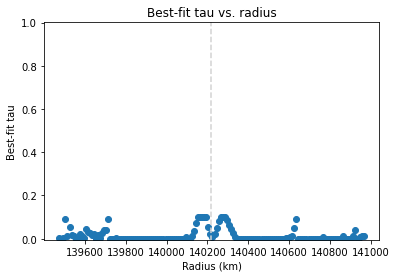

In [9]:
# Plot best-fit tau vs. radius (using iterative slices)
plt.figure()
plt.scatter(radii_iter, best_taus_iter)
plt.vlines([140220], colors=['lightgray'], ls='dashed', ymin=-0.01, ymax=1.01)
plt.title('Best-fit tau vs. radius')
plt.xlabel('Radius (km)')
plt.ylabel('Best-fit tau')
plt.ylim(-0.005, 1.001)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


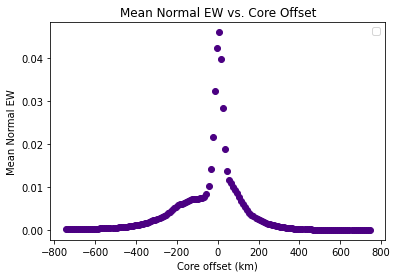

In [13]:
# Plot Mean EW vs. radius (using iterative slices)
plt.figure()
plt.scatter(np.array(radii_iter)-140220, mean_ews_iter, c='indigo',) #c=best_taus_iter, label='colormap = tau')
plt.title('Mean Normal EW vs. Core Offset')
plt.xlabel('Core offset (km)')
plt.ylabel('Mean Normal EW')
plt.legend()
plt.show()